# G150  Naima tests
* Naima is python package to compute nonthermal emission from a particle population
* It employs the emcee MCMC package to fit the radiative models to data

Bayes' theorem:
$\mathrm{P(A \mid B) = \frac{P(B \mid A) \, P(A)}{P(B)}}$

with:

$\mathrm{P(A \mid B)}$ == Posterior probability (think prob of model given data)

$\mathrm{P(A)}$ == prior 

$\mathrm{P(B \mid A)}$ == Likelihood

* emcee use an MCMC method to sample from the posterior distribution to find most likely values for the parameters of the model
* What's done is take log of both sides, the normalization parameter, $\mathrm{P(B)}$ is independent of the model, and then the likelihood, $\mathrm{P(B \mid A)}$, is maximized assuming some prior (often a flat prior, not sure what would motivate a different prior like a normally distributed one say)
* Start with some intial guess for parameters, and the MCMC sampler sets up n random walkers to probe the likelihood space, where the values of the next guess only depend on the previous step, to find the maximum likelihood.
* In naiama, we try to find the most likely parameters of some given particle distribution function that give the best fit of the radiative models (which take the particle distibution funcion as input) to our data.
 * This is wrong, we try to find the most likely parameters of the radiative model (which requires as input a particle distribution function) that fits the data

In [ ]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from astropy.table import Table
from astropy.io import ascii
from astropy import units as u
from astropy import constants as c
import pandas as pd
mpl.style.use('ggplot')
import naima
from naima.models import InverseCompton, Synchrotron, ExponentialCutoffPowerLaw, PionDecay, PowerLaw, Bremsstrahlung
#from sherpa.astro.ui import *
import naima.sherpa_models as smodels
import os, sys
from cycler import cycler

In [ ]:
mpl.rcParams['axes.facecolor'] = 'w'
mpl.rcParams['grid.color'] = 'k'
mpl.rcParams['grid.linestyle'] = ':'
mpl.rcParams['grid.alpha'] = 0.7
mpl.rcParams['axes.edgecolor'] = 'k'
mpl.rcParams['xtick.labelsize'] = 22
mpl.rcParams['ytick.labelsize'] = 22
mpl.rcParams['xtick.direction'] = 'in'
mpl.rcParams['ytick.direction'] = 'in'
#mpl.rcParams['axes.labelweight'] = 'k'
mpl.rcParams['font.weight'] = 'normal'
mpl.rcParams['font.size'] = 10
ncolors = plt.rcParams['axes.prop_cycle']

# Setup radio and GeV data

In [ ]:
tDir = '/Users/elunejava/Desktop/naimaTest/'
os.chdir(tDir)

#GeV
#G150_data = ascii.read(os.path.join(tDir,'data/G150_1gev_xgev_yerg_naimaSED.txt')) #ptlk fluxes
G150_data = ascii.read(os.path.join(tDir,'data/G150_gtlike_GeV_ erg.txt')) #gtlk fluxes


#Radio
#G150Radio = ascii.read(os.path.join(tDir,'data/G150_Gerbrandt14_full_MHz_mJy.txt'))
#symmetric errors
G150Radio = ascii.read(os.path.join(tDir,'data/G150_Gerbrandt14_full_MHz_mJy_errs.txt'))

#Xray UL
xray = ascii.read(os.path.join(tDir,'data/ROSAT_UL.txt'))
#check my errors

In [ ]:
G150Radio

In [ ]:
#MHz to Hz
G150Radio['frequency'].convert_unit_to(u.Hz)

#mJy to Jy
G150Radio['flux density'].convert_unit_to(u.Jy)
G150Radio['flux_error'].convert_unit_to(u.Jy)
# G150Radio['flux_error_lo'].convert_unit_to(u.Jy)
# G150Radio['flux_error_hi'].convert_unit_to(u.Jy)

G150Radio

In [ ]:
#convert radio flux density from mJy to ergs/s/cm^2/Hz
#1 Jy = 1e-23 ergs/s/cm^2/Hz
#1mJy = 1e-3 Jy = 1e-26 erg/s/cm^2/Hz

G150Radio['flux density'] = (G150Radio['flux density']*G150Radio['frequency'])/1e23
G150Radio['flux density'].name = 'flux'
G150Radio['flux'].unit = u.erg/u.s/(u.cm**2)

#lo errs
# G150Radio['flux_error_lo'] = (G150Radio['flux_error_lo']*G150Radio['frequency'])/1e23
# G150Radio['flux_error_lo'].unit = u.erg/u.s/(u.cm**2)
G150Radio['flux_error'] = (G150Radio['flux_error']*G150Radio['frequency'])/1e23
G150Radio['flux_error'].unit = u.erg/u.s/(u.cm**2)

#hi errs
# G150Radio['flux_error_hi'] = (G150Radio['flux_error_hi']*G150Radio['frequency'])/1e23
# G150Radio['flux_error_hi'].unit = u.erg/u.s/(u.cm**2)

#should the errors change the same way as flux or in quadrature?


G150Radio

In [ ]:
#convert radio freq, needs to be energy
G150Radio['frequency'].convert_unit_to(u.GeV,equivalencies=u.spectral())
G150Radio['frequency'].name = 'energy'

In [ ]:
G150Radio

In [ ]:
G150_data

# Plot the data just to check it looks right
## For the radio I haven't scaled the flux to account for the whole shell yet

In [ ]:
fig = plt.figure(figsize = [10,8])
figure = naima.plot_data(G150Radio,figure = fig, e_unit=u.GeV)
plt.title('G150 Radio: Gerbrandt et al. 2014, Partial shell')

In [ ]:
fig = plt.figure(figsize = [10,8])
figure = naima.plot_data(G150_data,figure = fig, e_unit=u.GeV)
plt.title('G150 gtlike SED')

In [ ]:
fig = plt.figure(figsize = [10,8])

figure = naima.plot_data([G150Radio,G150_data,xray],figure = fig, e_unit=u.eV)
plt.title('G150: Radio + X-ray + Gamma-Ray')

# 1. Test Just IC

In [ ]:
###why not prior for the cutoff? does it just mean I have no clue what the cutoff is? or that I just don't want to limit it?
###do I need to add params?
###this was for norm, inde,cutoff, B right?
def lnprior(pars):
    """
    Return probability of parameter values according to prior knowledge.
    Parameter 
        """
    # Limit norm to be > 0
    logprob = naima.uniform_prior(pars[0], 0., np.inf) \
                + naima.uniform_prior(pars[1], -1, 5)

    return logprob

In [ ]:
def electronIC(pars,data):
    """Decide between PL or ECPL model based on number
         of params in pars. Set up e- IC model"""
    #if this function needs to be passed into the model
    #not sure I can have ph fields as a param above
    #same for Eemin and dist
    
    #params not to be fit
    sd_ph = ['CMB','FIR','NIR']
    ic_eeMin = 1 * u.GeV
    dist = 0.39 *u.kpc
    
    #define units for params to be fit
    amplitude = 10**pars[0] / u.eV
    alpha = pars[1]
    
    #Instantiate particle distribution
    if len(pars) == 2:
        #print 'Particle distribution model is PL'
        pMod = PowerLaw(amplitude, 10. * u.TeV, alpha)
    elif len(pars) == 3:
        #print 'Particle distribution model is ECPL'
        e_cutoff = (10**pars[2]) * u.TeV
        pMod = ExponentialCutoffPowerLaw(amplitude, 10. * u.TeV, alpha, e_cutoff)
    else:
        raise Exception('Wrong number of params input for PL or ECPL')
    
    #instantiate IC models
    IC = InverseCompton(pMod,
                    seed_photon_fields=sd_ph,
                    Eemin=ic_eeMin)


    # compute flux at the energies
    model = (IC.flux(data,distance=dist))

    # Save this realization of the particle distribution function
    elec_energy = np.logspace(11, 15, 100) * u.eV
    nelec = pMod(elec_energy)

    We_IC = IC.compute_We(Eemin= ic_eeMin)#1 * u.TeV)
    return model, (elec_energy, nelec), We_IC

In [ ]:
#Define params that will go into model and labels for them
p0 = np.array((33, 2.5, np.log10(48.0))) #ECPL for now
if len(p0) == 2:
    labels = ['log10(norm)', 'index']
elif len(p0) ==3:
    labels = ['log10(norm)', 'index', 'log10(cutoff)']

## Run sampler
sampler, pos = naima.run_sampler(data_table=G150_data,
                                 p0=p0,
                                 labels=labels,
                                 model=electronIC,
                                 prior=lnprior,
                                 nwalkers=32,
                                 nburn=100,
                                 nrun=20,
                                 threads=4,
                                 prefit=True)

## Save run results to HDF5 file (can be read later with naima.read_run)
naima.save_run('G150_IC_run.hdf5', sampler)

## Diagnostic plots with labels for the metadata blobs
naima.save_diagnostic_plots('G150_IC',
                            sampler,
                            sed=True,
                            last_step=False,
                            blob_labels=['Electron Spectrum', 'Electron Energy Distribution',
                                         '$W_e (E_e>1\, \mathrm{GeV})$'])
naima.save_results_table('G150_IC', sampler)

In [ ]:
#my calc of stats
#why aren't they the same as above?
print 'median', np.median(pos,axis = 0)
print 'mean  ', np.mean(pos,axis = 0)
# print pos.min(axis = 0)
# print np.median(pos,axis = 0)-pos.min(axis = 0)


In [ ]:
#[log10(norm),norm,index,log10(cutoff),cutoff,blob2] blob2 is We
g150Res['median'][0] #30.2583497988
#g150Res['median']

# All the SED below show the median value determined by all the walkers

In [ ]:
#plot SED with best fit electron spec and data
fig = plt.figure(figsize = [10,8])
figure = naima.plot_data(G150_data,figure = fig, e_unit=u.eV)
ax = figure.axes[0]

#read back in the results
#I should be able to get this from pos, but I don't get the same medians for some reaons
g150Res = ascii.read(os.path.join(tDir,'G150_IC_results.ecsv'))
amplitude = 10**g150Res['median'][0] / u.eV
alpha = g150Res['median'][2]
e_cutoff = (10**g150Res['median'][3]) * u.TeV
We = g150Res['median'][5]
ECPL = ExponentialCutoffPowerLaw(amplitude, 10. * u.TeV, alpha, e_cutoff)

IC = InverseCompton(ECPL,
                    seed_photon_fields=['CMB','FIR','NIR'],
                    Eemax=50 * u.PeV, Eemin=1 * u.GeV)

# Plot the computed model emission
energy = np.logspace(-7, 15, 100) * u.eV
ax.loglog(energy, IC.sed(energy, 0.38 * u.kpc),
          lw=3, c='k', label='Total IC: $W_e (E_e>1\, \mathrm{GeV})$ =%0.2e erg, index_e = %0.2f' %(We,alpha))
for i, seed, ls in zip(range(4), ['CMB', 'FIR', 'NIR'], ['--', '-.', ':']):
    ax.loglog(energy, IC.sed(energy, 2 * u.kpc, seed=seed),
              lw=2, c=naima.plot.color_cycle[i + 1], label=seed, ls=ls)


ax.set_ylim(1e-16, 1e-10)
ax.set_xlim(1e4)
ax.legend(loc='best', frameon=False)
figure.tight_layout()
#figure.savefig('G150_IC_SED.png')

# 2. Test Just PP

In [ ]:
def PionDecayMod(pars, data):
    """Decide between PL or ECPL model based on number
       of params in pars. Set up pp Pion Decay model"""
    #params to fit
    amplitude = 10**pars[0] / u.TeV
    alpha = pars[1]
    e_cutoff = 10**pars[2] * u.TeV
    
    #params not to fit
    pp_peMin = 1 * u.GeV
    dist = 0.39 *u.kpc
    nh = 1*u.cm**-3 #can i not add this to pars and fit for it also? maybe too many params, better to fix and not have to fit if I have a good value?
    
    #Instantiate particle distribution
    if len(pars) == 2:
        #print 'Particle distribution model is PL'
        pMod = PowerLaw(amplitude, 10. * u.TeV, alpha)
    elif len(pars) == 3:
        #print 'Particle distribution model is ECPL'
        e_cutoff = (10**pars[2]) * u.TeV
        pMod = ExponentialCutoffPowerLaw(amplitude, 10. * u.TeV, alpha, e_cutoff)
    else:
        raise Exception('Wrong number of params input for PL or ECPL')
        
    #instantiate IC models
    PP = PionDecay(pMod, nh=nh)
    
    #calculate pp flux at energies of data
    model = PP.flux(G150_data, distance=dist)
    
    # Prepare an energy array for saving the particle distribution
    proton_energy = np.logspace(-3, 2, 50) * u.TeV
    
    # Save a realization of the particle distribution to the metadata blob
    proton_dist = PP.particle_distribution(proton_energy)
    
    # Compute the total energy in protons above 1 TeV for this realization
    Wp = PP.compute_Wp(Epmin=pp_peMin)

    # Return the model, proton distribution and energy in protons to be stored
    # in metadata blobs
    return model, (proton_energy, proton_dist), Wp



In [ ]:
#no reason to not use the same prior as for IC right?
#should I use the same p0 values as for IC? try with the IC ones first to see how it goes?
#PionDecay_ECPL_p0 = np.array((46, 2.34, np.log10(80.)))
PionDecay_ECPL_p0 = p0

if len(p0) == 2:
    labels = ['log10(norm)', 'index']
elif len(p0) ==3:
    labels = ['log10(norm)', 'index', 'log10(cutoff)']

## Run sampler
sampler, pos = naima.run_sampler( data_table=G150_data,
                                 p0=PionDecay_ECPL_p0,
                                 labels=labels,
                                 model=PionDecayMod,
                                 prior=lnprior,
                                 nwalkers=32,
                                 nburn=100,
                                 nrun=20,
                                 threads=4,
                                 prefit=True)

## Save run results to HDF5 file (can be read later with naima.read_run)
naima.save_run('G150_PP_run.hdf5', sampler)

## Diagnostic plots with labels for the metadata blobs
naima.save_diagnostic_plots('G150_PP',
                            sampler,
                            sed=True,
                            last_step=False,
                            blob_labels=['Proton Spectrum', 'Proton Energy Distribution',
                                         '$W_p (E_p>1\, \mathrm{GeV})$'])
naima.save_results_table('G150_PP', sampler)

In [ ]:
np.max(pos,axis =0)

# These are wrong and unnecessary! I loadeed the IC ECPL results and put those into PionDecay by accident!


In [ ]:

# #try plotting PP for other values I supply 
# #plot SED with best fit electron spec and data

# #different norms

# fig = plt.figure(figsize = [10,8])
# figure = naima.plot_data(G150_data,figure = fig, e_unit=u.eV)
# ax = figure.axes[0]


# g150Res = ascii.read(os.path.join(tDir,'G150_IC_results.ecsv'))
# amplitude = [10**g150Res['median'][0] / u.eV,(100*10**g150Res['median'][0] / u.eV),(1000*10**g150Res['median'][0] / u.eV)]
# alpha = g150Res['median'][2]
# e_cutoff = (10**g150Res['median'][3]) * u.TeV


# ECPL = [ExponentialCutoffPowerLaw(a, 10. * u.TeV, alpha, e_cutoff) for a in amplitude]
# PP = [PionDecay(ec, nh=1*u.cm**-3) for ec in ECPL]

# energy = np.logspace(-7, 15, 100) * u.eV

# for pp,i,l,ls in zip(PP, range(4),['Pion Decay: norm =2e44','Pion Decay: norm =2e46','Pion Decay: norm =2e47'],['--', '-.', ':']):
#     ax.loglog(energy, pp.sed(energy, 0.38 * u.kpc),
#              lw=3, c=naima.plot.color_cycle[i + 1], label=l, ls=ls)


# ax.set_ylim(1e-16, 1e-10)
# ax.set_xlim(1e4)
# ax.legend(loc='upper right', frameon=False)
# figure.tight_layout()
# #figure.savefig('G150_PP_SED.png')

In [ ]:
#These are wrong and unnecessary!
#i loadeed the IC ECPL results and put those into PionDecay by accident!

#try plotting PP for other values I supply 
#plot SED with best fit electron spec and data
fig = plt.figure(figsize = [10,8])
figure = naima.plot_data(G150_data,figure = fig, e_unit=u.eV)
ax = figure.axes[0]


g150Res = ascii.read(os.path.join(tDir,'G150_IC_results.ecsv'))
amplitude = 10**g150Res['median'][0] / u.eV
alpha = g150Res['median'][2]
e_cutoff = (10**g150Res['median'][3]) * u.TeV

ECPL = ExponentialCutoffPowerLaw(amplitude, 10. * u.TeV, alpha, e_cutoff)

PP = [PionDecay(ECPL, nh=1*u.cm**-3),PionDecay(ECPL, nh=100*u.cm**-3),PionDecay(ECPL, nh=1000*u.cm**-3)]
# PP1 = PionDecay(ECPL, nh=1*u.cm**-3)
# PP100 = PionDecay(ECPL, nh=100*u.cm**-3)
# pp1000 = PionDecay(ECPL, nh=1000*u.cm**-3)
# Plot the computed model emission

energy = np.logspace(-7, 15, 100) * u.eV

for pp,i,l,ls in zip(PP, range(4),['Pion Decay: n = 1/cm^3','Pion Decay: n = 100/cm^3','Pion Decay: n = 100/cm^3'],['--', '-.', ':']):
    ax.loglog(energy, pp.sed(energy, 0.38 * u.kpc),
             lw=3, c=naima.plot.color_cycle[i + 1], label=l, ls=ls)


ax.set_ylim(1e-16, 1e-10)
ax.set_xlim(1e4)
ax.legend(loc='upper right', frameon=False)
figure.tight_layout()
#figure.savefig('G150_PP_SED.png')

# Here are the good results!

In [ ]:
#try plotting PP for other values I supply 
#plot SED with best fit electron spec and data
fig = plt.figure(figsize = [10,8])
figure = naima.plot_data(G150_data,figure = fig, e_unit=u.eV)
ax = figure.axes[0]
g150Res = ascii.read(os.path.join(tDir,'G150_PP_results.ecsv'))
amplitude = 10**g150Res['median'][0] / u.TeV
alpha = g150Res['median'][2]
e_cutoff = (10**g150Res['median'][3]) * u.TeV
Wp = g150Res['median'][5]
ECPL = ExponentialCutoffPowerLaw(amplitude, 10. * u.TeV, alpha, e_cutoff)

nh = 1*u.cm**-3
PP = PionDecay(ECPL, nh=nh)

# Plot the computed model emission
energy = np.logspace(-7, 15, 100) * u.eV
ax.loglog(energy, PP.sed(energy, 0.38 * u.kpc),
          lw=3, c='k', label='Pion Decay: n=1 $\mathrm{cm}^{-3}$, $W_p (E_p>1\, \mathrm{GeV})$ =%0.2e erg, index = %0.2f' %(Wp,alpha))

# for pp,i,l,ls in zip(PP, range(4),['Pion Decay: n = 1/cm^3','Pion Decay: n = 100/cm^3','Pion Decay: n = 100/cm^3'],['--', '-.', ':']):
#     ax.loglog(energy, pp.sed(energy, 0.38 * u.kpc),
#              lw=3, c=naima.plot.color_cycle[i + 1], label=l, ls=ls)

ax.set_ylim(1e-16, 1e-10)
ax.set_xlim(1e4)
ax.legend(loc='best', frameon=False)
figure.tight_layout()
#figure.savefig('G150_PP_SED.png')

## Show best fits of the separate IC/PP models overlaid

In [ ]:
#try plotting PP for other values I supply 
#plot SED with best fit electron spec and data
fig = plt.figure(figsize = [10,8])
figure = naima.plot_data(G150_data,figure = fig, e_unit=u.eV)
ax = figure.axes[0]

###First PP
g150Res = ascii.read(os.path.join(tDir,'G150_PP_results.ecsv'))
amplitude = 10**g150Res['median'][0] / u.TeV
alpha = alpha = g150Res['median'][2]
e_cutoff = (10**g150Res['median'][3]) * u.TeV
Wp = g150Res['median'][5]

ECPL = ExponentialCutoffPowerLaw(amplitude, 10. * u.TeV, alpha, e_cutoff)

nh = 1*u.cm**-3
PP = PionDecay(ECPL, nh=nh)

# Plot the computed model emission
energy = np.logspace(-7, 15, 100) * u.eV
ax.loglog(energy, PP.sed(energy, 0.38 * u.kpc),
          lw=3, c=naima.plot.color_cycle[2], label='Pion Decay: n=1 $\mathrm{cm}^{-3}$, $W_p (E_p>1\, \mathrm{GeV})$ =%0.2e erg, index_p = %0.2f' %(Wp,alpha))

###Now IC
g150Res = ascii.read(os.path.join(tDir,'G150_IC_results.ecsv'))
amplitude = 10**g150Res['median'][0] / u.eV
alpha = g150Res['median'][2]
e_cutoff = (10**g150Res['median'][3]) * u.TeV
We = g150Res['median'][5]
ECPL = ExponentialCutoffPowerLaw(amplitude, 10. * u.TeV, alpha, e_cutoff)

IC = InverseCompton(ECPL,
                    seed_photon_fields=['CMB','FIR','NIR'],
                    Eemax=50 * u.PeV, Eemin=1 * u.GeV)

# Plot the computed model emission
energy = np.logspace(-7, 15, 100) * u.eV
ax.loglog(energy, IC.sed(energy, 0.38 * u.kpc),
          lw=3, c=naima.plot.color_cycle[1], label='Total IC: $W_e (E_e>1\, \mathrm{GeV})$ =%0.2e erg, index_e = %0.2f' %(We,alpha))
# for i, seed, ls in zip(range(4), ['CMB', 'FIR', 'NIR'], ['--', '-.', ':']):
#     ax.loglog(energy, IC.sed(energy, 2 * u.kpc, seed=seed),
#               lw=2, c=naima.plot.color_cycle[i + 1], label=seed, ls=ls)

ax.set_ylim(1e-16, 1e-10)
ax.set_xlim(1e4)
ax.legend(loc='upper right', frameon=False)
figure.tight_layout()
#figure.savefig('G150_PP_SED.png')

# Are the total energies in We, Wp reasonable?
# What about indices for each particle distribution?
## pp is way too hard

# 3. IC + PP: Same index, fit both norms

In [ ]:
#I think i shouldn't be using the same particle distribution for pp and IC
#since the normalization (number of e-/p or We/Wp) should be different 
#But I might expect to have the same index for both
#If I do, I don't know that I can tie the indicies for two seperate particle distributions in naima
#I likely can with sherpa though

#For now, just use two different particle pops with all different params, start with the same p0 for both
def IC_PP_Mod(pars, data):
    """Decide between PL or ECPL model based on number
       of params in pars. Set up pp Pion Decay and e- IC models"""
    
    #params not to fit
    pp_peMin = 1 * u.GeV
    ic_eeMin = 1 * u.GeV
    dist = 0.39 *u.kpc
    nh = 1*u.cm**-3 #can i not add this to pars and fit for it also? maybe too many params, better to fix and not have to fit if I have a good value?
    sd_ph = ['CMB','FIR','NIR']
    dist = 0.39 *u.kpc
    
    #params to fit for PP and IC
    #p0 = np.arra((norm_ic,norm_pp,index_both,cutoff_ic,cutoff_pp)) ###for ECPL, if PL, remove both cutoffs
    amplitude_IC = 10**pars[0] / u.TeV
    amplitude_PP = 10**pars[1] / u.TeV
    alpha = pars[2] #same index for both

    
    #Instantiate particle distributions for IC and PP
    if len(pars) == 3:
        #print 'Particle distribution model is PL'
        pMod_IC = PowerLaw_IC(amplitude_IC, 10. * u.TeV, alpha)
        pMod_PP = PowerLaw_PP(amplitude_PP, 10. * u.TeV, alpha)
        
    elif len(pars) == 5:
        #print 'Particle distribution model is ECPL'
        e_cutoff_IC = (10**pars[3]) * u.TeV
        pMod_IC = ExponentialCutoffPowerLaw(amplitude_IC, 10. * u.TeV, alpha, e_cutoff_IC)
        e_cutoff_PP = (10**pars[4]) * u.TeV
        pMod_PP = ExponentialCutoffPowerLaw(amplitude_PP, 10. * u.TeV, alpha, e_cutoff_PP)
    else:
        raise Exception('Wrong number of params input for PL or ECPL')
        
            
    #instantiate IC models
    PP = PionDecay(pMod_PP, nh=nh)
        
    #instantiate IC models
    IC = InverseCompton(pMod_IC,
                        seed_photon_fields=sd_ph,
                        Eemin=ic_eeMin)
    
    #calculate PP + IC flux at energies of data
    model = (IC.flux(data,
                     distance=dist) + PP.flux(G150_data, distance=dist))
    
    # Save this realization of the particle distribution function
    particle_energy = np.logspace(-3, 2, 50) * u.TeV
    nelec = pMod_IC(particle_energy)
    proton_dist = PP.particle_distribution(particle_energy) ###is PP.particle_distribution the same as pMod(eneegy?)

    # Compute the total energy in protons/electrons above 1 GeVfor this realization
    Wp = PP.compute_Wp(Epmin=pp_peMin)
    We = IC.compute_We(Eemin=ic_eeMin)#1 * u.TeV)

    # Return the model, proton distribution and energy in protons to be stored
    # in metadata blobs
    return model, (particle_energy, proton_dist), Wp, (particle_energy, nelec), We

def lnprior_IC_PP(pars):
    """
    Return probability of parameter values according to prior knowledge.
    Parameter. Include norm_IC, norm_PP, index. Not cutoffs
        """

    logprob = naima.uniform_prior(pars[0], 0., np.inf)          \
                    + naima.uniform_prior(pars[1],0., np.inf)      \
                    + naima.uniform_prior(pars[2], -1, 5) 

    return logprob

In [ ]:
#I think if I only pass in pars for one amp/ind/cutoff it won't fit two different
#maybe I can't pass in more labels than pars?
#is it possible to use only a single index par/label?
###Is there no such thing as a joint fit of elec and prot spec in naima?
###or maybe naima is smart and I can like this?


#p0 = np.arra((norm_ic,index_both,cutoff_ic,norm_pp,cutoff_pp))
p0 = np.array((30, 44, 2., np.log10(298),np.log10(202))) #start with same params for each, not sure this is best to do

##try this after running and maybe failing?
#p0 = np.array((31.1, 43.9,1.98,np.log10(49),np.log10(49)))
if len(p0) == 3:
    labels = ['log10(norm_IC)', 'log10(amplitude_PP)', 'index']
elif len(p0) ==5:
    labels = ['log10(norm_IC)', 'log10(amplitude_PP)', 'index', 'log10(cutoff_IC)','log10(cutoff_PP)']
    
## Run sampler
sampler, pos = naima.run_sampler(data_table=G150_data,
                                 p0=p0,
                                 labels=labels,
                                 model=IC_PP_Mod,
                                 prior=lnprior_IC_PP,
                                 nwalkers=32,
                                 nburn=100,
                                 nrun=20,
                                 threads=4,
                                 prefit=True,
                                 interactive = False)

## Save run results to HDF5 file (can be read later with naima.read_run)
naima.save_run('G150_IC_PP_run.hdf5', sampler)

## Diagnostic plots with labels for the metadata blobs
naima.save_diagnostic_plots('G150_IC_PP',
                            sampler,
                            sed=True,
                            last_step=False,
                            blob_labels=['Proton Spectrum', 'Proton Energy Distribution',
                                         '$W_p (E_p>1\, \mathrm{GeV})$',
                                         'Electron Spectrum', 'Electron Energy Distribution',
                                         '$W_e (E_e>1\, \mathrm{GeV})$'])
naima.save_results_table('G150_IC_PP', sampler)


In [ ]:
#Read in data, see what it looks like
g150Res_IC_PP = ascii.read(os.path.join(tDir,'G150_IC_PP_results.ecsv'))
g150Res_IC_PP

In [ ]:
#try plotting PP for other values I supply 
#plot SED with best fit electron spec and data
fig = plt.figure(figsize = [10,8])
figure = naima.plot_data(G150_data,figure = fig, e_unit=u.eV)
ax = figure.axes[0]

###First PP
amplitude_PP = 10**g150Res_IC_PP['median'][2] / u.TeV
alpha = alpha = g150Res_IC_PP['median'][4]
e_cutoff_PP = (10**g150Res_IC_PP['median'][7]) * u.TeV
Wp = g150Res_IC_PP['median'][9]

ECPL_PP = ExponentialCutoffPowerLaw(amplitude_PP, 10. * u.TeV, alpha, e_cutoff_PP)

nh = 1*u.cm**-3
PP = PionDecay(ECPL_PP, nh=nh)

# Plot the computed model emission
energy = np.logspace(-7, 15, 100) * u.eV
ax.loglog(energy, PP.sed(energy, 0.38 * u.kpc),
          lw=3, c=naima.plot.color_cycle[2], label='Pion Decay: n=1/cm^3, $W_p (E_p>1\, \mathrm{GeV})$ =%0.2e erg, index_ep = %0.2f' %(Wp,alpha))

###Now IC
amplitude_IC = 10**g150Res_IC_PP['median'][0] / u.TeV
e_cutoff_IC = (10**g150Res_IC_PP['median'][5]) * u.TeV
We = g150Res_IC_PP['median'][10]
ECPL_IC = ExponentialCutoffPowerLaw(amplitude_IC, 10. * u.TeV, alpha, e_cutoff_IC)

IC = InverseCompton(ECPL_IC,
                    seed_photon_fields=['CMB','FIR','NIR'],
                    Eemax=50 * u.PeV, Eemin=1 * u.GeV)

# Plot the computed model emission
energy = np.logspace(-7, 15, 100) * u.eV
ax.loglog(energy, IC.sed(energy, 0.38 * u.kpc),
          lw=3, c=naima.plot.color_cycle[1], label='Total IC: $W_e (E_e>1\, \mathrm{GeV})$ =%0.2e erg, index_ep = %0.2f' %(We,alpha))
# for i, seed, ls in zip(range(4), ['CMB', 'FIR', 'NIR'], ['--', '-.', ':']):
#     ax.loglog(energy, IC.sed(energy, 2 * u.kpc, seed=seed),
#               lw=2, c=naima.plot.color_cycle[i + 1], label=seed, ls=ls)

ax.set_ylim(1e-20, 1e-10)
ax.set_xlim(1e4)
ax.legend(loc='best', frameon=True)
figure.tight_layout()
#figure.savefig('G150_PP_SED.png')

# If I wanted to plot the error just use the low and high vals (16/84th percentiles)

# How does the above change if I use different starting values?
* Like If I start with a higher norm for IC does it find a different fit where the IC is more dominant?


# Do the results just mean that the data doesn't require a mixed model to fit?
* Why such different index for the IC/PP model vs just PP?

# 4. Fit with different index for PP/IC

In [ ]:
def IC_PP_Mod(pars, data):
    """Decide between PL or ECPL model based on number
       of params in pars. Set up pp Pion Decay and e- IC models"""
    
    #params not to fit
    pp_peMin = 1 * u.GeV
    ic_eeMin = 1 * u.GeV
    dist = 0.39 *u.kpc
    nh = 1*u.cm**-3 #can i not add this to pars and fit for it also? maybe too many params, better to fix and not have to fit if I have a good value?
    sd_ph = ['CMB','FIR','NIR']
    dist = 0.39 *u.kpc
    
    #params to fit for PP and IC
    #p0 = np.arra((norm_ic,norm_pp,index_both,cutoff_ic,cutoff_pp)) ###for ECPL, if PL, remove both cutoffs
    amplitude_IC = 10**pars[0] / u.TeV
    amplitude_PP = 10**pars[1] / u.TeV
    alpha_IC = pars[2]
    alpha_PP = pars[3]

    
    #Instantiate particle distributions for IC and PP
    if len(pars) == 4:
        #print 'Particle distribution model is PL'
        pMod_IC = PowerLaw_IC(amplitude_IC, 10. * u.TeV, alpha)
        pMod_PP = PowerLaw_PP(amplitude_PP, 10. * u.TeV, alpha)
        
    elif len(pars) == 6:
        #print 'Particle distribution model is ECPL'
        e_cutoff_IC = (10**pars[4]) * u.TeV
        pMod_IC = ExponentialCutoffPowerLaw(amplitude_IC, 10. * u.TeV, alpha, e_cutoff_IC)
        e_cutoff_PP = (10**pars[5]) * u.TeV
        pMod_PP = ExponentialCutoffPowerLaw(amplitude_PP, 10. * u.TeV, alpha, e_cutoff_PP)
    else:
        raise Exception('Wrong number of params input for PL or ECPL')
        
            
    #instantiate IC models
    PP = PionDecay(pMod_PP, nh=nh)
        
    #instantiate IC models
    IC = InverseCompton(pMod_IC,
                        seed_photon_fields=sd_ph,
                        Eemin=ic_eeMin)
    
    #calculate PP + IC flux at energies of data
    model = (IC.flux(data,
                     distance=dist) + PP.flux(G150_data, distance=dist))
    
    # Save this realization of the particle distribution function
    particle_energy = np.logspace(-3, 2, 50) * u.TeV
    nelec = pMod_IC(particle_energy)
    proton_dist = PP.particle_distribution(particle_energy) ###is PP.particle_distribution the same as pMod(eneegy?)

    # Compute the total energy in protons/electrons above 1 GeVfor this realization
    Wp = PP.compute_Wp(Epmin=pp_peMin)
    We = IC.compute_We(Eemin=ic_eeMin)#1 * u.TeV)

    # Return the model, proton distribution and energy in protons to be stored
    # in metadata blobs
    return model, (particle_energy, proton_dist), Wp, (particle_energy, nelec), We

def lnprior_IC_PP(pars):
    """
    Return probability of parameter values according to prior knowledge.
    Parameter. Include norm_IC, norm_PP, index. Not cutoffs
        """

    logprob = naima.uniform_prior(pars[0], 0., np.inf)       \
                    + naima.uniform_prior(pars[1],0., np.inf) \
                    + naima.uniform_prior(pars[2], -1, 5)     \
                    + naima.uniform_prior(pars[3], -1, 5) 

    return logprob

In [ ]:
#p0 = np.arra((norm_ic,index_both,cutoff_ic,norm_pp,cutoff_pp))
p0 = np.array((30, 44, 2.,2, np.log10(298),np.log10(202))) #start with same params for each, not sure this is best to do

##try this after running and maybe failing?
#p0 = np.array((31.1, 43.9,1.98,np.log10(49),np.log10(49)))
if len(p0) == 4:
    labels = ['log10(norm_IC)', 'log10(norm_PP)', 'index_IC','index_PP']
elif len(p0) ==6:
    labels = ['log10(norm_IC)', 'log10(norm_PP)', 'index_IC', 'index_PP', 'log10(cutoff_IC)','log10(cutoff_PP)']
    
## Run sampler
sampler, pos = naima.run_sampler(data_table=G150Radio,
                                 p0=p0,
                                 labels=labels,
                                 model=IC_PP_Mod,
                                 prior=lnprior_IC_PP,
                                 nwalkers=32,
                                 nburn=100,
                                 nrun=20,
                                 threads=4,
                                 prefit=True,
                                 interactive = False)

## Save run results to HDF5 file (can be read later with naima.read_run)
naima.save_run('G150_IC_PP_diffInd_run.hdf5', sampler)

## Diagnostic plots with labels for the metadata blobs
naima.save_diagnostic_plots('G150_IC_PP_difInd',
                            sampler,
                            sed=True,
                            last_step=False,
                            blob_labels=['Proton Spectrum', 'Proton Energy Distribution',
                                         '$W_p (E_p>1\, \mathrm{GeV})$',
                                         'Electron Spectrum', 'Electron Energy Distribution',
                                         '$W_e (E_e>1\, \mathrm{GeV})$'])
naima.save_results_table('G150_IC_PP_difInd', sampler)


### Don't bother plotting the above, the results look strange/bad
* Is something wrong with the setup or is there too much degeneracy between the params?

### What about using the interactive fitter to get the best fit params?
* Doesn't work right inside the notebook, even if I use %matplotlib notebook or qt (maybe I have to kill the server and restart it?

# 5. IC+PP+Sync, radio + GeV, Fit Kep, s, Ap, E_Cut_p,  E_Cut_e

### Add in radio SED from Gerbrandt et al. 2014
###  join the normalizations to be fixed for a given e/p: ${\rm A_{e} = K_{ep}A_{p}}$
### No bremss yet
### Include sync as well
### Do I need a filling/scaling factor since the radio is only a section of the shell
#### The angle is 84.6 deg (just took a screen shot and measure the angle in gimp, can I just say it's 1/4 of the shell?
#### Do I need to account for the emission not coming from the entire extended object but just the shell?
### K$_{e/p}$ is only the ratio of the norms if the norm of the e- and p distributions are of the same form (same index/cutoff), which they are here
### My reference energy for the particle distributions is 10 TeV (just took it from the turorials), but  K$_{e/p}$ = 0.01 at 10 GeV (measure at Earth)
#### See https://arxiv.org/pdf/1412.0672.pdf and refs therein
#### Reynolds 08 refs Gaisser 90 as 1/70 at 1 GeV
#### I thought something ref'd Hllas 06 too https://arxiv.org/pdf/astro-ph/0607109v2.pdf

In [ ]:
home  = %pwd
%pwd

In [ ]:
dirN= os.path.join(home,'IC_Sync_PP_wRadio_Xray_nrun20')
if not os.path.exists(dirN):
    os.mkdir(dirN)
os.chdir(dirN)
%pwd

In [ ]:
#I think i shouldn't be using the same particle distribution for pp and IC
#since the normalization (number of e-/p or We/Wp) should be different 
#But I might expect to have the same index for both
#If I do, I don't know that I can tie the indicies for two seperate particle distributions in naima
#I likely can with sherpa though

#For now, just use two different particle pops with all different params, start with the same p0 for both
def IC_PP_Syn_Mod(pars, data):
    """Decide between PL or ECPL model based on number
       of params in pars. Set up pp Pion Decay and e- IC models"""
    
    #params not to fit
    pp_peMin = 1 * u.GeV
    ic_sync_eeMin = 1 * u.GeV
    dist = 0.39 *u.kpc
    nh = 1*u.cm**-3 #can i not add this to pars and fit for it also? maybe too many params, better to fix and not have to fit if I have a good value?
    sd_ph = ['CMB','FIR','NIR']
    dist = 0.39 *u.kpc
    
    #params to fit for PP and IC
    #p0 = np.array((norm_ic,norm_pp,index_both,cutoff_ic,cutoff_pp)) ###for ECPL, if PL, remove both cutoffs
    kep = pars[0] #no units if I want to not fit this, choose a specific value
    #norm_ICsync = 10**pars[0] / u.TeV
    norm_PP = 10**pars[1] / u.TeV
    norm_ICsync = kep*norm_PP
    alpha = pars[2] #same index for both
    B = pars[3] * u.uG
    

    #Instantiate particle distributions for IC and PP
    if len(pars) == 4:
        #print 'Particle distribution model is PL'
        pMod_ICsync = PowerLaw(norm_ICsync, 10. * u.TeV, alpha)
        pMod_PP = PowerLaw(norm_PP, 10. * u.TeV, alpha)
        
    elif len(pars) == 6:
        #print 'Particle distribution model is ECPL'
        e_cutoff_ICsync = (10**pars[4]) * u.TeV
        pMod_ICsync = ExponentialCutoffPowerLaw(norm_ICsync, 10. * u.TeV, alpha, e_cutoff_ICsync)
        e_cutoff_PP = (10**pars[5]) * u.TeV
        pMod_PP = ExponentialCutoffPowerLaw(norm_PP, 10. * u.TeV, alpha, e_cutoff_PP)
    else:
        raise Exception('Wrong number of params input for PL or ECPL')
        
            
    #instantiate IC models
    PP = PionDecay(pMod_PP, nh=nh)
        
    #instantiate IC models
    IC = InverseCompton(pMod_ICsync,
                        seed_photon_fields=sd_ph,
                        Eemin=ic_sync_eeMin)
    #instantiate Sync models
    SYN = Synchrotron(pMod_ICsync, B=B)
    
    #calculate PP + IC flux at energies of data
    model = (IC.flux(data,
                     distance=dist) + PP.flux(data, distance=dist) +
                     SYN.flux(data,distance=dist))
    
    # Save this realization of the particle distribution function
    particle_energy = np.logspace(-3, 2, 50) * u.TeV
    nelec = pMod_ICsync(particle_energy)
    proton_dist = PP.particle_distribution(particle_energy) ###is PP.particle_distribution the same as pMod(energy?)

    # Compute the total energy in protons/electrons above 1 GeV for this realization
    # Is it fine to calc We using either IC or sycn? Should be the same since it's the same population?
    # or do I need to compute for both a sum?
    
    Wp = PP.compute_Wp(Epmin=pp_peMin)
    We = IC.compute_We(Eemin=ic_sync_eeMin)#1 * u.TeV)

    # Return the model, proton distribution and energy in protons to be stored
    # in metadata blobs
    return model, (particle_energy, proton_dist), Wp, (particle_energy, nelec), We

def lnprior_ICsync_PP(pars):
    """
    Return probability of parameter values according to prior knowledge.
    Parameter. Include norm_ICsync, norm_PP, index. Not cutoffs (why not?)
    
    Is the only reson to include a param in the prior here to limit the range of values?
    for Kep (par[0]) max=1, min set to something small and not 0
        """

    logprob = naima.uniform_prior(pars[0], 0.000001, 1)          \
                    + naima.uniform_prior(pars[1],0., np.inf)    \
                    + naima.uniform_prior(pars[2], -1, 5)        \
                    + naima.uniform_prior(pars[3], 0.1, 500)

    return logprob


In [ ]:
#idk if these are the best starting values
#kep: lep dom = 1, had dom = 0.1? 
#B: 3 : i know a few muG is the typicl ISM value, and typical of many SNR, but crab has ~200-300

#p0 = np.arra((norm_ic,index_both,cutoff_ic,norm_pp,cutoff_pp))
p0 = np.array((0.1, 44, 2., 3., np.log10(298),np.log10(202))) #start with same params for each, not sure this is best to do

##try this after running and maybe failing?
#p0 = np.array((31.1, 43.9,1.98,np.log10(49),np.log10(49)))
if len(p0) == 4:
    labels = ['Kep', 'log10(norm_PP)', 'index','B']
elif len(p0) ==6:
    labels = ['Kep', 'log10(norm_PP)', 'index', 'B','log10(cutoff_IC)','log10(cutoff_PP)']
    
## Run sampler
##change from nrun = 20 to 400
## double the number of walkers as well
##should I change the number of walkers as well?
## The reason to increase the number is to ensure that the sampling is stable and converges
##maybe having the number so was why the distributions looked funny, can't build it up with so few runs?
sampler, pos = naima.run_sampler(data_table=[G150Radio,G150_data],
                                 p0=p0,
                                 labels=labels,
                                 model=IC_PP_Syn_Mod,
                                 prior=lnprior_ICsync_PP,
                                 nwalkers=64,
                                 nburn=100,
                                 nrun=400,
                                 threads=4,
                                 prefit=True,
                                 interactive = False)

## Save run results to HDF5 file (can be read later with naima.read_run)
naima.save_run('G150_ICsync_PP_wRadio.hdf5', sampler)

## Diagnostic plots with labels for the metadata blobs
naima.save_diagnostic_plots('G150_ICsync_PP_wRadio',
                            sampler,
                            sed=True,
                            last_step=False,
                            blob_labels=['Proton Spectrum', 'Proton Energy Distribution',
                                         '$W_p (E_p>1\, \mathrm{GeV})$',
                                         'Electron Spectrum', 'Electron Energy Distribution',
                                         '$W_e (E_e>1\, \mathrm{GeV})$'])
naima.save_results_table('G150_ICsync_PP_wRadio', sampler)


In [ ]:
#Read in data, see what it looks like
g150Res_ICsync_PP = ascii.read('../IC_Sync_PP_wRadio_Xray_nrun20/G150_ICsync_PP_wRadio_Xray_results.ecsv')
g150Res_ICsync_PP

In [ ]:
for ind, nam in enumerate(g150Res_ICsync_PP):
    print ind, nam['label']

In [ ]:
print g150Res_ICsync_PP['median'][2] 
10**g150Res_ICsync_PP['median'][1] / u.TeV

In [ ]:
#Plot data + model
# * what should e_unit be? Try GeV, even though I used eV above
# * I need to figure out which param is which in the res file
# * What energy range to plot over?
# * do I not need to put emin/emax in IC?
# * add Kep
# * why is the amp / tev?
energy = np.logspace(-18, 2, 100) * u.TeV
fig = plt.figure(figsize = [10,8])

figure = naima.plot_data([G150Radio,G150_data],figure = fig, e_unit=u.TeV) 
ax = figure.axes[0]

###First PP
Kep = g150Res_ICsync_PP['median'][0]
amp_PP = g150Res_ICsync_PP['median'][2] / u.TeV
alpha = alpha = g150Res_ICsync_PP['median'][3]
e_cutoff_PP = g150Res_ICsync_PP['median'][8] * u.TeV
Wp = g150Res_ICsync_PP['median'][9]

ECPL_PP = ExponentialCutoffPowerLaw(amp_PP, 10. * u.TeV, alpha, e_cutoff_PP)

nh = 1*u.cm**-3
PP = PionDecay(ECPL_PP, nh=nh)

#Plot the computed model emission
ax.loglog(energy, PP.sed(energy, 0.38 * u.kpc),
          lw=2, ls = '--',c=naima.plot.color_cycle[3], label='Pion Decay: n=1/cm^3, $W_p (E_p>1\, \mathrm{GeV})$ =%0.2e erg, index_ep = %0.2f, K$_{ep}$ = %0.2f' %(Wp,alpha,Kep))

###Now IC
amp_ICsync = Kep*amp_PP #10**g150Res_ICsync_PP['median'][5] / u.TeV *
e_cutoff_ICsync = g150Res_ICsync_PP['median'][6] * u.TeV
We = g150Res_ICsync_PP['median'][10]
B = g150Res_ICsync_PP['median'][4]*u.uG


ECPL_ICsync = ExponentialCutoffPowerLaw(amp_ICsync, 10. * u.TeV, alpha, e_cutoff_ICsync)

IC = InverseCompton(ECPL_ICsync,
                    seed_photon_fields=['CMB','FIR','NIR'],
                    Eemax=50 * u.PeV, Eemin=1 * u.GeV)

###And Sync
Sync = Synchrotron(ECPL_ICsync,
                    B = B,)
# Plot the computed IC and Sync model emissions
ax.loglog(energy, IC.sed(energy, 0.38 * u.kpc),
          lw=2, ls = '--',c=naima.plot.color_cycle[1], label='Total IC: $W_e (E_e>1\, \mathrm{GeV})$ =%0.2e erg, index_ep = %0.2f, K$_{ep}$ = %0.2f' %(We,alpha,Kep))
                   
ax.loglog(energy, Sync.sed(energy, 0.38 * u.kpc),
          lw=3, c=naima.plot.color_cycle[2], label='Synchrotron: $W_e (E_e>1\, \mathrm{GeV})$ =%0.2e erg, index_ep = %0.2f, K$_{ep}$ = %0.2f, B = %0.2f $\mathrm{\mu}$G' %(We,alpha,Kep,B.value))

###IC + PP
#can I just sum them?
ax.loglog(energy, IC.sed(energy, 0.38 * u.kpc)+PP.sed(energy, 0.38 * u.kpc),
          lw=3,c=naima.plot.color_cycle[4], label='PP+ IC:')
                   
# for i, seed, ls in zip(range(4), ['CMB', 'FIR', 'NIR'], ['--', '-.', ':']):
#     ax.loglog(energy, IC.sed(energy, 2 * u.kpc, seed=seed),
#               lw=2, c=naima.plot.color_cycle[i + 1], label=seed, ls=ls)

ax.set_ylim(1e-16, 1e-10)
ax.set_xlim(7e-19,2)
ax.legend(loc='best', frameon=False)
figure.tight_layout()
figure.savefig('G150_ICsync_PP_SED.png')
figure.savefig('G150_ICsync_PP_SED.pdf')

figure.savefig('G150_ICsync_PP_SED.eps')

# Set up runs for fixed Kep = 0.001/0.01/0.1/1, and fixed index, s= 2?
### 0.001 some paper suggested 0.001 was the value determined for some young SNRs
### 0.01 is the value measure near Earth at 10 GeV
### 1 would be very leptionic dom
### should I free nh when i fix Kep to see how the density would have to change to accomdate the models?

# 6. IC+PP+Bremss+Sync, radio + GeV. Fit s, Ap, E_Cut_p,  E_Cut_e. Don't fit Kep, use xray emitting density upper lim
1. add bremss *DONE
2. modify so Kep is not fit
3. change density *DONE

In [ ]:
home  = %pwd
%pwd

In [ ]:
dirN= os.path.join(home,'IC_Sync_bremss_PP_wRadio_nrun400_Kep0_1')
if not os.path.exists(dirN):
    os.mkdir(dirN)
os.chdir(dirN)
%pwd

In [ ]:
nHbest = 0.00806
nHMax = nH = 0.00451

In [ ]:
#I think i shouldn't be using the same particle distribution for pp and IC
#since the normalization (number of e-/p or We/Wp) should be different 
#But I might expect to have the same index for both
#If I do, I don't know that I can tie the indicies for two seperate particle distributions in naima
#I likely can with sherpa though

#For now, just use two different particle pops with all different params, start with the same p0 for both
def IC_PP_Syn_Bremss_Mod(pars, data):
    """Decide between PL or ECPL model based on number
       of params in pars. Set up pp Pion Decay and e- IC models"""
    
    #params not to fit
    pp_peMin = 1 * u.GeV
    ic_sync_eeMin = 1 * u.GeV
    nh = 0.00806 / u.cm**3
    sd_ph = ['CMB','FIR','NIR']
    dist = 0.38461 *u.kpc
    
    #p0 = np.array((norm_ic,norm_pp,index_both,cutoff_ic,cutoff_pp)) ###for ECPL, if PL, remove both cutoffs
    kep = 0.01 #value measured at Earth
    #norm_ICsync = 10**pars[0] / u.TeV
    norm_PP = 10**pars[0] / u.TeV
    norm_ICsync = kep*norm_PP
    alpha = pars[1] #same index for both
    B = pars[2] * u.uG
    

    #Instantiate particle distributions for IC and PP
    if len(pars) == 3:
        #print 'Particle distribution model is PL'
        pMod_ICsync = PowerLaw(norm_ICsync, 10. * u.TeV, alpha)
        pMod_PP = PowerLaw(norm_PP, 10. * u.TeV, alpha)
        
    elif len(pars) == 5:
        #print 'Particle distribution model is ECPL'
        e_cutoff_ICsync = (10**pars[3]) * u.TeV
        pMod_ICsync = ExponentialCutoffPowerLaw(norm_ICsync, 10. * u.TeV, alpha, e_cutoff_ICsync)
        e_cutoff_PP = (10**pars[4]) * u.TeV
        pMod_PP = ExponentialCutoffPowerLaw(norm_PP, 10. * u.TeV, alpha, e_cutoff_PP)
    else:
        raise Exception('Wrong number of params input for PL or ECPL')
        
            
    #instantiate IC models
    PP = PionDecay(pMod_PP, nh=nh)
        
    #instantiate IC models
    IC = InverseCompton(pMod_ICsync,
                        seed_photon_fields=sd_ph,
                        Eemin=ic_sync_eeMin)
    #instantiate Sync models
    SYN = Synchrotron(pMod_ICsync, B=B)
    
    Brem = Bremsstrahlung(pMod_ICsync, n0 = nh)
    
    #calculate PP + IC flux at energies of data
    model = (IC.flux(data, distance=dist) +
             PP.flux(data, distance=dist) +
             SYN.flux(data,distance=dist) +
             Brem.flux(data,distance=dist))
    
    # Save this realization of the particle distribution function
    particle_energy = np.logspace(-3, 2, 50) * u.TeV
    nelec = pMod_ICsync(particle_energy)
    proton_dist = PP.particle_distribution(particle_energy) ###is PP.particle_distribution the same as pMod(energy?)

    # Compute the total energy in protons/electrons above 1 GeV for this realization
    # Is it fine to calc We using either IC or sycn? Should be the same since it's the same population?
    # or do I need to compute for both a sum?
    
    Wp = PP.compute_Wp(Epmin=pp_peMin)
    We = IC.compute_We(Eemin=ic_sync_eeMin)#1 * u.TeV)

    # Return the model, proton distribution and energy in protons to be stored
    # in metadata blobs
    return model, (particle_energy, proton_dist), Wp, (particle_energy, nelec), We

def lnprior_ICsyncBremss_PP(pars):
    """
    Return probability of parameter values according to prior knowledge.
    Parameter. Include norm_ICsync, norm_PP, index. Not cutoffs (why not?)
    normP, index, B
    Is the only reson to include a param in the prior here to limit the range of values?
    for Kep (par[0]) max=1, min set to something small and not 0
    Norm_PP, index, B, IC_cut, PP_cut
        """

    logprob =  naima.uniform_prior(pars[0],0., np.inf)           \
                    + naima.uniform_prior(pars[1], -1, 5)        \
                    + naima.uniform_prior(pars[2], 0.1, 500)     \
                    + naima.uniform_prior(pars[4], np.log10(0.001), np.log10(500))

    return logprob

#(10**pars[4]) * u.TeV


In [ ]:
#idk if these are the best starting values
#kep: has been fixed to 0.01
#B: 3 : i know a few muG is the typicl ISM value, and typical of many SNR, but crab has ~200-300

#p0 = np.arra((norm_ic,index_both,cutoff_ic,norm_pp,cutoff_pp))
p0 = np.array((44, 2., 3., np.log10(10),np.log10(50))) #start with same params for each, not sure this is best to do

##try this after running and maybe failing?
#p0 = np.array((31.1, 43.9,1.98,np.log10(49),np.log10(49)))
if len(p0) == 3:
    labels = ['log10(norm_PP)', 'index','B']
elif len(p0) ==5:
    labels = ['log10(norm_PP)', 'index', 'B','log10(cutoff_IC)','log10(cutoff_PP)']
    
## Run sampler
##change from nrun = 20 to 400
## double the number of walkers as well
##should I change the number of walkers as well?
## The reason to increase the number is to ensure that the sampling is stable and converges
##maybe having the number so was why the distributions looked funny, can't build it up with so few runs?

#original:nwalkers =32, nburn = 100 , nrun = 20
#high = nwalkers =63, nburn = 100 , nrun = 400
sampler, pos = naima.run_sampler(data_table=[G150Radio,G150_data,xray],
                                 p0=p0,
                                 labels=labels,
                                 model=IC_PP_Syn_Bremss_Mod,
                                 prior=lnprior_ICsyncBremss_PP,
                                 nwalkers=32,
                                 nburn=100,
                                 nrun=20,
                                 threads=4,
                                 prefit=True,
                                 interactive = False)

## Save run results to HDF5 file (can be read later with naima.read_run)
naima.save_run('G150_ICsyncBremss_PP_wRadio_Xray.hdf5', sampler)

## Diagnostic plots with labels for the metadata blobs
naima.save_diagnostic_plots('G150_ICsyncBremss_PP_wRadio_Xray',
                            sampler,
                            sed=True,
                            last_step=False,
                            blob_labels=['Proton Spectrum', 'Proton Energy Distribution',
                                         '$W_p (E_p>1\, \mathrm{GeV})$',
                                         'Electron Spectrum', 'Electron Energy Distribution',
                                         '$W_e (E_e>1\, \mathrm{GeV})$'])
naima.save_results_table('G150_ICsyncBremss_PP_wRadio_Xray', sampler)


In [ ]:
#Read in data, see what it looks like
g150Res_ICsyncBrems_PP = ascii.read('G150_ICsyncBremss_PP_wRadio_Xray_results.ecsv')
g150Res_ICsyncBrems_PP

In [ ]:
for ind, nam in enumerate(g150Res_ICsyncBrems_PP):
    print ind, nam['label'],nam['median']

In [ ]:
#Plot data + model
# * what should e_unit be? Try GeV, even though I used eV above
# * I need to figure out which param is which in the res file
# * What energy range to plot over?
# * do I not need to put emin/emax in IC?
# * add Kep
# * why is the amp / tev?
energy = np.logspace(-18, 2, 100) * u.TeV
fig = plt.figure(figsize = [10,8])

figure = naima.plot_data([G150Radio,G150_data,xray],figure = fig, e_unit=u.TeV) 
ax = figure.axes[0]

###First PP
Kep = 0.01#g150Res_ICsync_PP['median'][0]
amp_PP = g150Res_ICsyncBrems_PP['median'][1] / u.TeV
alpha = alpha = g150Res_ICsyncBrems_PP['median'][2]
e_cutoff_PP = g150Res_ICsyncBrems_PP['median'][7] * u.TeV
Wp = g150Res_ICsyncBrems_PP['median'][8]

ECPL_PP = ExponentialCutoffPowerLaw(amp_PP, 10. * u.TeV, alpha, e_cutoff_PP)

nh   = 0.00806*u.cm**-3
dist = 0.38461 * u.kpc
PP = PionDecay(ECPL_PP, nh=nh)

#Plot the computed model emission
ax.loglog(energy, PP.sed(energy, dist),
          lw=2, ls = '--',c=list(ncolors)[0]['color'], label='Pion Decay')#: n=1/cm^3, $W_p (E_p>1\, \mathrm{GeV})$ =%0.2e erg, index_ep = %0.2f, K$_{ep}$ = %0.2f' %(Wp,alpha,Kep))

###Now IC
amp_ICsync = Kep*amp_PP #10**g150Res_ICsync_PP['median'][5] / u.TeV *
e_cutoff_ICsync = g150Res_ICsyncBrems_PP['median'][5] * u.TeV
We = g150Res_ICsyncBrems_PP['median'][9]
B = g150Res_ICsyncBrems_PP['median'][3]*u.uG


ECPL_ICsync = ExponentialCutoffPowerLaw(amp_ICsync, 10. * u.TeV, alpha, e_cutoff_ICsync)

IC = InverseCompton(ECPL_ICsync,
                    seed_photon_fields=['CMB','FIR','NIR'],
                    Eemax=50 * u.PeV, Eemin=1 * u.GeV)

###And Sync
Sync = Synchrotron(ECPL_ICsync,
                    B = B,)

###Finally bremss

Bremss = Bremsstrahlung(ECPL_ICsync,n0=nh)

# Plot the computed IC and Sync model emissions
ax.loglog(energy, Bremss.sed(energy, dist),
          lw=2, ls = '--',c=list(ncolors)[1]['color'], label='Bremsstrahlung')
                   
ax.loglog(energy, IC.sed(energy, dist),
          lw=2, ls = '--',c=list(ncolors)[2]['color'], label='Total IC')#: $W_e (E_e>1\, \mathrm{GeV})$ =%0.2e erg, index_ep = %0.2f, K$_{ep}$ = %0.2f' %(We,alpha,Kep))
                   
ax.loglog(energy, Sync.sed(energy, dist),
          lw=3, c=list(ncolors)[3]['color'], label='Synchrotron')# $W_e (E_e>1\, \mathrm{GeV})$ =%0.2e erg, index_ep = %0.2f, K$_{ep}$ = %0.2f, B = %0.2f $\mathrm{\mu}$G' %(We,alpha,Kep,B.value))

###IC + PP + bresmss
#can I just sum them?
ax.loglog(energy, IC.sed(energy, dist)+PP.sed(energy, dist),
          lw=3,c=list(ncolors)[4]['color'], label='PP + IC + Bremsstrahlung')
                   
# for i, seed, ls in zip(range(4), ['CMB', 'FIR', 'NIR'], ['--', '-.', ':']):
#     ax.loglog(energy, IC.sed(energy, 2 * u.kpc, seed=seed),
#               lw=2, c=naima.plot.color_cycle[i + 1], label=seed, ls=ls)
ax.set_ylim(1e-16, 1e-10)
ax.set_xlim(7e-19,2)
ax.legend(loc='best', frameon=False,fontsize = 14)
figure.tight_layout()
plt.xlabel('Energy [TeV]',fontsize =24,weight='bold')


plt.ylabel(r'E$^{2}$ dN/dE (erg cm$^{-2}$ s$^{-1}$)',fontsize = 24,weight='bold')
#plt.xlabel(fontsize='large')
figure.savefig('G150_ICsyncBremss_PP_SED.png')
figure.savefig('G150_ICsyncBremss_PP_SED.pdf')
figure.savefig('G150_ICsyncBremss_PP_SED.eps')

## Even with the PP cut off limited to 500 TeV, the cuttoff is still ~100, which seems high
## But maybe this is just combined with the really hard index (~1) is suggestive that hadronic is not feasible at this density and level of GeV emission?

# 7. IC+PP+Bremss+Sync, radio + GeV + X-ray. Fit s, Ap, E_Cut_p,  E_Cut_e. Don't fit Kep, use xray emitting density upper lim
## Kep = 1
## E_Cut_p: <= 100 TeV

In [ ]:
dirN= os.path.join(tDir,'IC_Sync_bremss_PP_wRadio_Xray_nrun20_Kep1')
if not os.path.exists(dirN):
    os.mkdir(dirN)
os.chdir(dirN)
%pwd

In [ ]:
#I think i shouldn't be using the same particle distribution for pp and IC
#since the normalization (number of e-/p or We/Wp) should be different 
#But I might expect to have the same index for both
#If I do, I don't know that I can tie the indicies for two seperate particle distributions in naima
#I likely can with sherpa though

#For now, just use two different particle pops with all different params, start with the same p0 for both
def IC_PP_Syn_Bremss_Mod(pars, data):
    """Decide between PL or ECPL model based on number
       of params in pars. Set up pp Pion Decay and e- IC models"""
    
    #params not to fit
    pp_peMin = 1 * u.GeV
    ic_sync_eeMin = 1 * u.GeV
    nh = 0.00806 / u.cm**3
    sd_ph = ['CMB','FIR','NIR']
    dist = 0.38461 *u.kpc
    
    #p0 = np.array((norm_ic,norm_pp,index_both,cutoff_ic,cutoff_pp)) ###for ECPL, if PL, remove both cutoffs
    kep = 1.#0.01 #value measured at Earth
    #norm_ICsync = 10**pars[0] / u.TeV
    norm_PP = 10**pars[0] / u.TeV
    norm_ICsync = kep*norm_PP
    alpha = pars[1] #same index for both
    B = pars[2] * u.uG
    

    #Instantiate particle distributions for IC and PP
    if len(pars) == 3:
        #print 'Particle distribution model is PL'
        pMod_ICsync = PowerLaw(norm_ICsync, 10. * u.TeV, alpha)
        pMod_PP = PowerLaw(norm_PP, 10. * u.TeV, alpha)
        
    elif len(pars) == 5:
        #print 'Particle distribution model is ECPL'
        e_cutoff_ICsync = (10**pars[3]) * u.TeV
        pMod_ICsync = ExponentialCutoffPowerLaw(norm_ICsync, 10. * u.TeV, alpha, e_cutoff_ICsync)
        e_cutoff_PP = (10**pars[4]) * u.TeV
        pMod_PP = ExponentialCutoffPowerLaw(norm_PP, 10. * u.TeV, alpha, e_cutoff_PP)
    else:
        raise Exception('Wrong number of params input for PL or ECPL')
        
            
    #instantiate IC models
    PP = PionDecay(pMod_PP, nh=nh)
        
    #instantiate IC models
    IC = InverseCompton(pMod_ICsync,
                        seed_photon_fields=sd_ph,
                        Eemin=ic_sync_eeMin)
    #instantiate Sync models
    SYN = Synchrotron(pMod_ICsync, B=B)
    
    Brem = Bremsstrahlung(pMod_ICsync, n0 = nh)
    
    #calculate PP + IC flux at energies of data
    model = (IC.flux(data, distance=dist) +
             PP.flux(data, distance=dist) +
             SYN.flux(data,distance=dist) +
             Brem.flux(data,distance=dist))
    
    # Save this realization of the particle distribution function
    particle_energy = np.logspace(-3, 2, 50) * u.TeV
    nelec = pMod_ICsync(particle_energy)
    proton_dist = PP.particle_distribution(particle_energy) ###is PP.particle_distribution the same as pMod(energy?)

    # Compute the total energy in protons/electrons above 1 GeV for this realization
    # Is it fine to calc We using either IC or sycn? Should be the same since it's the same population?
    # or do I need to compute for both a sum?
    
    Wp = PP.compute_Wp(Epmin=pp_peMin)
    We = IC.compute_We(Eemin=ic_sync_eeMin)#1 * u.TeV)
    print 

    # Return the model, proton distribution and energy in protons to be stored
    # in metadata blobs
    return model, (particle_energy, proton_dist), Wp, (particle_energy, nelec), We

def lnprior_ICsyncBremss_PP(pars):
    """
    Return probability of parameter values according to prior knowledge.
    Parameter. Include norm_ICsync, norm_PP, index. Not cutoffs (why not?)
    normP, index, B
    Is the only reson to include a param in the prior here to limit the range of values?
    for Kep (par[0]) max=1, min set to something small and not 0
        """

    logprob =  naima.uniform_prior(pars[0],0., np.inf)           \
                    + naima.uniform_prior(pars[1], -1, 5)        \
                    + naima.uniform_prior(pars[2], 0.1, 500)     \
                    + naima.uniform_prior(pars[4], np.log10(0.001), np.log10(100))

    return logprob

#(10**pars[4]) * u.TeV


In [ ]:
#idk if these are the best starting values
#kep: has been fixed to 0.01
#B: 3 : i know a few muG is the typicl ISM value, and typical of many SNR, but crab has ~200-300

#p0 = np.arra((norm_ic,index_both,cutoff_ic,norm_pp,cutoff_pp))
p0 = np.array((44, 2., 3., np.log10(0.5),np.log10(5))) #start with same params for each, not sure this is best to do

##try this after running and maybe failing?
#p0 = np.array((31.1, 43.9,1.98,np.log10(49),np.log10(49)))
if len(p0) == 3:
    labels = ['log10(norm_PP)', 'index','B']
elif len(p0) ==5:
    labels = ['log10(norm_PP)', 'index', 'B','log10(cutoff_IC)','log10(cutoff_PP)']
    
## Run sampler
##change from nrun = 20 to 400
## double the number of walkers as well
##should I change the number of walkers as well?
## The reason to increase the number is to ensure that the sampling is stable and converges
##maybe having the number so was why the distributions looked funny, can't build it up with so few runs?

#original:nwalkers =32, nburn = 100 , nrun = 20
#high = nwalkers =63, nburn = 100 , nrun = 400
sampler, pos = naima.run_sampler(data_table=[G150Radio,G150_data,xray],
                                 p0=p0,
                                 labels=labels,
                                 model=IC_PP_Syn_Bremss_Mod,
                                 prior=lnprior_ICsyncBremss_PP,
                                 nwalkers=32,
                                 nburn=100,
                                 nrun=20,
                                 threads=4,
                                 prefit=True,
                                 interactive = False)

## Save run results to HDF5 file (can be read later with naima.read_run)
naima.save_run('G150_ICsyncBremss_PP_wRadio_Xray.hdf5', sampler)

## Diagnostic plots with labels for the metadata blobs
naima.save_diagnostic_plots('G150_ICsyncBremss_PP_wRadio_Xray',
                            sampler,
                            sed=True,
                            last_step=False,
                            blob_labels=['Proton Spectrum', 'Proton Energy Distribution',
                                         '$W_p (E_p>1\, \mathrm{GeV})$',
                                         'Electron Spectrum', 'Electron Energy Distribution',
                                         '$W_e (E_e>1\, \mathrm{GeV})$'])
naima.save_results_table('G150_ICsyncBremss_PP_wRadio_Xray', sampler)


In [ ]:
#Read in data, see what it looks like
g150Res_ICsyncBrems_PP = ascii.read('G150_ICsyncBremss_PP_wRadio_Xray_results.ecsv')
g150Res_ICsyncBrems_PP

In [ ]:
for ind, nam in enumerate(g150Res_ICsyncBrems_PP):
    print ind, nam['label'],nam['median']

In [ ]:
#Plot data + model
# * what should e_unit be? Try GeV, even though I used eV above
# * I need to figure out which param is which in the res file
# * What energy range to plot over?
# * do I not need to put emin/emax in IC?
# * add Kep
# * why is the amp / tev?
energy = np.logspace(-18, 2, 100) * u.TeV
fig = plt.figure(figsize = [10,8])

figure = naima.plot_data([G150Radio,G150_data,xray],figure = fig, e_unit=u.TeV) 
ax = figure.axes[0]

###First PP
Kep = 1.#g150Res_ICsync_PP['median'][0]
amp_PP = g150Res_ICsyncBrems_PP['median'][1] / u.TeV
alpha = alpha = g150Res_ICsyncBrems_PP['median'][2]
e_cutoff_PP = g150Res_ICsyncBrems_PP['median'][7] * u.TeV
Wp = g150Res_ICsyncBrems_PP['median'][8]

ECPL_PP = ExponentialCutoffPowerLaw(amp_PP, 10. * u.TeV, alpha, e_cutoff_PP)

nh   = 0.00806*u.cm**-3
dist = 0.38461 * u.kpc
PP = PionDecay(ECPL_PP, nh=nh)

#Plot the computed model emission
ax.loglog(energy, PP.sed(energy, dist),
          lw=2, ls = '--',c=list(ncolors)[0]['color'], label='Pion Decay')#: n=1/cm^3, $W_p (E_p>1\, \mathrm{GeV})$ =%0.2e erg, index_ep = %0.2f, K$_{ep}$ = %0.2f' %(Wp,alpha,Kep))

###Now IC
amp_ICsync = Kep*amp_PP #10**g150Res_ICsync_PP['median'][5] / u.TeV *
e_cutoff_ICsync = g150Res_ICsyncBrems_PP['median'][5] * u.TeV
We = g150Res_ICsyncBrems_PP['median'][9]
B = g150Res_ICsyncBrems_PP['median'][3]*u.uG


ECPL_ICsync = ExponentialCutoffPowerLaw(amp_ICsync, 10. * u.TeV, alpha, e_cutoff_ICsync)

IC = InverseCompton(ECPL_ICsync,
                    seed_photon_fields=['CMB','FIR','NIR'],
                    Eemax=50 * u.PeV, Eemin=1 * u.GeV)

###And Sync
Sync = Synchrotron(ECPL_ICsync,
                    B = B,)

###Finally bremss

Bremss = Bremsstrahlung(ECPL_ICsync,n0=nh)

# Plot the computed IC and Sync model emissions
ax.loglog(energy, Bremss.sed(energy, dist),
          lw=2, ls = '--',c=list(ncolors)[1]['color'], label='Bremsstrahlung')
                   
ax.loglog(energy, IC.sed(energy, dist),
          lw=2, ls = '--',c=list(ncolors)[2]['color'], label='Total IC')#: $W_e (E_e>1\, \mathrm{GeV})$ =%0.2e erg, index_ep = %0.2f, K$_{ep}$ = %0.2f' %(We,alpha,Kep))
                   
ax.loglog(energy, Sync.sed(energy, dist),
          lw=3, c=list(ncolors)[3]['color'], label='Synchrotron')# $W_e (E_e>1\, \mathrm{GeV})$ =%0.2e erg, index_ep = %0.2f, K$_{ep}$ = %0.2f, B = %0.2f $\mathrm{\mu}$G' %(We,alpha,Kep,B.value))

###IC + PP + bresmss
#can I just sum them?
ax.loglog(energy, IC.sed(energy, dist)+PP.sed(energy, dist),
          lw=3,c=list(ncolors)[4]['color'], label='PP + IC + Bremsstrahlung')
                   
# for i, seed, ls in zip(range(4), ['CMB', 'FIR', 'NIR'], ['--', '-.', ':']):
#     ax.loglog(energy, IC.sed(energy, 2 * u.kpc, seed=seed),
#               lw=2, c=naima.plot.color_cycle[i + 1], label=seed, ls=ls)
ax.set_ylim(1e-16, 1e-10)
ax.set_xlim(7e-19,2)
ax.legend(loc='best', frameon=False,fontsize = 14)
figure.tight_layout()
plt.xlabel('Energy [TeV]',fontsize =24,weight='bold')


plt.ylabel(r'E$^{2}$ dN/dE (erg cm$^{-2}$ s$^{-1}$)',fontsize = 24,weight='bold')
#plt.xlabel(fontsize='large')
# figure.savefig('G150_ICsyncBremss_PP_SED.png')
# figure.savefig('G150_ICsyncBremss_PP_SED.pdf')
# figure.savefig('G150_ICsyncBremss_PP_SED.eps')

In [ ]:
# can I change the particle min/max energy to get We/Wp closer to 0.1 10^51 erg?
Wp = PP.compute_Wp(Epmin=1000*u.GeV)
We = IC.compute_We(Eemin=1*u.GeV)#1 * u.TeV)
print 'Wp = %s, We = %s' %(Wp, We)

# 8. IC+PP+Bremss+Sync, radio + GeV + X-ray. Fit s, Ap, E_Cut_p,  E_Cut_e. Don't fit Kep, use xray emitting density upper lim
## Kep = 0.1 !!!
## E_Cut_p: <= 100 TeV

In [ ]:
dirN= os.path.join(tDir,'IC_Sync_bremss_PP_wRadio_Xray_nrun20_Kep01')
if not os.path.exists(dirN):
    os.mkdir(dirN)
os.chdir(dirN)
%pwd

In [ ]:
#I think i shouldn't be using the same particle distribution for pp and IC
#since the normalization (number of e-/p or We/Wp) should be different 
#But I might expect to have the same index for both
#If I do, I don't know that I can tie the indicies for two seperate particle distributions in naima
#I likely can with sherpa though

#For now, just use two different particle pops with all different params, start with the same p0 for both
def IC_PP_Syn_Bremss_Mod(pars, data):
    """Decide between PL or ECPL model based on number
       of params in pars. Set up pp Pion Decay and e- IC models"""
    
    #params not to fit
    pp_peMin = 1 * u.GeV
    ic_sync_eeMin = 1 * u.GeV
    nh = 0.00806 / u.cm**3
    sd_ph = ['CMB','FIR','NIR']
    dist = 0.38461 *u.kpc
    
    #p0 = np.array((norm_ic,norm_pp,index_both,cutoff_ic,cutoff_pp)) ###for ECPL, if PL, remove both cutoffs
    kep = 0.1 #0.01 #value measured at Earth
    #norm_ICsync = 10**pars[0] / u.TeV
    norm_PP = 10**pars[0] / u.TeV
    norm_ICsync = kep*norm_PP
    alpha = pars[1] #same index for both
    B = pars[2] * u.uG
    

    #Instantiate particle distributions for IC and PP
    if len(pars) == 3:
        #print 'Particle distribution model is PL'
        pMod_ICsync = PowerLaw(norm_ICsync, 10. * u.TeV, alpha)
        pMod_PP = PowerLaw(norm_PP, 10. * u.TeV, alpha)
        
    elif len(pars) == 5:
        #print 'Particle distribution model is ECPL'
        e_cutoff_ICsync = (10**pars[3]) * u.TeV
        pMod_ICsync = ExponentialCutoffPowerLaw(norm_ICsync, 10. * u.TeV, alpha, e_cutoff_ICsync)
        e_cutoff_PP = (10**pars[4]) * u.TeV
        pMod_PP = ExponentialCutoffPowerLaw(norm_PP, 10. * u.TeV, alpha, e_cutoff_PP)
    else:
        raise Exception('Wrong number of params input for PL or ECPL')
        
            
    #instantiate IC models
    PP = PionDecay(pMod_PP, nh=nh)
        
    #instantiate IC models
    IC = InverseCompton(pMod_ICsync,
                        seed_photon_fields=sd_ph,
                        Eemin=ic_sync_eeMin)
    #instantiate Sync models
    SYN = Synchrotron(pMod_ICsync, B=B)
    
    Brem = Bremsstrahlung(pMod_ICsync, n0 = nh)
    
    #calculate PP + IC flux at energies of data
    model = (IC.flux(data, distance=dist) +
             PP.flux(data, distance=dist) +
             SYN.flux(data,distance=dist) +
             Brem.flux(data,distance=dist))
    
    # Save this realization of the particle distribution function
    particle_energy = np.logspace(-3, 2, 50) * u.TeV
    nelec = pMod_ICsync(particle_energy)
    proton_dist = PP.particle_distribution(particle_energy) ###is PP.particle_distribution the same as pMod(energy?)

    # Compute the total energy in protons/electrons above 1 GeV for this realization
    # Is it fine to calc We using either IC or sycn? Should be the same since it's the same population?
    # or do I need to compute for both a sum?
    
    Wp = PP.compute_Wp(Epmin=pp_peMin)
    We = IC.compute_We(Eemin=ic_sync_eeMin)#1 * u.TeV)

    # Return the model, proton distribution and energy in protons to be stored
    # in metadata blobs
    return model, (particle_energy, proton_dist), Wp, (particle_energy, nelec), We

def lnprior_ICsyncBremss_PP(pars):
    """
    Return probability of parameter values according to prior knowledge.
    Parameter. Include norm_ICsync, norm_PP, index. Not cutoffs (why not?)
    normP, index, B
    Is the only reson to include a param in the prior here to limit the range of values?
    for Kep (par[0]) max=1, min set to something small and not 0
        """

    logprob =  naima.uniform_prior(pars[0],0., np.inf)           \
                    + naima.uniform_prior(pars[1], -1, 5)        \
                    + naima.uniform_prior(pars[2], 0.1, 500)     \
                    + naima.uniform_prior(pars[4], np.log10(0.001), np.log10(100))

    return logprob

#(10**pars[4]) * u.TeV


In [ ]:
#idk if these are the best starting values
#kep: has been fixed to 0.01
#B: 3 : i know a few muG is the typicl ISM value, and typical of many SNR, but crab has ~200-300

#p0 = np.arra((norm_ic,index_both,cutoff_ic,norm_pp,cutoff_pp))
p0 = np.array((44, 2., 3., np.log10(0.5),np.log10(5))) #start with same params for each, not sure this is best to do

##try this after running and maybe failing?
#p0 = np.array((31.1, 43.9,1.98,np.log10(49),np.log10(49)))
if len(p0) == 3:
    labels = ['log10(norm_PP)', 'index','B']
elif len(p0) ==5:
    labels = ['log10(norm_PP)', 'index', 'B','log10(cutoff_IC)','log10(cutoff_PP)']
    
## Run sampler
##change from nrun = 20 to 400
## double the number of walkers as well
##should I change the number of walkers as well?
## The reason to increase the number is to ensure that the sampling is stable and converges
##maybe having the number so was why the distributions looked funny, can't build it up with so few runs?

#original:nwalkers =32, nburn = 100 , nrun = 20
#high = nwalkers =63, nburn = 100 , nrun = 400
sampler, pos = naima.run_sampler(data_table=[G150Radio,G150_data,xray],
                                 p0=p0,
                                 labels=labels,
                                 model=IC_PP_Syn_Bremss_Mod,
                                 prior=lnprior_ICsyncBremss_PP,
                                 nwalkers=32,
                                 nburn=100,
                                 nrun=20,
                                 threads=4,
                                 prefit=True,
                                 interactive = False)

## Save run results to HDF5 file (can be read later with naima.read_run)
naima.save_run('G150_ICsyncBremss_PP_wRadio_Xray.hdf5', sampler)

## Diagnostic plots with labels for the metadata blobs
naima.save_diagnostic_plots('G150_ICsyncBremss_PP_wRadio_Xray',
                            sampler,
                            sed=True,
                            last_step=False,
                            blob_labels=['Proton Spectrum', 'Proton Energy Distribution',
                                         '$W_p (E_p>1\, \mathrm{GeV})$',
                                         'Electron Spectrum', 'Electron Energy Distribution',
                                         '$W_e (E_e>1\, \mathrm{GeV})$'])
naima.save_results_table('G150_ICsyncBremss_PP_wRadio_Xray', sampler)


In [ ]:
#Read in data, see what it looks like
g150Res_ICsyncBrems_PP = ascii.read('G150_ICsyncBremss_PP_wRadio_Xray_results.ecsv')
g150Res_ICsyncBrems_PP

In [ ]:
for ind, nam in enumerate(g150Res_ICsyncBrems_PP):
    print ind, nam['label'],nam['median']

In [ ]:
ncolors = plt.rcParams['axes.prop_cycle']
#Plot data + model
# * what should e_unit be? Try GeV, even though I used eV above
# * I need to figure out which param is which in the res file
# * What energy range to plot over?
# * do I not need to put emin/emax in IC?
# * add Kep
# * why is the amp / tev?
energy = np.logspace(-18, 2, 100) * u.TeV
fig = plt.figure(figsize = [10,8])

figure = naima.plot_data([G150Radio,G150_data,xray],figure = fig, e_unit=u.TeV) 
ax = figure.axes[0]

###First PP
Kep = 0.1#g150Res_ICsync_PP['median'][0]
amp_PP = g150Res_ICsyncBrems_PP['median'][1] / u.TeV
alpha = alpha = g150Res_ICsyncBrems_PP['median'][2]
e_cutoff_PP = g150Res_ICsyncBrems_PP['median'][7] * u.TeV
Wp = g150Res_ICsyncBrems_PP['median'][8]

ECPL_PP = ExponentialCutoffPowerLaw(amp_PP, 10. * u.TeV, alpha, e_cutoff_PP)

nh   = 0.00806*u.cm**-3
dist = 0.38461 * u.kpc
PP = PionDecay(ECPL_PP, nh=nh)

#Plot the computed model emission
ax.loglog(energy, PP.sed(energy, dist),
          lw=2, ls = '--',c=list(ncolors)[0]['color'], label='Pion Decay')#: n=1/cm^3, $W_p (E_p>1\, \mathrm{GeV})$ =%0.2e erg, index_ep = %0.2f, K$_{ep}$ = %0.2f' %(Wp,alpha,Kep))

###Now IC
amp_ICsync = Kep*amp_PP #10**g150Res_ICsync_PP['median'][5] / u.TeV *
e_cutoff_ICsync = g150Res_ICsyncBrems_PP['median'][5] * u.TeV
We = g150Res_ICsyncBrems_PP['median'][9]
B = g150Res_ICsyncBrems_PP['median'][3]*u.uG


ECPL_ICsync = ExponentialCutoffPowerLaw(amp_ICsync, 10. * u.TeV, alpha, e_cutoff_ICsync)

IC = InverseCompton(ECPL_ICsync,
                    seed_photon_fields=['CMB','FIR','NIR'],
                    Eemax=50 * u.PeV, Eemin=1 * u.GeV)

###And Sync
Sync = Synchrotron(ECPL_ICsync,
                    B = B,)

###Finally bremss

Bremss = Bremsstrahlung(ECPL_ICsync,n0=nh)

# Plot the computed IC and Sync model emissions
ax.loglog(energy, Bremss.sed(energy, dist),
          lw=2, ls = '--',c=list(ncolors)[1]['color'], label='Bremsstrahlung')
                   
ax.loglog(energy, IC.sed(energy, dist),
          lw=2, ls = '--',c=list(ncolors)[2]['color'], label='Total IC')#: $W_e (E_e>1\, \mathrm{GeV})$ =%0.2e erg, index_ep = %0.2f, K$_{ep}$ = %0.2f' %(We,alpha,Kep))
                   
ax.loglog(energy, Sync.sed(energy, dist),
          lw=3, c=list(ncolors)[3]['color'], label='Synchrotron')# $W_e (E_e>1\, \mathrm{GeV})$ =%0.2e erg, index_ep = %0.2f, K$_{ep}$ = %0.2f, B = %0.2f $\mathrm{\mu}$G' %(We,alpha,Kep,B.value))

###IC + PP + bresmss
#can I just sum them?
ax.loglog(energy, IC.sed(energy, dist)+PP.sed(energy, dist),
          lw=3,c=list(ncolors)[4]['color'], label='PP + IC + Bremsstrahlung')
                   
# for i, seed, ls in zip(range(4), ['CMB', 'FIR', 'NIR'], ['--', '-.', ':']):
#     ax.loglog(energy, IC.sed(energy, 2 * u.kpc, seed=seed),
#               lw=2, c=naima.plot.color_cycle[i + 1], label=seed, ls=ls)
ax.set_ylim(1e-16, 1e-10)
ax.set_xlim(7e-19,2)
ax.legend(loc='best', frameon=False,fontsize = 14)
figure.tight_layout()
plt.xlabel('Energy [TeV]',fontsize =24,weight='bold')


plt.ylabel(r'E$^{2}$ dN/dE (erg cm$^{-2}$ s$^{-1}$)',fontsize = 24,weight='bold')
#plt.xlabel(fontsize='large')
figure.savefig('G150_ICsyncBremss_PP_SED.png')
figure.savefig('G150_ICsyncBremss_PP_SED.pdf')
figure.savefig('G150_ICsyncBremss_PP_SED.eps')

# 9. IC+PP+Bremss+Sync, radio + GeV + X-ray. Fit s, Ap, E_Cut_p,  E_Cut_e. Don't fit Kep, use xray emitting density upper lim
## Change the density to 0.1

## Try Kep = 1 !!!
## E_Cut_p: <= 100 TeV

In [70]:
dirN= os.path.join(tDir,'IC_Sync_bremss_PP_wRadio_Xray_nrun20_Kep1_n1')
if not os.path.exists(dirN):
    os.mkdir(dirN)
os.chdir(dirN)
%pwd

u'/Users/elunejava/Desktop/naimaTest/IC_Sync_bremss_PP_wRadio_Xray_nrun20_Kep1_n1'

In [71]:
#I think i shouldn't be using the same particle distribution for pp and IC
#since the normalization (number of e-/p or We/Wp) should be different 
#But I might expect to have the same index for both
#If I do, I don't know that I can tie the indicies for two seperate particle distributions in naima
#I likely can with sherpa though

#For now, just use two different particle pops with all different params, start with the same p0 for both
def IC_PP_Syn_Bremss_Mod(pars, data):
    """Decide between PL or ECPL model based on number
       of params in pars. Set up pp Pion Decay and e- IC models"""
    
    #params not to fit
    pp_peMin = 1 * u.GeV
    ic_sync_eeMin = 1 * u.GeV
    nh = 0.1 / u.cm**3#0.00806 / u.cm**3
    sd_ph = ['CMB','FIR','NIR']
    dist = 0.38461 *u.kpc
    
    #p0 = np.array((norm_ic,norm_pp,index_both,cutoff_ic,cutoff_pp)) ###for ECPL, if PL, remove both cutoffs
    kep = 1. #0.01 #value measured at Earth
    #norm_ICsync = 10**pars[0] / u.TeV
    norm_PP = 10**pars[0] / u.TeV
    norm_ICsync = kep*norm_PP
    alpha = pars[1] #same index for both
    B = pars[2] * u.uG
    

    #Instantiate particle distributions for IC and PP
    if len(pars) == 3:
        #print 'Particle distribution model is PL'
        pMod_ICsync = PowerLaw(norm_ICsync, 10. * u.TeV, alpha)
        pMod_PP = PowerLaw(norm_PP, 10. * u.TeV, alpha)
        
    elif len(pars) == 5:
        #print 'Particle distribution model is ECPL'
        e_cutoff_ICsync = (10**pars[3]) * u.TeV
        pMod_ICsync = ExponentialCutoffPowerLaw(norm_ICsync, 10. * u.TeV, alpha, e_cutoff_ICsync)
        e_cutoff_PP = (10**pars[4]) * u.TeV
        pMod_PP = ExponentialCutoffPowerLaw(norm_PP, 10. * u.TeV, alpha, e_cutoff_PP)
    else:
        raise Exception('Wrong number of params input for PL or ECPL')
        
            
    #instantiate IC models
    PP = PionDecay(pMod_PP, nh=nh)
        
    #instantiate IC models
    IC = InverseCompton(pMod_ICsync,
                        seed_photon_fields=sd_ph,
                        Eemin=ic_sync_eeMin)
    #instantiate Sync models
    SYN = Synchrotron(pMod_ICsync, B=B)
    
    Brem = Bremsstrahlung(pMod_ICsync, n0 = nh)
    
    #calculate PP + IC flux at energies of data
    model = (IC.flux(data, distance=dist) +
             PP.flux(data, distance=dist) +
             SYN.flux(data,distance=dist) +
             Brem.flux(data,distance=dist))
    
    # Save this realization of the particle distribution function
    particle_energy = np.logspace(-3, 2, 50) * u.TeV
    nelec = pMod_ICsync(particle_energy)
    proton_dist = PP.particle_distribution(particle_energy) ###is PP.particle_distribution the same as pMod(energy?)

    # Compute the total energy in protons/electrons above 1 GeV for this realization
    # Is it fine to calc We using either IC or sycn? Should be the same since it's the same population?
    # or do I need to compute for both a sum?
    
    Wp = PP.compute_Wp(Epmin=pp_peMin)
    We = IC.compute_We(Eemin=ic_sync_eeMin)#1 * u.TeV)

    # Return the model, proton distribution and energy in protons to be stored
    # in metadata blobs
    return model, (particle_energy, proton_dist), Wp, (particle_energy, nelec), We

def lnprior_ICsyncBremss_PP(pars):
    """
    Return probability of parameter values according to prior knowledge.
    Parameter. Include norm_ICsync, norm_PP, index. Not cutoffs (why not?)
    normP, index, B
    Is the only reson to include a param in the prior here to limit the range of values?
    for Kep (par[0]) max=1, min set to something small and not 0
        """

    logprob =  naima.uniform_prior(pars[0],0., np.inf)           \
                    + naima.uniform_prior(pars[1], -1, 5)        \
                    + naima.uniform_prior(pars[2], 0.1, 500)     \
                    + naima.uniform_prior(pars[4], np.log10(0.001), np.log10(100))

    return logprob

#(10**pars[4]) * u.TeV


In [ ]:
#idk if these are the best starting values
#kep: has been fixed to 0.01
#B: 3 : i know a few muG is the typicl ISM value, and typical of many SNR, but crab has ~200-300

#p0 = np.arra((norm_ic,index_both,cutoff_ic,norm_pp,cutoff_pp))
p0 = np.array((44, 2., 3., np.log10(0.5),np.log10(5))) #start with same params for each, not sure this is best to do

##try this after running and maybe failing?
#p0 = np.array((31.1, 43.9,1.98,np.log10(49),np.log10(49)))
if len(p0) == 3:
    labels = ['log10(norm_PP)', 'index','B']
elif len(p0) ==5:
    labels = ['log10(norm_PP)', 'index', 'B','log10(cutoff_IC)','log10(cutoff_PP)']
    
## Run sampler
##change from nrun = 20 to 400
## double the number of walkers as well
##should I change the number of walkers as well?
## The reason to increase the number is to ensure that the sampling is stable and converges
##maybe having the number so was why the distributions looked funny, can't build it up with so few runs?

#original:nwalkers =32, nburn = 100 , nrun = 20
#high = nwalkers =63, nburn = 100 , nrun = 400
sampler, pos = naima.run_sampler(data_table=[G150Radio,G150_data,xray],
                                 p0=p0,
                                 labels=labels,
                                 model=IC_PP_Syn_Bremss_Mod,
                                 prior=lnprior_ICsyncBremss_PP,
                                 nwalkers=32,
                                 nburn=100,
                                 nrun=20,
                                 threads=4,
                                 prefit=True,
                                 interactive = False)

## Save run results to HDF5 file (can be read later with naima.read_run)
naima.save_run('G150_ICsyncBremss_PP_wRadio_Xray.hdf5', sampler)

## Diagnostic plots with labels for the metadata blobs
naima.save_diagnostic_plots('G150_ICsyncBremss_PP_wRadio_Xray',
                            sampler,
                            sed=True,
                            last_step=False,
                            blob_labels=['Proton Spectrum', 'Proton Energy Distribution',
                                         '$W_p (E_p>1\, \mathrm{GeV})$',
                                         'Electron Spectrum', 'Electron Energy Distribution',
                                         '$W_e (E_e>1\, \mathrm{GeV})$'])
naima.save_results_table('G150_ICsyncBremss_PP_wRadio_Xray', sampler)


In [73]:
#Read in data, see what it looks like
###WHERE ARE THESE PLOTs?
g150Res_ICsyncBrems_PP = ascii.read('G150_ICsyncBremss_PP_wRadio_Xray_results.ecsv')
g150Res_ICsyncBrems_PP

In [ ]:
ncolors = plt.rcParams['axes.prop_cycle']
#Plot data + model
# * what should e_unit be? Try GeV, even though I used eV above
# * I need to figure out which param is which in the res file
# * What energy range to plot over?
# * do I not need to put emin/emax in IC?
# * add Kep
# * why is the amp / tev?
energy = np.logspace(-18, 2, 100) * u.TeV
fig = plt.figure(figsize = [10,8])

figure = naima.plot_data([G150Radio,G150_data,xray],figure = fig, e_unit=u.TeV) 
ax = figure.axes[0]

###First PP
Kep = 1.#g150Res_ICsync_PP['median'][0]
amp_PP = g150Res_ICsyncBrems_PP['median'][1] / u.TeV
alpha = alpha = g150Res_ICsyncBrems_PP['median'][2]
e_cutoff_PP = g150Res_ICsyncBrems_PP['median'][7] * u.TeV
Wp = g150Res_ICsyncBrems_PP['median'][8]

ECPL_PP = ExponentialCutoffPowerLaw(amp_PP, 10. * u.TeV, alpha, e_cutoff_PP)

nh   = 0.1*u.cm**-3#0.00806*u.cm**-3
dist = 0.38461 * u.kpc
PP = PionDecay(ECPL_PP, nh=nh)

#Plot the computed model emission
ax.loglog(energy, PP.sed(energy, dist),
          lw=2, ls = '--',c=list(ncolors)[0]['color'], label='Pion Decay')#: n=1/cm^3, $W_p (E_p>1\, \mathrm{GeV})$ =%0.2e erg, index_ep = %0.2f, K$_{ep}$ = %0.2f' %(Wp,alpha,Kep))

###Now IC
amp_ICsync = Kep*amp_PP #10**g150Res_ICsync_PP['median'][5] / u.TeV *
e_cutoff_ICsync = g150Res_ICsyncBrems_PP['median'][5] * u.TeV
We = g150Res_ICsyncBrems_PP['median'][9]
B = g150Res_ICsyncBrems_PP['median'][3]*u.uG


ECPL_ICsync = ExponentialCutoffPowerLaw(amp_ICsync, 10. * u.TeV, alpha, e_cutoff_ICsync)

IC = InverseCompton(ECPL_ICsync,
                    seed_photon_fields=['CMB','FIR','NIR'],
                    Eemax=50 * u.PeV, Eemin=1 * u.GeV)

###And Sync
Sync = Synchrotron(ECPL_ICsync,
                    B = B,)

###Finally bremss

Bremss = Bremsstrahlung(ECPL_ICsync,n0=nh)

# Plot the computed IC and Sync model emissions
ax.loglog(energy, Bremss.sed(energy, dist),
          lw=2, ls = '--',c=list(ncolors)[1]['color'], label='Bremsstrahlung')
                   
ax.loglog(energy, IC.sed(energy, dist),
          lw=2, ls = '--',c=list(ncolors)[2]['color'], label='Total IC')#: $W_e (E_e>1\, \mathrm{GeV})$ =%0.2e erg, index_ep = %0.2f, K$_{ep}$ = %0.2f' %(We,alpha,Kep))
                   
ax.loglog(energy, Sync.sed(energy, dist),
          lw=3, c=list(ncolors)[3]['color'], label='Synchrotron')# $W_e (E_e>1\, \mathrm{GeV})$ =%0.2e erg, index_ep = %0.2f, K$_{ep}$ = %0.2f, B = %0.2f $\mathrm{\mu}$G' %(We,alpha,Kep,B.value))

###IC + PP + bresmss
#can I just sum them?
ax.loglog(energy, IC.sed(energy, dist)+PP.sed(energy, dist),
          lw=3,c=list(ncolors)[4]['color'], label='PP + IC + Bremsstrahlung')
                   
# for i, seed, ls in zip(range(4), ['CMB', 'FIR', 'NIR'], ['--', '-.', ':']):
#     ax.loglog(energy, IC.sed(energy, 2 * u.kpc, seed=seed),
#               lw=2, c=naima.plot.color_cycle[i + 1], label=seed, ls=ls)
ax.set_ylim(1e-16, 1e-10)
ax.set_xlim(7e-19,2)
ax.legend(loc='lower left', frameon=False,fontsize = 14)
figure.tight_layout()
plt.xlabel('Energy [TeV]',fontsize =24,weight='bold')


plt.ylabel(r'E$^{2}$ dN/dE (erg cm$^{-2}$ s$^{-1}$)',fontsize = 24,weight='bold')
#plt.xlabel(fontsize='large')
if not os.path.exists('G150_ICsyncBremss_PP_SED.png')
    figure.savefig('G150_ICsyncBremss_PP_SED.png')
    figure.savefig('G150_ICsyncBremss_PP_SED.pdf')
    figure.savefig('G150_ICsyncBremss_PP_SED.eps')

# 10. IC+PP+Bremss+Sync, radio + GeV + X-ray. Fit s, Ap, E_Cut_p,  E_Cut_e. Don't fit Kep, use xray emitting density upper lim
## Change the density to near x-ray

## Try Kep = 0.01 !!!
## E_Cut_p: <= 100 TeV

In [66]:
dirN= os.path.join(tDir,'IC_Sync_bremss_PP_wRadio_Xray_nrun20_Kep001')
if not os.path.exists(dirN):
    os.mkdir(dirN)
os.chdir(dirN)
%pwd

u'/Users/elunejava/Desktop/naimaTest/IC_Sync_bremss_PP_wRadio_Xray_nrun20_Kep001'

In [67]:
#I think i shouldn't be using the same particle distribution for pp and IC
#since the normalization (number of e-/p or We/Wp) should be different 
#But I might expect to have the same index for both
#If I do, I don't know that I can tie the indicies for two seperate particle distributions in naima
#I likely can with sherpa though

#For now, just use two different particle pops with all different params, start with the same p0 for both
def IC_PP_Syn_Bremss_Mod(pars, data):
    """Decide between PL or ECPL model based on number
       of params in pars. Set up pp Pion Decay and e- IC models"""
    
    #params not to fit
    pp_peMin = 1 * u.GeV
    ic_sync_eeMin = 1 * u.GeV
    nh = 0.00806 / u.cm**3
    sd_ph = ['CMB','FIR','NIR']
    dist = 0.38461 *u.kpc
    
    #p0 = np.array((norm_ic,norm_pp,index_both,cutoff_ic,cutoff_pp)) ###for ECPL, if PL, remove both cutoffs
    kep = 0.01 #value measured at Earth
    #norm_ICsync = 10**pars[0] / u.TeV
    norm_PP = 10**pars[0] / u.TeV
    norm_ICsync = kep*norm_PP
    alpha = pars[1] #same index for both
    B = pars[2] * u.uG
    

    #Instantiate particle distributions for IC and PP
    if len(pars) == 3:
        #print 'Particle distribution model is PL'
        pMod_ICsync = PowerLaw(norm_ICsync, 10. * u.TeV, alpha)
        pMod_PP = PowerLaw(norm_PP, 10. * u.TeV, alpha)
        
    elif len(pars) == 5:
        #print 'Particle distribution model is ECPL'
        e_cutoff_ICsync = (10**pars[3]) * u.TeV
        pMod_ICsync = ExponentialCutoffPowerLaw(norm_ICsync, 10. * u.TeV, alpha, e_cutoff_ICsync)
        e_cutoff_PP = (10**pars[4]) * u.TeV
        pMod_PP = ExponentialCutoffPowerLaw(norm_PP, 10. * u.TeV, alpha, e_cutoff_PP)
    else:
        raise Exception('Wrong number of params input for PL or ECPL')
        
            
    #instantiate IC models
    PP = PionDecay(pMod_PP, nh=nh)
        
    #instantiate IC models
    IC = InverseCompton(pMod_ICsync,
                        seed_photon_fields=sd_ph,
                        Eemin=ic_sync_eeMin)
    #instantiate Sync models
    SYN = Synchrotron(pMod_ICsync, B=B)
    
    Brem = Bremsstrahlung(pMod_ICsync, n0 = nh)
    
    #calculate PP + IC flux at energies of data
    model = (IC.flux(data, distance=dist) +
             PP.flux(data, distance=dist) +
             SYN.flux(data,distance=dist) +
             Brem.flux(data,distance=dist))
    
    # Save this realization of the particle distribution function
    particle_energy = np.logspace(-3, 2, 50) * u.TeV
    nelec = pMod_ICsync(particle_energy)
    proton_dist = PP.particle_distribution(particle_energy) ###is PP.particle_distribution the same as pMod(energy?)

    # Compute the total energy in protons/electrons above 1 GeV for this realization
    # Is it fine to calc We using either IC or sycn? Should be the same since it's the same population?
    # or do I need to compute for both a sum?
    
    Wp = PP.compute_Wp(Epmin=pp_peMin)
    We = IC.compute_We(Eemin=ic_sync_eeMin)#1 * u.TeV)

    # Return the model, proton distribution and energy in protons to be stored
    # in metadata blobs
    return model, (particle_energy, proton_dist), Wp, (particle_energy, nelec), We

def lnprior_ICsyncBremss_PP(pars):
    """
    Return probability of parameter values according to prior knowledge.
    Parameter. Include norm_ICsync, norm_PP, index. Not cutoffs (why not?)
    normP, index, B
    Is the only reson to include a param in the prior here to limit the range of values?
    for Kep (par[0]) max=1, min set to something small and not 0
        """

    logprob =  naima.uniform_prior(pars[0],0., np.inf)           \
                    + naima.uniform_prior(pars[1], -1, 5)        \
                    + naima.uniform_prior(pars[2], 0.1, 500)     \
                    + naima.uniform_prior(pars[4], np.log10(0.001), np.log10(100))

    return logprob

#(10**pars[4]) * u.TeV


In [ ]:
#idk if these are the best starting values
#kep: has been fixed to 0.01
#B: 3 : i know a few muG is the typicl ISM value, and typical of many SNR, but crab has ~200-300

#p0 = np.arra((norm_ic,index_both,cutoff_ic,norm_pp,cutoff_pp))
p0 = np.array((44, 2., 3., np.log10(0.5),np.log10(5))) #start with same params for each, not sure this is best to do

##try this after running and maybe failing?
#p0 = np.array((31.1, 43.9,1.98,np.log10(49),np.log10(49)))
if len(p0) == 3:
    labels = ['log10(norm_PP)', 'index','B']
elif len(p0) ==5:
    labels = ['log10(norm_PP)', 'index', 'B','log10(cutoff_IC)','log10(cutoff_PP)']
    
## Run sampler
##change from nrun = 20 to 400
## double the number of walkers as well
##should I change the number of walkers as well?
## The reason to increase the number is to ensure that the sampling is stable and converges
##maybe having the number so was why the distributions looked funny, can't build it up with so few runs?

#original:nwalkers =32, nburn = 100 , nrun = 20
#high = nwalkers =63, nburn = 100 , nrun = 400
sampler, pos = naima.run_sampler(data_table=[G150Radio,G150_data,xray],
                                 p0=p0,
                                 labels=labels,
                                 model=IC_PP_Syn_Bremss_Mod,
                                 prior=lnprior_ICsyncBremss_PP,
                                 nwalkers=32,
                                 nburn=100,
                                 nrun=20,
                                 threads=4,
                                 prefit=True,
                                 interactive = False)

## Save run results to HDF5 file (can be read later with naima.read_run)
naima.save_run('G150_ICsyncBremss_PP_wRadio_Xray.hdf5', sampler)

## Diagnostic plots with labels for the metadata blobs
naima.save_diagnostic_plots('G150_ICsyncBremss_PP_wRadio_Xray',
                            sampler,
                            sed=True,
                            last_step=False,
                            blob_labels=['Proton Spectrum', 'Proton Energy Distribution',
                                         '$W_p (E_p>1\, \mathrm{GeV})$',
                                         'Electron Spectrum', 'Electron Energy Distribution',
                                         '$W_e (E_e>1\, \mathrm{GeV})$'])
naima.save_results_table('G150_ICsyncBremss_PP_wRadio_Xray', sampler)


In [68]:
#Read in data, see what it looks like
g150Res_ICsyncBrems_PP = ascii.read('G150_ICsyncBremss_PP_wRadio_Xray_results.ecsv')
g150Res_ICsyncBrems_PP

label,median,unc_lo,unc_hi
str16,float64,float64,float64
log10(norm_PP),47.1806919783,0.399069396819,0.609008912852
norm_PP,1.51597478692e+47,9.1115974796e+46,4.64587406633e+47
index,1.18812972004,0.170856731363,0.114129275795
B,3.56324007241,0.910509417572,0.40656794758
log10(cutoff_IC),-0.232432574076,0.295222687365,0.183209528609
cutoff_IC,0.585555558723,0.288836956207,0.307291301236
log10(cutoff_PP),1.35388877876,2.04910253052,0.546402267515
cutoff_PP,22.58857211,22.3868347895,56.8975018101
blob2,8.63977046092e+49,8.56488520189e+49,4.28325705161e+50


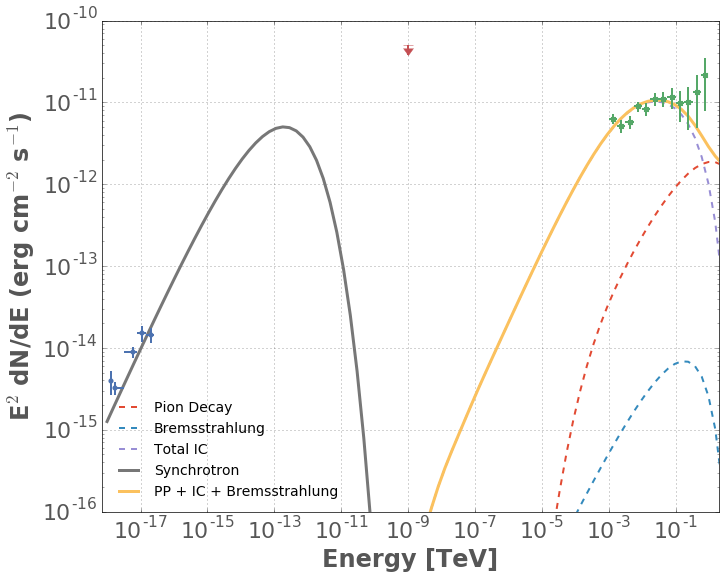

In [69]:
ncolors = plt.rcParams['axes.prop_cycle']
#Plot data + model
# * what should e_unit be? Try GeV, even though I used eV above
# * I need to figure out which param is which in the res file
# * What energy range to plot over?
# * do I not need to put emin/emax in IC?
# * add Kep
# * why is the amp / tev?
energy = np.logspace(-18, 2, 100) * u.TeV
fig = plt.figure(figsize = [10,8])

figure = naima.plot_data([G150Radio,G150_data,xray],figure = fig, e_unit=u.TeV) 
ax = figure.axes[0]

###First PP
Kep = 0.01#g150Res_ICsync_PP['median'][0]
amp_PP = g150Res_ICsyncBrems_PP['median'][1] / u.TeV
alpha = alpha = g150Res_ICsyncBrems_PP['median'][2]
e_cutoff_PP = g150Res_ICsyncBrems_PP['median'][7] * u.TeV
Wp = g150Res_ICsyncBrems_PP['median'][8]

ECPL_PP = ExponentialCutoffPowerLaw(amp_PP, 10. * u.TeV, alpha, e_cutoff_PP)

nh   = 0.00806*u.cm**-3
dist = 0.38461 * u.kpc
PP = PionDecay(ECPL_PP, nh=nh)

#Plot the computed model emission
ax.loglog(energy, PP.sed(energy, dist),
          lw=2, ls = '--',c=list(ncolors)[0]['color'], label='Pion Decay')#: n=1/cm^3, $W_p (E_p>1\, \mathrm{GeV})$ =%0.2e erg, index_ep = %0.2f, K$_{ep}$ = %0.2f' %(Wp,alpha,Kep))

###Now IC
amp_ICsync = Kep*amp_PP #10**g150Res_ICsync_PP['median'][5] / u.TeV *
e_cutoff_ICsync = g150Res_ICsyncBrems_PP['median'][5] * u.TeV
We = g150Res_ICsyncBrems_PP['median'][9]
B = g150Res_ICsyncBrems_PP['median'][3]*u.uG


ECPL_ICsync = ExponentialCutoffPowerLaw(amp_ICsync, 10. * u.TeV, alpha, e_cutoff_ICsync)

IC = InverseCompton(ECPL_ICsync,
                    seed_photon_fields=['CMB','FIR','NIR'],
                    Eemax=50 * u.PeV, Eemin=1 * u.GeV)

###And Sync
Sync = Synchrotron(ECPL_ICsync,
                    B = B,)

###Finally bremss

Bremss = Bremsstrahlung(ECPL_ICsync,n0=nh)

# Plot the computed IC and Sync model emissions
ax.loglog(energy, Bremss.sed(energy, dist),
          lw=2, ls = '--',c=list(ncolors)[1]['color'], label='Bremsstrahlung')
                   
ax.loglog(energy, IC.sed(energy, dist),
          lw=2, ls = '--',c=list(ncolors)[2]['color'], label='Total IC')#: $W_e (E_e>1\, \mathrm{GeV})$ =%0.2e erg, index_ep = %0.2f, K$_{ep}$ = %0.2f' %(We,alpha,Kep))
                   
ax.loglog(energy, Sync.sed(energy, dist),
          lw=3, c=list(ncolors)[3]['color'], label='Synchrotron')# $W_e (E_e>1\, \mathrm{GeV})$ =%0.2e erg, index_ep = %0.2f, K$_{ep}$ = %0.2f, B = %0.2f $\mathrm{\mu}$G' %(We,alpha,Kep,B.value))

###IC + PP + bresmss
#can I just sum them?
ax.loglog(energy, IC.sed(energy, dist)+PP.sed(energy, dist),
          lw=3,c=list(ncolors)[4]['color'], label='PP + IC + Bremsstrahlung')
                   
# for i, seed, ls in zip(range(4), ['CMB', 'FIR', 'NIR'], ['--', '-.', ':']):
#     ax.loglog(energy, IC.sed(energy, 2 * u.kpc, seed=seed),
#               lw=2, c=naima.plot.color_cycle[i + 1], label=seed, ls=ls)
ax.set_ylim(1e-16, 1e-10)
ax.set_xlim(7e-19,2)
ax.legend(loc='lower left', frameon=False,fontsize = 14)
figure.tight_layout()
plt.xlabel('Energy [TeV]',fontsize =24,weight='bold')


plt.ylabel(r'E$^{2}$ dN/dE (erg cm$^{-2}$ s$^{-1}$)',fontsize = 24,weight='bold')
#plt.xlabel(fontsize='large')
if not os.path.exists('G150_ICsyncBremss_PP_SED.png'):
    figure.savefig('G150_ICsyncBremss_PP_SED.png')
    figure.savefig('G150_ICsyncBremss_PP_SED.pdf')
    figure.savefig('G150_ICsyncBremss_PP_SED.eps')

# Test P-P shape
## Index

In [ ]:
ncolors = plt.rcParams['axes.prop_cycle']
#Plot data + model
# * what should e_unit be? Try GeV, even though I used eV above
# * I need to figure out which param is which in the res file
# * What energy range to plot over?
# * do I not need to put emin/emax in IC?
# * add Kep
# * why is the amp / tev?
energy = np.logspace(-18, 2, 100) * u.TeV
fig = plt.figure(figsize = [10,8])

figure = naima.plot_data([G150Radio,G150_data,xray],figure = fig, e_unit=u.TeV) 
ax = figure.axes[0]

###First PP
Kep = 0.01#g150Res_ICsync_PP['median'][0]
amp_PP = g150Res_ICsyncBrems_PP['median'][1] / u.TeV
alpha = 2#alpha = g150Res_ICsyncBrems_PP['median'][2]
e_cutoff_PP = g150Res_ICsyncBrems_PP['median'][7] * u.TeV
Wp = g150Res_ICsyncBrems_PP['median'][8]

ECPL_PP = ExponentialCutoffPowerLaw(amp_PP, 10. * u.TeV, alpha, e_cutoff_PP)

nh   = 0.00806*u.cm**-3
dist = 0.38461 * u.kpc
PP = PionDecay(ECPL_PP, nh=nh)

al = [2,1.9,1.8,1.7,1.6,1.5,g150Res_ICsyncBrems_PP['median'][2]]
#Plot the computed model emission
for ind,alpha in enumerate(al):
    ECPL_PP = ExponentialCutoffPowerLaw(amp_PP, 10. * u.TeV, alpha, e_cutoff_PP)
    PP = PionDecay(ECPL_PP, nh=nh)
    ax.loglog(energy, PP.sed(energy, dist),
              lw=2, ls = '--',c=list(ncolors)[ind]['color'], label='Pion Decay:s=%s' %(alpha))#: n=1/cm^3, $W_p (E_p>1\, \mathrm{GeV})$ =%0.2e erg, index_ep = %0.2f, K$_{ep}$ = %0.2f' %(Wp,alpha,Kep))

# alpha = 1.9
# ECPL_PP = ExponentialCutoffPowerLaw(amp_PP, 10. * u.TeV, alpha, e_cutoff_PP)
# PP = PionDecay(ECPL_PP, nh=nh)
# #Plot the computed model emission
# ax.loglog(energy, PP.sed(energy, dist),
#           lw=2, ls = '--',c=list(ncolors)[1]['color'], label='Pion Decay:s=1.9')#: n=1/cm^3, $W_p (E_p>1\, \mathrm{GeV})$ =%0.2e erg, index_ep = %0.2f, K$_{ep}$ = %0.2f' %(Wp,alpha,Kep))

# alpha = 1.8
# ECPL_PP = ExponentialCutoffPowerLaw(amp_PP, 10. * u.TeV, alpha, e_cutoff_PP)
# PP = PionDecay(ECPL_PP, nh=nh)
# #Plot the computed model emission
# ax.loglog(energy, PP.sed(energy, dist),
#           lw=2, ls = '--',c=list(ncolors)[2]['color'], label='Pion Decay:s=1.8')#: n=1/cm^3, $W_p (E_p>1\, \mathrm{GeV})$ =%0.2e erg, index_ep = %0.2f, K$_{ep}$ = %0.2f' %(Wp,alpha,Kep))

# alpha = 1.7
# ECPL_PP = ExponentialCutoffPowerLaw(amp_PP, 10. * u.TeV, alpha, e_cutoff_PP)
# PP = PionDecay(ECPL_PP, nh=nh)
# #Plot the computed model emission
# ax.loglog(energy, PP.sed(energy, dist),
#           lw=2, ls = '--',c=list(ncolors)[3]['color'], label='Pion Decay:s=1.7')#: n=1/cm^3, $W_p (E_p>1\, \mathrm{GeV})$ =%0.2e erg, index_ep = %0.2f, K$_{ep}$ = %0.2f' %(Wp,alpha,Kep))

# alpha = 1.6
# ECPL_PP = ExponentialCutoffPowerLaw(amp_PP, 10. * u.TeV, alpha, e_cutoff_PP)
# PP = PionDecay(ECPL_PP, nh=nh)
# #Plot the computed model emission
# ax.loglog(energy, PP.sed(energy, dist),
#           lw=2, ls = '--',c=list(ncolors)[4]['color'], label='Pion Decay:s=1.6')#: n=1/cm^3, $W_p (E_p>1\, \mathrm{GeV})$ =%0.2e erg, index_ep = %0.2f, K$_{ep}$ = %0.2f' %(Wp,alpha,Kep))

# alpha = 1.5
# ECPL_PP = ExponentialCutoffPowerLaw(amp_PP, 10. * u.TeV, alpha, e_cutoff_PP)
# PP = PionDecay(ECPL_PP, nh=nh)
# #Plot the computed model emission
# ax.loglog(energy, PP.sed(energy, dist),
#           lw=2, ls = '--',c=list(ncolors)[5]['color'], label='Pion Decay:s=1.5')#: n=1/cm^3, $W_p (E_p>1\, \mathrm{GeV})$ =%0.2e erg, index_ep = %0.2f, K$_{ep}$ = %0.2f' %(Wp,alpha,Kep))

# alpha = g150Res_ICsyncBrems_PP['median'][2]
# ECPL_PP = ExponentialCutoffPowerLaw(amp_PP, 10. * u.TeV, alpha, e_cutoff_PP)
# PP = PionDecay(ECPL_PP, nh=nh)
# #Plot the computed model emission
# ax.loglog(energy, PP.sed(energy, dist),
#           lw=2, ls = '--',c=list(ncolors)[6]['color'], label='Pion Decay:s=1.1')#: n=1/cm^3, $W_p (E_p>1\, \mathrm{GeV})$ =%0.2e erg, index_ep = %0.2f, K$_{ep}$ = %0.2f' %(Wp,alpha,Kep))




ax.set_ylim(1e-16, 1e-10)
ax.set_xlim(7e-19,2)
ax.legend(loc='best', frameon=False,fontsize = 14)
figure.tight_layout()
plt.title('Test Different Particle Indices',fontsize =24,weight='bold')
plt.xlabel('Energy [TeV]',fontsize =18)
plt.ylabel(r'E$^{2}$ dN/dE (erg cm$^{-2}$ s$^{-1}$)',fontsize = 24,weight='bold')


# Density

In [ ]:
ncolors = plt.rcParams['axes.prop_cycle']
#Plot data + model
# * what should e_unit be? Try GeV, even though I used eV above
# * I need to figure out which param is which in the res file
# * What energy range to plot over?
# * do I not need to put emin/emax in IC?
# * add Kep
# * why is the amp / tev?
energy = np.logspace(-18, 2, 100) * u.TeV
fig = plt.figure(figsize = [10,8])

figure = naima.plot_data([G150Radio,G150_data,xray],figure = fig, e_unit=u.TeV) 
ax = figure.axes[0]

###First PP
Kep = 0.01#g150Res_ICsync_PP['median'][0]
amp_PP = g150Res_ICsyncBrems_PP['median'][1] / u.TeV
alpha = 2#alpha = g150Res_ICsyncBrems_PP['median'][2]
e_cutoff_PP = g150Res_ICsyncBrems_PP['median'][7] * u.TeV
Wp = g150Res_ICsyncBrems_PP['median'][8]

ECPL_PP = ExponentialCutoffPowerLaw(amp_PP, 10. * u.TeV, alpha, e_cutoff_PP)

nh   = 0.00806*u.cm**-3
dist = 0.38461 * u.kpc
PP = PionDecay(ECPL_PP, nh=nh)

al = [0.00806*u.cm**-3,0.005*u.cm**-3, 0.01*u.cm**-3, 0.1*u.cm**-3]
#Plot the computed model emission
for ind,nh in enumerate(al):
    ECPL_PP = ExponentialCutoffPowerLaw(amp_PP, 10. * u.TeV, alpha, e_cutoff_PP)
    PP = PionDecay(ECPL_PP, nh=nh)
    ax.loglog(energy, PP.sed(energy, dist),
              lw=2, ls = '--',c=list(ncolors)[ind]['color'], label='Pion Decay:nh=%s' %(nh))#: n=1/cm^3, $W_p (E_p>1\, \mathrm{GeV})$ =%0.2e erg, index_ep = %0.2f, K$_{ep}$ = %0.2f' %(Wp,alpha,Kep))





ax.set_ylim(1e-16, 1e-10)
ax.set_xlim(7e-19,2)
ax.legend(loc='best', frameon=False,fontsize = 14)
figure.tight_layout()
plt.title('Test Different densities',fontsize =24,weight='bold')
plt.xlabel('Energy [TeV]',fontsize =18)
plt.ylabel(r'E$^{2}$ dN/dE (erg cm$^{-2}$ s$^{-1}$)',fontsize = 24,weight='bold')


# Amp_PP

In [ ]:
ncolors = plt.rcParams['axes.prop_cycle']
#Plot data + model
# * what should e_unit be? Try GeV, even though I used eV above
# * I need to figure out which param is which in the res file
# * What energy range to plot over?
# * do I not need to put emin/emax in IC?
# * add Kep
# * why is the amp / tev?
energy = np.logspace(-18, 2, 100) * u.TeV
fig = plt.figure(figsize = [10,8])

figure = naima.plot_data([G150Radio,G150_data,xray],figure = fig, e_unit=u.TeV) 
ax = figure.axes[0]

###First PP
Kep = 0.01#g150Res_ICsync_PP['median'][0]
amp_PP = g150Res_ICsyncBrems_PP['median'][1] / u.TeV
alpha = 2#alpha = g150Res_ICsyncBrems_PP['median'][2]
e_cutoff_PP = g150Res_ICsyncBrems_PP['median'][7] * u.TeV
Wp = g150Res_ICsyncBrems_PP['median'][8]

ECPL_PP = ExponentialCutoffPowerLaw(amp_PP, 10. * u.TeV, alpha, e_cutoff_PP)

nh   = 0.00806*u.cm**-3
dist = 0.38461 * u.kpc
PP = PionDecay(ECPL_PP, nh=nh)

al = [g150Res_ICsyncBrems_PP['median'][1] / u.TeV, (g150Res_ICsyncBrems_PP['median'][1] / u.TeV)/10, (g150Res_ICsyncBrems_PP['median'][1] / u.TeV)*10]
#Plot the computed model emission
for ind,amp_PP in enumerate(al):
    ECPL_PP = ExponentialCutoffPowerLaw(amp_PP, 10. * u.TeV, alpha, e_cutoff_PP)
    PP = PionDecay(ECPL_PP, nh=nh)
    ax.loglog(energy, PP.sed(energy, dist),
              lw=2, ls = '--',c=list(ncolors)[ind]['color'], label='Pion Decay:Amp_PP=%s' %(amp_PP))#: n=1/cm^3, $W_p (E_p>1\, \mathrm{GeV})$ =%0.2e erg, index_ep = %0.2f, K$_{ep}$ = %0.2f' %(Wp,alpha,Kep))





ax.set_ylim(1e-16, 1e-10)
ax.set_xlim(7e-19,2)
ax.legend(loc='best', frameon=False,fontsize = 14)
figure.tight_layout()
plt.title('Test Different Amp_PP',fontsize =24,weight='bold')
plt.xlabel('Energy [TeV]',fontsize =18)
plt.ylabel(r'E$^{2}$ dN/dE (erg cm$^{-2}$ s$^{-1}$)',fontsize = 24,weight='bold')


# E_cutoff_p

In [ ]:
ncolors = plt.rcParams['axes.prop_cycle']
#Plot data + model
# * what should e_unit be? Try GeV, even though I used eV above
# * I need to figure out which param is which in the res file
# * What energy range to plot over?
# * do I not need to put emin/emax in IC?
# * add Kep
# * why is the amp / tev?
energy = np.logspace(-18, 2, 100) * u.TeV
fig = plt.figure(figsize = [10,8])

figure = naima.plot_data([G150Radio,G150_data,xray],figure = fig, e_unit=u.TeV) 
ax = figure.axes[0]

###First PP
Kep = 0.01#g150Res_ICsync_PP['median'][0]
amp_PP = g150Res_ICsyncBrems_PP['median'][1] / u.TeV
alpha = 2#alpha = g150Res_ICsyncBrems_PP['median'][2]
e_cutoff_PP = g150Res_ICsyncBrems_PP['median'][7] * u.TeV
Wp = g150Res_ICsyncBrems_PP['median'][8]

ECPL_PP = ExponentialCutoffPowerLaw(amp_PP, 10. * u.TeV, alpha, e_cutoff_PP)

nh   = 0.00806*u.cm**-3
dist = 0.38461 * u.kpc
PP = PionDecay(ECPL_PP, nh=nh)

al = [g150Res_ICsyncBrems_PP['median'][7] * u.TeV, (g150Res_ICsyncBrems_PP['median'][7] * u.TeV )/10, (g150Res_ICsyncBrems_PP['median'][7] * u.TeV )*10, 300*u.TeV, 400*u.TeV, 500*u.TeV, 1000*u.TeV]
#Plot the computed model emission
for ind, e_cutoff_PP in enumerate(al):
    ECPL_PP = ExponentialCutoffPowerLaw(amp_PP, 10. * u.TeV, alpha, e_cutoff_PP)
    PP = PionDecay(ECPL_PP, nh=nh)
    ax.loglog(energy, PP.sed(energy, dist),
              lw=2, ls = '--',c=list(ncolors)[ind]['color'], label='Pion Decay:e_cutoff_PP=%s' %(e_cutoff_PP))#: n=1/cm^3, $W_p (E_p>1\, \mathrm{GeV})$ =%0.2e erg, index_ep = %0.2f, K$_{ep}$ = %0.2f' %(Wp,alpha,Kep))





ax.set_ylim(1e-16, 1e-10)
ax.set_xlim(7e-19,100)
ax.legend(loc='best', frameon=False,fontsize = 14)
figure.tight_layout()
plt.title('Test Different e_cutoff_PP',fontsize =24,weight='bold')
plt.xlabel('Energy [TeV]',fontsize =18)
plt.ylabel(r'E$^{2}$ dN/dE (erg cm$^{-2}$ s$^{-1}$)',fontsize = 24,weight='bold')


# Determine value to fix particle index to

In [ ]:
#radio --> particle (from synchrotron physics)
def sr(al):
    """for negaitve index alpha"""
    if not al < 0:
        al = -al
    return (1-2*al)
#gamma to radio
def alPP(gam):
    "radio index from bremss/PP "

def alIC(gam):
    """radio index from IC gam below break"""

###Is gamma = s for bremss? See reynolds 08
###Castro 10 says expected IC: gam = 1.5, 
###I think  for PP; gam = 2 for test particle


In [ ]:
print 's = %s'%s(0.5)

## Use s=  2 (PP test partcle), 1.5 (standard IC below break), Fit gam = 1.8
### it always fits low
### do for Kep = 1, 0.01, n = near value? or near and 0.1.
#### the prob with 0.1 is that idk what distance to really use because this is likely wrong
#### just go backards and get the dist assuming n?
##### this dist is really close. How does this equation ever work?!?!
### so 6

# runs 
## s= 2, Kep = 1, is it weird to do this if 1 is lep dom?
## s= 2, Kep = 0.01
## s= 1.5, Kep = 1
## s= 1.5, Kep = 0.01, is it weird to do this if 0.01 is had dom?
## s = 1.82 Kep = 1
## s = 1.82 Kep = 0.01

# 11. IC+PP+Bremss+Sync, radio + GeV + X-ray. Fit s, Ap, E_Cut_p,  E_Cut_e. Don't fit Kep, use xray emitting density upper lim

# fixed s runs
## s =2
## Kep = 1
## E_Cut_p: <= 100 TeV

In [61]:
indDir = os.path.join(tDir,'fixedIndex')
if not os.path.exists(indDir):
    os.mkdir(indDir)
dirN= os.path.join(tDir,'fixedIndex/IC_Sync_bremss_PP_wRadio_Xray_nrun20_Kep1_s2')
if not os.path.exists(dirN):
    os.mkdir(dirN)
os.chdir(dirN)
%pwd

u'/Users/elunejava/Desktop/naimaTest/fixedIndex/IC_Sync_bremss_PP_wRadio_Xray_nrun20_Kep1_s2'

In [62]:
#I think i shouldn't be using the same particle distribution for pp and IC
#since the normalization (number of e-/p or We/Wp) should be different 
#But I might expect to have the same index for both
#If I do, I don't know that I can tie the indicies for two seperate particle distributions in naima
#I likely can with sherpa though

#For now, just use two different particle pops with all different params, start with the same p0 for both
def IC_PP_Syn_Bremss_Mod(pars, data):
    """Decide between PL or ECPL model based on number
       of params in pars. Set up pp Pion Decay and e- IC models"""
    
    #params not to fit
    pp_peMin = 1 * u.GeV
    ic_sync_eeMin = 1 * u.GeV
    nh = 0.00806 / u.cm**3
    sd_ph = ['CMB','FIR','NIR']
    dist = 0.38461 *u.kpc
    alpha = 2
    kep = 1 #value measured at Earth
    
    #p0 = np.array((norm_ic,norm_pp,cutoff_ic,cutoff_pp)) ###for ECPL, if PL, remove both cutoffs
    #norm_ICsync = 10**pars[0] / u.TeV
    norm_PP = 10**pars[0] / u.TeV
    norm_ICsync = kep*norm_PP
    B = pars[1] * u.uG
    

    #Instantiate particle distributions for IC and PP
    if len(pars) == 2:
        #print 'Particle distribution model is PL'
        pMod_ICsync = PowerLaw(norm_ICsync, 10. * u.TeV, alpha)
        pMod_PP = PowerLaw(norm_PP, 10. * u.TeV, alpha)
        
    elif len(pars) == 4:
        #print 'Particle distribution model is ECPL'
        e_cutoff_ICsync = (10**pars[2]) * u.TeV
        pMod_ICsync = ExponentialCutoffPowerLaw(norm_ICsync, 10. * u.TeV, alpha, e_cutoff_ICsync)
        e_cutoff_PP = (10**pars[3]) * u.TeV
        pMod_PP = ExponentialCutoffPowerLaw(norm_PP, 10. * u.TeV, alpha, e_cutoff_PP)
    else:
        raise Exception('Wrong number of params input for PL or ECPL')
        
            
    #instantiate IC models
    PP = PionDecay(pMod_PP, nh=nh)
        
    #instantiate IC models
    IC = InverseCompton(pMod_ICsync,
                        seed_photon_fields=sd_ph,
                        Eemin=ic_sync_eeMin)
    #instantiate Sync models
    SYN = Synchrotron(pMod_ICsync, B=B)
    
    Brem = Bremsstrahlung(pMod_ICsync, n0 = nh)
    
    #calculate PP + IC flux at energies of data
    model = (IC.flux(data, distance=dist) +
             PP.flux(data, distance=dist) +
             SYN.flux(data,distance=dist) +
             Brem.flux(data,distance=dist))
    
    # Save this realization of the particle distribution function
    particle_energy = np.logspace(-3, 2, 50) * u.TeV
    nelec = pMod_ICsync(particle_energy)
    proton_dist = PP.particle_distribution(particle_energy) ###is PP.particle_distribution the same as pMod(energy?)

    # Compute the total energy in protons/electrons above 1 GeV for this realization
    # Is it fine to calc We using either IC or sycn? Should be the same since it's the same population?
    # or do I need to compute for both a sum?
    
    Wp = PP.compute_Wp(Epmin=pp_peMin)
    We = IC.compute_We(Eemin=ic_sync_eeMin)#1 * u.TeV)

    # Return the model, proton distribution and energy in protons to be stored
    # in metadata blobs
    return model, (particle_energy, proton_dist), Wp, (particle_energy, nelec), We

def lnprior_ICsyncBremss_PP(pars):
    """
    Return probability of parameter values according to prior knowledge.
    Parameter. Include norm_ICsync, norm_PP, index. Not cutoffs (why not?)
    normP, index, B
    Is the only reson to include a param in the prior here to limit the range of values?
    for Kep (par[0]) max=1, min set to something small and not 0
        """

    logprob =  naima.uniform_prior(pars[0],0., np.inf)           \
                    + naima.uniform_prior(pars[1], 0.1, 500)     \
                    + naima.uniform_prior(pars[2], np.log10(0.001), np.log10(100)) \
                    + naima.uniform_prior(pars[3], np.log10(0.001), np.log10(100))

    return logprob

#(10**pars[4]) * u.TeV


In [ ]:
#B: 3 : i know a few muG is the typicl ISM value, and typical of many SNR, but crab has ~200-300

#p0 = np.arra((norm_ic,cutoff_ic,norm_pp,cutoff_pp))
p0 = np.array((44, 3., np.log10(0.5),np.log10(5))) #start with same params for each, not sure this is best to do

##try this after running and maybe failing?
#p0 = np.array((31.1, 43.9,1.98,np.log10(49),np.log10(49)))
if len(p0) == 2:
    labels = ['log10(norm_PP)', 'B']
elif len(p0) ==4:
    labels = ['log10(norm_PP)', 'B','log10(cutoff_IC)','log10(cutoff_PP)']
    
## Run sampler
##change from nrun = 20 to 400
## double the number of walkers as well
##should I change the number of walkers as well?
## The reason to increase the number is to ensure that the sampling is stable and converges
##maybe having the number so was why the distributions looked funny, can't build it up with so few runs?

#original:nwalkers =32, nburn = 100 , nrun = 20
#high = nwalkers =63, nburn = 100 , nrun = 400
sampler, pos = naima.run_sampler(data_table=[G150Radio,G150_data,xray],
                                 p0=p0,
                                 labels=labels,
                                 model=IC_PP_Syn_Bremss_Mod,
                                 prior=lnprior_ICsyncBremss_PP,
                                 nwalkers=32,
                                 nburn=100,
                                 nrun=20,
                                 threads=4,
                                 prefit=True,
                                 interactive = False)

## Save run results to HDF5 file (can be read later with naima.read_run)
naima.save_run('G150_ICsyncBremss_PP_wRadio_Xray_Kep1_s2.hdf5', sampler)

## Diagnostic plots with labels for the metadata blobs
naima.save_diagnostic_plots('G150_ICsyncBremss_PP_wRadio_Xray_Kep1_s2',
                            sampler,
                            sed=True,
                            last_step=False,
                            blob_labels=['Proton Spectrum', 'Proton Energy Distribution',
                                         '$W_p (E_p>1\, \mathrm{GeV})$',
                                         'Electron Spectrum', 'Electron Energy Distribution',
                                         '$W_e (E_e>1\, \mathrm{GeV})$'])
naima.save_results_table('G150_ICsyncBremss_PP_wRadio_Xray_Kep1_s2', sampler)


In [63]:
#Read in data, see what it looks like
g150Res_ICsyncBrems_PP = ascii.read('G150_ICsyncBremss_PP_wRadio_Xray_Kep1_s2_results.ecsv')
g150Res_ICsyncBrems_PP

label,median,unc_lo,unc_hi
str16,float64,float64,float64
log10(norm_PP),41.674352657,0.130394907081,0.0944878969827
norm_PP,4.72446522824e+41,1.22535398381e+41,1.14827238688e+41
B,19.7169180883,4.25775687762,6.17703613884
log10(cutoff_IC),1.00689130075,0.767109896412,0.449701221768
cutoff_IC,10.1599475759,8.42257865657,18.454971531
log10(cutoff_PP),0.541594655902,1.24785580724,1.03879025935
cutoff_PP,3.48104907443,3.28437874346,34.5810259888
blob2,5.46630284573e+44,2.56247699303e+44,2.50351006343e+44
blob4,6.44740134229e+44,2.16014292371e+44,2.13921295285e+44


In [64]:
for ind, nam in enumerate(g150Res_ICsyncBrems_PP):
    print ind, nam['label'],nam['median']

0 log10(norm_PP) 41.674352657
1 norm_PP 4.72446522824e+41
2 B 19.7169180883
3 log10(cutoff_IC) 1.00689130075
4 cutoff_IC 10.1599475759
5 log10(cutoff_PP) 0.541594655902
6 cutoff_PP 3.48104907443
7 blob2 5.46630284573e+44
8 blob4 6.44740134229e+44


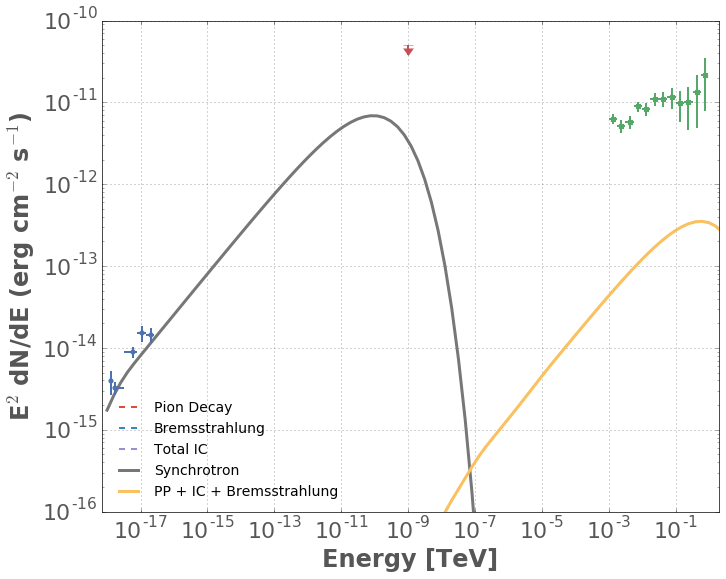

In [65]:
ncolors = plt.rcParams['axes.prop_cycle']
#Plot data + model
# * what should e_unit be? Try GeV, even though I used eV above
# * I need to figure out which param is which in the res file
# * What energy range to plot over?
# * do I not need to put emin/emax in IC?
# * add Kep
# * why is the amp / tev?
energy = np.logspace(-18, 2, 100) * u.TeV
fig = plt.figure(figsize = [10,8])

figure = naima.plot_data([G150Radio,G150_data,xray],figure = fig, e_unit=u.TeV) 
ax = figure.axes[0]

###First PP
alpha = 2
Kep = 1
amp_PP = g150Res_ICsyncBrems_PP['median'][1] / u.TeV
e_cutoff_PP = g150Res_ICsyncBrems_PP['median'][6] * u.TeV
Wp = g150Res_ICsyncBrems_PP['median'][7]

ECPL_PP = ExponentialCutoffPowerLaw(amp_PP, 10. * u.TeV, alpha, e_cutoff_PP)

nh   = 0.00806*u.cm**-3
dist = 0.38461*u.kpc
PP = PionDecay(ECPL_PP, nh=nh)

#Plot the computed model emission
ax.loglog(energy, PP.sed(energy, dist),
          lw=2, ls = '--',c=list(ncolors)[0]['color'], label='Pion Decay')#: n=1/cm^3, $W_p (E_p>1\, \mathrm{GeV})$ =%0.2e erg, index_ep = %0.2f, K$_{ep}$ = %0.2f' %(Wp,alpha,Kep))

###Now IC
amp_ICsync = Kep*amp_PP #10**g150Res_ICsync_PP['median'][5] / u.TeV *
e_cutoff_ICsync = g150Res_ICsyncBrems_PP['median'][4] * u.TeV
We = g150Res_ICsyncBrems_PP['median'][8]
B = g150Res_ICsyncBrems_PP['median'][2]*u.uG


ECPL_ICsync = ExponentialCutoffPowerLaw(amp_ICsync, 10. * u.TeV, alpha, e_cutoff_ICsync)

IC = InverseCompton(ECPL_ICsync,
                    seed_photon_fields=['CMB','FIR','NIR'],
                    Eemax=50 * u.PeV, Eemin=1 * u.GeV)

###And Sync
Sync = Synchrotron(ECPL_ICsync,
                    B = B,)

###Finally bremss

Bremss = Bremsstrahlung(ECPL_ICsync,n0=nh)

# Plot the computed IC and Sync model emissions
ax.loglog(energy, Bremss.sed(energy, dist),
          lw=2, ls = '--',c=list(ncolors)[1]['color'], label='Bremsstrahlung')
                   
ax.loglog(energy, IC.sed(energy, dist),
          lw=2, ls = '--',c=list(ncolors)[2]['color'], label='Total IC')#: $W_e (E_e>1\, \mathrm{GeV})$ =%0.2e erg, index_ep = %0.2f, K$_{ep}$ = %0.2f' %(We,alpha,Kep))
                   
ax.loglog(energy, Sync.sed(energy, dist),
          lw=3, c=list(ncolors)[3]['color'], label='Synchrotron')# $W_e (E_e>1\, \mathrm{GeV})$ =%0.2e erg, index_ep = %0.2f, K$_{ep}$ = %0.2f, B = %0.2f $\mathrm{\mu}$G' %(We,alpha,Kep,B.value))

###IC + PP + bresmss
#can I just sum them?
ax.loglog(energy, IC.sed(energy, dist)+PP.sed(energy, dist),
          lw=3,c=list(ncolors)[4]['color'], label='PP + IC + Bremsstrahlung')
                   
# for i, seed, ls in zip(range(4), ['CMB', 'FIR', 'NIR'], ['--', '-.', ':']):
#     ax.loglog(energy, IC.sed(energy, 2 * u.kpc, seed=seed),
#               lw=2, c=naima.plot.color_cycle[i + 1], label=seed, ls=ls)
ax.set_ylim(1e-16, 1e-10)
ax.set_xlim(7e-19,2)
ax.legend(loc='lower left', frameon=False,fontsize = 14)
figure.tight_layout()
plt.xlabel('Energy [TeV]',fontsize =24,weight='bold')


plt.ylabel(r'E$^{2}$ dN/dE (erg cm$^{-2}$ s$^{-1}$)',fontsize = 24,weight='bold')
#plt.xlabel(fontsize='large')
if not os.path.exists('G150_ICsyncBremss_PP_SED_Kep1_s2.png'):
    figure.savefig('G150_ICsyncBremss_PP_SED_Kep1_s2.png')
    figure.savefig('G150_ICsyncBremss_PP_SED_Kep1_s2.pdf')
    figure.savefig('G150_ICsyncBremss_PP_SED_Kep1_s2.eps')

# 12. IC+PP+Bremss+Sync, radio + GeV + X-ray. Fit s, Ap, E_Cut_p,  E_Cut_e. Don't fit Kep, use xray emitting density upper lim

# fixed s runs
## s =2
## Kep = 0.01
## E_Cut_p: <= 100 TeV

In [56]:
dirN= os.path.join(tDir,'fixedIndex/IC_Sync_bremss_PP_wRadio_Xray_nrun20_Kep001_s2')
if not os.path.exists(dirN):
    os.mkdir(dirN)
os.chdir(dirN)
%pwd

u'/Users/elunejava/Desktop/naimaTest/fixedIndex/IC_Sync_bremss_PP_wRadio_Xray_nrun20_Kep001_s2'

In [57]:
#I think i shouldn't be using the same particle distribution for pp and IC
#since the normalization (number of e-/p or We/Wp) should be different 
#But I might expect to have the same index for both
#If I do, I don't know that I can tie the indicies for two seperate particle distributions in naima
#I likely can with sherpa though

#For now, just use two different particle pops with all different params, start with the same p0 for both
def IC_PP_Syn_Bremss_Mod(pars, data):
    """Decide between PL or ECPL model based on number
       of params in pars. Set up pp Pion Decay and e- IC models"""
    
    #params not to fit
    pp_peMin = 1 * u.GeV
    ic_sync_eeMin = 1 * u.GeV
    nh = 0.00806 / u.cm**3
    sd_ph = ['CMB','FIR','NIR']
    dist = 0.38461 *u.kpc
    alpha = 2
    kep = 0.01 #value measured at Earth
    
    #p0 = np.array((norm_ic,norm_pp,cutoff_ic,cutoff_pp)) ###for ECPL, if PL, remove both cutoffs
    #norm_ICsync = 10**pars[0] / u.TeV
    norm_PP = 10**pars[0] / u.TeV
    norm_ICsync = kep*norm_PP
    B = pars[1] * u.uG
    

    #Instantiate particle distributions for IC and PP
    if len(pars) == 2:
        #print 'Particle distribution model is PL'
        pMod_ICsync = PowerLaw(norm_ICsync, 10. * u.TeV, alpha)
        pMod_PP = PowerLaw(norm_PP, 10. * u.TeV, alpha)
        
    elif len(pars) == 4:
        #print 'Particle distribution model is ECPL'
        e_cutoff_ICsync = (10**pars[2]) * u.TeV
        pMod_ICsync = ExponentialCutoffPowerLaw(norm_ICsync, 10. * u.TeV, alpha, e_cutoff_ICsync)
        e_cutoff_PP = (10**pars[3]) * u.TeV
        pMod_PP = ExponentialCutoffPowerLaw(norm_PP, 10. * u.TeV, alpha, e_cutoff_PP)
    else:
        raise Exception('Wrong number of params input for PL or ECPL')
        
            
    #instantiate IC models
    PP = PionDecay(pMod_PP, nh=nh)
        
    #instantiate IC models
    IC = InverseCompton(pMod_ICsync,
                        seed_photon_fields=sd_ph,
                        Eemin=ic_sync_eeMin)
    #instantiate Sync models
    SYN = Synchrotron(pMod_ICsync, B=B)
    
    Brem = Bremsstrahlung(pMod_ICsync, n0 = nh)
    
    #calculate PP + IC flux at energies of data
    model = (IC.flux(data, distance=dist) +
             PP.flux(data, distance=dist) +
             SYN.flux(data,distance=dist) +
             Brem.flux(data,distance=dist))
    
    # Save this realization of the particle distribution function
    particle_energy = np.logspace(-3, 2, 50) * u.TeV
    nelec = pMod_ICsync(particle_energy)
    proton_dist = PP.particle_distribution(particle_energy) ###is PP.particle_distribution the same as pMod(energy?)

    # Compute the total energy in protons/electrons above 1 GeV for this realization
    # Is it fine to calc We using either IC or sycn? Should be the same since it's the same population?
    # or do I need to compute for both a sum?
    
    Wp = PP.compute_Wp(Epmin=pp_peMin)
    We = IC.compute_We(Eemin=ic_sync_eeMin)#1 * u.TeV)

    # Return the model, proton distribution and energy in protons to be stored
    # in metadata blobs
    return model, (particle_energy, proton_dist), Wp, (particle_energy, nelec), We

def lnprior_ICsyncBremss_PP(pars):
    """
    Return probability of parameter values according to prior knowledge.
    Parameter. Include norm_ICsync, norm_PP, index. Not cutoffs (why not?)
    normP, index, B
    Is the only reson to include a param in the prior here to limit the range of values?
    for Kep (par[0]) max=1, min set to something small and not 0
        """

    logprob =  naima.uniform_prior(pars[0],0., np.inf)           \
                    + naima.uniform_prior(pars[1], 0.1, 500)     \
                    + naima.uniform_prior(pars[2], np.log10(0.001), np.log10(100)) \
                    + naima.uniform_prior(pars[3], np.log10(0.001), np.log10(100))

    return logprob

#(10**pars[4]) * u.TeV


In [ ]:
#B: 3 : i know a few muG is the typicl ISM value, and typical of many SNR, but crab has ~200-300

#p0 = np.arra((norm_ic,cutoff_ic,norm_pp,cutoff_pp))
p0 = np.array((44, 3., np.log10(0.5),np.log10(5))) #start with same params for each, not sure this is best to do

##try this after running and maybe failing?
#p0 = np.array((31.1, 43.9,1.98,np.log10(49),np.log10(49)))
if len(p0) == 2:
    labels = ['log10(norm_PP)', 'B']
elif len(p0) ==4:
    labels = ['log10(norm_PP)', 'B','log10(cutoff_IC)','log10(cutoff_PP)']
    
## Run sampler
##change from nrun = 20 to 400
## double the number of walkers as well
##should I change the number of walkers as well?
## The reason to increase the number is to ensure that the sampling is stable and converges
##maybe having the number so was why the distributions looked funny, can't build it up with so few runs?

#original:nwalkers =32, nburn = 100 , nrun = 20
#high = nwalkers =63, nburn = 100 , nrun = 400
sampler, pos = naima.run_sampler(data_table=[G150Radio,G150_data,xray],
                                 p0=p0,
                                 labels=labels,
                                 model=IC_PP_Syn_Bremss_Mod,
                                 prior=lnprior_ICsyncBremss_PP,
                                 nwalkers=32,
                                 nburn=100,
                                 nrun=20,
                                 threads=4,
                                 prefit=True,
                                 interactive = False)

## Save run results to HDF5 file (can be read later with naima.read_run)
naima.save_run('G150_ICsyncBremss_PP_wRadio_Xray_Kep001_s2.hdf5', sampler)

## Diagnostic plots with labels for the metadata blobs
naima.save_diagnostic_plots('G150_ICsyncBremss_PP_wRadio_Xray_Kep001_s2',
                            sampler,
                            sed=True,
                            last_step=False,
                            blob_labels=['Proton Spectrum', 'Proton Energy Distribution',
                                         '$W_p (E_p>1\, \mathrm{GeV})$',
                                         'Electron Spectrum', 'Electron Energy Distribution',
                                         '$W_e (E_e>1\, \mathrm{GeV})$'])
naima.save_results_table('G150_ICsyncBremss_PP_wRadio_Xray_Kep001_s2', sampler)


In [58]:
#Read in data, see what it looks like
g150Res_ICsyncBrems_PP = ascii.read('G150_ICsyncBremss_PP_wRadio_Xray_Kep001_s2_results.ecsv')
g150Res_ICsyncBrems_PP

label,median,unc_lo,unc_hi
str16,float64,float64,float64
log10(norm_PP),43.507707252,0.182917925739,0.138742501174
norm_PP,3.2188989972e+43,1.10643495013e+43,1.21158378594e+43
B,29.5278449503,5.61650909264,12.4212110702
log10(cutoff_IC),0.797477817673,0.740214764475,0.671473488928
cutoff_IC,6.27303654569,5.13209589692,23.1932054281
log10(cutoff_PP),-0.844627400754,1.55031603654,1.78630529318
cutoff_PP,0.14302619688,0.138998502002,8.60308843233
blob2,2.20895336599e+46,1.70756865489e+46,2.15808546787e+46
blob4,4.13309333367e+44,1.7998577329e+44,2.4303505082e+44


In [59]:
for ind, nam in enumerate(g150Res_ICsyncBrems_PP):
    print ind, nam['label'],nam['median']

0 log10(norm_PP) 43.507707252
1 norm_PP 3.2188989972e+43
2 B 29.5278449503
3 log10(cutoff_IC) 0.797477817673
4 cutoff_IC 6.27303654569
5 log10(cutoff_PP) -0.844627400754
6 cutoff_PP 0.14302619688
7 blob2 2.20895336599e+46
8 blob4 4.13309333367e+44


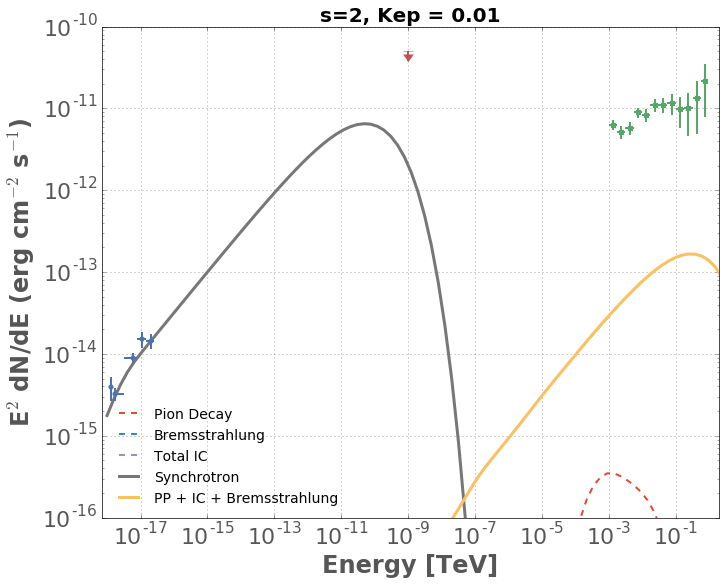

In [60]:
ncolors = plt.rcParams['axes.prop_cycle']
#Plot data + model
# * what should e_unit be? Try GeV, even though I used eV above
# * I need to figure out which param is which in the res file
# * What energy range to plot over?
# * do I not need to put emin/emax in IC?
# * add Kep
# * why is the amp / tev?
energy = np.logspace(-18, 2, 100) * u.TeV
fig = plt.figure(figsize = [10,8])

figure = naima.plot_data([G150Radio,G150_data,xray],figure = fig, e_unit=u.TeV) 
ax = figure.axes[0]

###First PP
alpha = 2
Kep = 0.01
amp_PP = g150Res_ICsyncBrems_PP['median'][1] / u.TeV
e_cutoff_PP = g150Res_ICsyncBrems_PP['median'][6] * u.TeV
Wp = g150Res_ICsyncBrems_PP['median'][7]

ECPL_PP = ExponentialCutoffPowerLaw(amp_PP, 10. * u.TeV, alpha, e_cutoff_PP)

nh   = 0.00806*u.cm**-3
dist = 0.38461*u.kpc
PP = PionDecay(ECPL_PP, nh=nh)

#Plot the computed model emission
ax.loglog(energy, PP.sed(energy, dist),
          lw=2, ls = '--',c=list(ncolors)[0]['color'], label='Pion Decay')#: n=1/cm^3, $W_p (E_p>1\, \mathrm{GeV})$ =%0.2e erg, index_ep = %0.2f, K$_{ep}$ = %0.2f' %(Wp,alpha,Kep))

###Now IC
amp_ICsync = Kep*amp_PP #10**g150Res_ICsync_PP['median'][5] / u.TeV *
e_cutoff_ICsync = g150Res_ICsyncBrems_PP['median'][4] * u.TeV
We = g150Res_ICsyncBrems_PP['median'][8]
B = g150Res_ICsyncBrems_PP['median'][2]*u.uG


ECPL_ICsync = ExponentialCutoffPowerLaw(amp_ICsync, 10. * u.TeV, alpha, e_cutoff_ICsync)

IC = InverseCompton(ECPL_ICsync,
                    seed_photon_fields=['CMB','FIR','NIR'],
                    Eemax=50 * u.PeV, Eemin=1 * u.GeV)

###And Sync
Sync = Synchrotron(ECPL_ICsync,
                    B = B,)

###Finally bremss

Bremss = Bremsstrahlung(ECPL_ICsync,n0=nh)

# Plot the computed IC and Sync model emissions
ax.loglog(energy, Bremss.sed(energy, dist),
          lw=2, ls = '--',c=list(ncolors)[1]['color'], label='Bremsstrahlung')
                   
ax.loglog(energy, IC.sed(energy, dist),
          lw=2, ls = '--',c=list(ncolors)[2]['color'], label='Total IC')#: $W_e (E_e>1\, \mathrm{GeV})$ =%0.2e erg, index_ep = %0.2f, K$_{ep}$ = %0.2f' %(We,alpha,Kep))
                   
ax.loglog(energy, Sync.sed(energy, dist),
          lw=3, c=list(ncolors)[3]['color'], label='Synchrotron')# $W_e (E_e>1\, \mathrm{GeV})$ =%0.2e erg, index_ep = %0.2f, K$_{ep}$ = %0.2f, B = %0.2f $\mathrm{\mu}$G' %(We,alpha,Kep,B.value))

###IC + PP + bresmss
#can I just sum them?
ax.loglog(energy, IC.sed(energy, dist)+PP.sed(energy, dist),
          lw=3,c=list(ncolors)[4]['color'], label='PP + IC + Bremsstrahlung')
                   
# for i, seed, ls in zip(range(4), ['CMB', 'FIR', 'NIR'], ['--', '-.', ':']):
#     ax.loglog(energy, IC.sed(energy, 2 * u.kpc, seed=seed),
#               lw=2, c=naima.plot.color_cycle[i + 1], label=seed, ls=ls)
ax.set_ylim(1e-16, 1e-10)
ax.set_xlim(7e-19,2)
ax.legend(loc='lower left', frameon=False,fontsize = 14)
figure.tight_layout()
plt.xlabel('Energy [TeV]',fontsize =24,weight='bold')


plt.ylabel(r'E$^{2}$ dN/dE (erg cm$^{-2}$ s$^{-1}$)',fontsize = 24,weight='bold')
plt.title('s=2, Kep = 0.01',fontsize = 20,weight='bold')
#plt.xlabel(fontsize='large')
if not os.path.exists('G150_ICsyncBremss_PP_SED_Kep001_s2.png'):
    figure.savefig('G150_ICsyncBremss_PP_SED_Kep001_s2.png')
    figure.savefig('G150_ICsyncBremss_PP_SED_Kep001_s2.pdf')
    figure.savefig('G150_ICsyncBremss_PP_SED_Kep001_s2.eps')

In [ ]:
print amp_PP, e_cutoff_PP, Wp
print amp_ICsync , e_cutoff_ICsync , We , B 

# 13. IC+PP+Bremss+Sync, radio + GeV + X-ray. Fit s, Ap, E_Cut_p,  E_Cut_e. Don't fit Kep, use xray emitting density upper lim

# fixed s runs
## s =1.5
## Kep = 1
## E_Cut_p: <= 100 TeV

In [50]:
dirN= os.path.join(tDir,'fixedIndex/IC_Sync_bremss_PP_wRadio_Xray_nrun20_Kep1_s15')
if not os.path.exists(dirN):
    os.mkdir(dirN)
os.chdir(dirN)
%pwd

u'/Users/elunejava/Desktop/naimaTest/fixedIndex/IC_Sync_bremss_PP_wRadio_Xray_nrun20_Kep1_s15'

In [54]:
#I think i shouldn't be using the same particle distribution for pp and IC
#since the normalization (number of e-/p or We/Wp) should be different 
#But I might expect to have the same index for both
#If I do, I don't know that I can tie the indicies for two seperate particle distributions in naima
#I likely can with sherpa though

#For now, just use two different particle pops with all different params, start with the same p0 for both
def IC_PP_Syn_Bremss_Mod(pars, data):
    """Decide between PL or ECPL model based on number
       of params in pars. Set up pp Pion Decay and e- IC models"""
    
    #params not to fit
    pp_peMin = 1 * u.GeV
    ic_sync_eeMin = 1 * u.GeV
    nh = 0.00806 / u.cm**3
    sd_ph = ['CMB','FIR','NIR']
    dist = 0.38461 *u.kpc
    alpha = 1.5
    kep = 1 #value measured at Earth
    
    #p0 = np.array((norm_ic,norm_pp,cutoff_ic,cutoff_pp)) ###for ECPL, if PL, remove both cutoffs
    #norm_ICsync = 10**pars[0] / u.TeV
    norm_PP = 10**pars[0] / u.TeV
    norm_ICsync = kep*norm_PP
    B = pars[1] * u.uG
    

    #Instantiate particle distributions for IC and PP
    if len(pars) == 2:
        #print 'Particle distribution model is PL'
        pMod_ICsync = PowerLaw(norm_ICsync, 10. * u.TeV, alpha)
        pMod_PP = PowerLaw(norm_PP, 10. * u.TeV, alpha)
        
    elif len(pars) == 4:
        #print 'Particle distribution model is ECPL'
        e_cutoff_ICsync = (10**pars[2]) * u.TeV
        pMod_ICsync = ExponentialCutoffPowerLaw(norm_ICsync, 10. * u.TeV, alpha, e_cutoff_ICsync)
        e_cutoff_PP = (10**pars[3]) * u.TeV
        pMod_PP = ExponentialCutoffPowerLaw(norm_PP, 10. * u.TeV, alpha, e_cutoff_PP)
    else:
        raise Exception('Wrong number of params input for PL or ECPL')
        
            
    #instantiate IC models
    PP = PionDecay(pMod_PP, nh=nh)
        
    #instantiate IC models
    IC = InverseCompton(pMod_ICsync,
                        seed_photon_fields=sd_ph,
                        Eemin=ic_sync_eeMin)
    #instantiate Sync models
    SYN = Synchrotron(pMod_ICsync, B=B)
    
    Brem = Bremsstrahlung(pMod_ICsync, n0 = nh)
    
    #calculate PP + IC flux at energies of data
    model = (IC.flux(data, distance=dist) +
             PP.flux(data, distance=dist) +
             SYN.flux(data,distance=dist) +
             Brem.flux(data,distance=dist))
    
    # Save this realization of the particle distribution function
    particle_energy = np.logspace(-3, 2, 50) * u.TeV
    nelec = pMod_ICsync(particle_energy)
    proton_dist = PP.particle_distribution(particle_energy) ###is PP.particle_distribution the same as pMod(energy?)

    # Compute the total energy in protons/electrons above 1 GeV for this realization
    # Is it fine to calc We using either IC or sycn? Should be the same since it's the same population?
    # or do I need to compute for both a sum?
    
    Wp = PP.compute_Wp(Epmin=pp_peMin)
    We = IC.compute_We(Eemin=ic_sync_eeMin)#1 * u.TeV)

    # Return the model, proton distribution and energy in protons to be stored
    # in metadata blobs
    return model, (particle_energy, proton_dist), Wp, (particle_energy, nelec), We

def lnprior_ICsyncBremss_PP(pars):
    """
    Return probability of parameter values according to prior knowledge.
    Parameter. Include norm_ICsync, norm_PP, index. Not cutoffs (why not?)
    normP, index, B
    Is the only reson to include a param in the prior here to limit the range of values?
    for Kep (par[0]) max=1, min set to something small and not 0
        """

    logprob =  naima.uniform_prior(pars[0],0., np.inf)           \
                    + naima.uniform_prior(pars[1], 0.1, 500)     \
                    + naima.uniform_prior(pars[3], np.log10(0.001), np.log10(100))

    return logprob

#(10**pars[4]) * u.TeV


In [ ]:
#B: 3 : i know a few muG is the typicl ISM value, and typical of many SNR, but crab has ~200-300

#p0 = np.arra((norm_ic,cutoff_ic,norm_pp,cutoff_pp))
p0 = np.array((44, 3., np.log10(0.5),np.log10(5))) #start with same params for each, not sure this is best to do

##try this after running and maybe failing?
#p0 = np.array((31.1, 43.9,1.98,np.log10(49),np.log10(49)))
if len(p0) == 2:
    labels = ['log10(norm_PP)', 'B']
elif len(p0) ==4:
    labels = ['log10(norm_PP)', 'B','log10(cutoff_IC)','log10(cutoff_PP)']
    
## Run sampler
##change from nrun = 20 to 400
## double the number of walkers as well
##should I change the number of walkers as well?
## The reason to increase the number is to ensure that the sampling is stable and converges
##maybe having the number so was why the distributions looked funny, can't build it up with so few runs?

#original:nwalkers =32, nburn = 100 , nrun = 20
#high = nwalkers =63, nburn = 100 , nrun = 400
sampler, pos = naima.run_sampler(data_table=[G150Radio,G150_data,xray],
                                 p0=p0,
                                 labels=labels,
                                 model=IC_PP_Syn_Bremss_Mod,
                                 prior=lnprior_ICsyncBremss_PP,
                                 nwalkers=32,
                                 nburn=100,
                                 nrun=20,
                                 threads=4,
                                 prefit=True,
                                 interactive = False)

## Save run results to HDF5 file (can be read later with naima.read_run)
naima.save_run('G150_ICsyncBremss_PP_wRadio_Xray_Kep1_s15.hdf5', sampler)

## Diagnostic plots with labels for the metadata blobs
naima.save_diagnostic_plots('G150_ICsyncBremss_PP_wRadio_Xray_Kep1_s15',
                            sampler,
                            sed=True,
                            last_step=False,
                            blob_labels=['Proton Spectrum', 'Proton Energy Distribution',
                                         '$W_p (E_p>1\, \mathrm{GeV})$',
                                         'Electron Spectrum', 'Electron Energy Distribution',
                                         '$W_e (E_e>1\, \mathrm{GeV})$'])
naima.save_results_table('G150_ICsyncBremss_PP_wRadio_Xray_Kep1_s15', sampler)


In [52]:
#Read in data, see what it looks like
g150Res_ICsyncBrems_PP = ascii.read('G150_ICsyncBremss_PP_wRadio_Xray_Kep1_s15_results.ecsv')
g150Res_ICsyncBrems_PP

label,median,unc_lo,unc_hi
str16,float64,float64,float64
log10(norm_PP),44.120650151,0.0476395025911,0.0533783970111
norm_PP,1.32023168976e+44,1.37161126905e+43,1.72661064059e+43
B,4.82312782405,0.809924545889,0.634772829598
log10(cutoff_IC),0.381083238096,0.062638866382,0.0506783369294
cutoff_IC,2.40482367108,0.322997941623,0.297651082835
log10(cutoff_PP),0.829381156468,0.717507793776,0.771016718682
cutoff_PP,6.75120283842,5.45720883735,33.0960874847
blob2,3.04076550273e+46,1.70254507277e+46,4.85353841613e+46
blob4,1.82287034799e+46,1.88269027215e+45,1.69513405363e+45


In [53]:
for ind, nam in enumerate(g150Res_ICsyncBrems_PP):
    print ind, nam['label'],nam['median']

0 log10(norm_PP) 44.120650151
1 norm_PP 1.32023168976e+44
2 B 4.82312782405
3 log10(cutoff_IC) 0.381083238096
4 cutoff_IC 2.40482367108
5 log10(cutoff_PP) 0.829381156468
6 cutoff_PP 6.75120283842
7 blob2 3.04076550273e+46
8 blob4 1.82287034799e+46


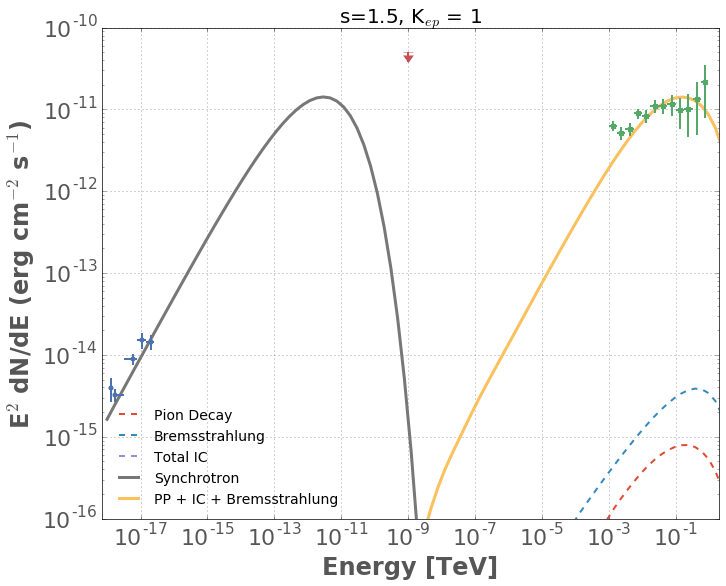

In [55]:
ncolors = plt.rcParams['axes.prop_cycle']
#Plot data + model
# * what should e_unit be? Try GeV, even though I used eV above
# * I need to figure out which param is which in the res file
# * What energy range to plot over?
# * do I not need to put emin/emax in IC?
# * add Kep
# * why is the amp / tev?
energy = np.logspace(-18, 2, 100) * u.TeV
fig = plt.figure(figsize = [10,8])

figure = naima.plot_data([G150Radio,G150_data,xray],figure = fig, e_unit=u.TeV) 
ax = figure.axes[0]

###First PP
alpha = 1.5
Kep = 1
amp_PP = g150Res_ICsyncBrems_PP['median'][1] / u.TeV
e_cutoff_PP = g150Res_ICsyncBrems_PP['median'][6] * u.TeV
Wp = g150Res_ICsyncBrems_PP['median'][7]

ECPL_PP = ExponentialCutoffPowerLaw(amp_PP, 10. * u.TeV, alpha, e_cutoff_PP)

nh   = 0.00806*u.cm**-3
dist = 0.38461*u.kpc
PP = PionDecay(ECPL_PP, nh=nh)

#Plot the computed model emission
ax.loglog(energy, PP.sed(energy, dist),
          lw=2, ls = '--',c=list(ncolors)[0]['color'], label='Pion Decay')#: n=1/cm^3, $W_p (E_p>1\, \mathrm{GeV})$ =%0.2e erg, index_ep = %0.2f, K$_{ep}$ = %0.2f' %(Wp,alpha,Kep))

###Now IC
amp_ICsync = Kep*amp_PP #10**g150Res_ICsync_PP['median'][5] / u.TeV *
e_cutoff_ICsync = g150Res_ICsyncBrems_PP['median'][4] * u.TeV
We = g150Res_ICsyncBrems_PP['median'][8]
B = g150Res_ICsyncBrems_PP['median'][2]*u.uG


ECPL_ICsync = ExponentialCutoffPowerLaw(amp_ICsync, 10. * u.TeV, alpha, e_cutoff_ICsync)

IC = InverseCompton(ECPL_ICsync,
                    seed_photon_fields=['CMB','FIR','NIR'],
                    Eemax=50 * u.PeV, Eemin=1 * u.GeV)

###And Sync
Sync = Synchrotron(ECPL_ICsync,
                    B = B,)

###Finally bremss

Bremss = Bremsstrahlung(ECPL_ICsync,n0=nh)

# Plot the computed IC and Sync model emissions
ax.loglog(energy, Bremss.sed(energy, dist),
          lw=2, ls = '--',c=list(ncolors)[1]['color'], label='Bremsstrahlung')
                   
ax.loglog(energy, IC.sed(energy, dist),
          lw=2, ls = '--',c=list(ncolors)[2]['color'], label='Total IC')#: $W_e (E_e>1\, \mathrm{GeV})$ =%0.2e erg, index_ep = %0.2f, K$_{ep}$ = %0.2f' %(We,alpha,Kep))
                   
ax.loglog(energy, Sync.sed(energy, dist),
          lw=3, c=list(ncolors)[3]['color'], label='Synchrotron')# $W_e (E_e>1\, \mathrm{GeV})$ =%0.2e erg, index_ep = %0.2f, K$_{ep}$ = %0.2f, B = %0.2f $\mathrm{\mu}$G' %(We,alpha,Kep,B.value))

###IC + PP + bresmss
#can I just sum them?
ax.loglog(energy, IC.sed(energy, dist)+PP.sed(energy, dist),
          lw=3,c=list(ncolors)[4]['color'], label='PP + IC + Bremsstrahlung')
                   
# for i, seed, ls in zip(range(4), ['CMB', 'FIR', 'NIR'], ['--', '-.', ':']):
#     ax.loglog(energy, IC.sed(energy, 2 * u.kpc, seed=seed),
#               lw=2, c=naima.plot.color_cycle[i + 1], label=seed, ls=ls)
ax.set_ylim(1e-16, 1e-10)
ax.set_xlim(7e-19,2)
ax.legend(loc='lower left', frameon=False,fontsize = 14)
figure.tight_layout()
plt.xlabel('Energy [TeV]',fontsize =24,weight='bold')


plt.ylabel(r'E$^{2}$ dN/dE (erg cm$^{-2}$ s$^{-1}$)',fontsize = 24,weight='bold')
plt.title(r's=1.5, K$_{ep}$ = 1',fontsize = 20)
#plt.xlabel(fontsize='large')
if not os.path.exists('G150_ICsyncBremss_PP_SED_Kep1_s15.png'):
    figure.savefig('G150_ICsyncBremss_PP_SED_Kep1_s15.png')
    figure.savefig('G150_ICsyncBremss_PP_SED_Kep1_s15.pdf')
    figure.savefig('G150_ICsyncBremss_PP_SED_Kep1_s15.eps')

# 14. IC+PP+Bremss+Sync, radio + GeV + X-ray. Fit s, Ap, E_Cut_p,  E_Cut_e. Don't fit Kep, use xray emitting density upper lim

# fixed s runs
## s =1.5
## Kep = 0.01
## E_Cut_p: <= 100 TeV

In [45]:
dirN= os.path.join(tDir,'fixedIndex/IC_Sync_bremss_PP_wRadio_Xray_nrun20_Kep001_s15')
if not os.path.exists(dirN):
    os.mkdir(dirN)
os.chdir(dirN)
%pwd

u'/Users/elunejava/Desktop/naimaTest/fixedIndex/IC_Sync_bremss_PP_wRadio_Xray_nrun20_Kep001_s15'

In [46]:
#I think i shouldn't be using the same particle distribution for pp and IC
#since the normalization (number of e-/p or We/Wp) should be different 
#But I might expect to have the same index for both
#If I do, I don't know that I can tie the indicies for two seperate particle distributions in naima
#I likely can with sherpa though

#For now, just use two different particle pops with all different params, start with the same p0 for both
def IC_PP_Syn_Bremss_Mod(pars, data):
    """Decide between PL or ECPL model based on number
       of params in pars. Set up pp Pion Decay and e- IC models"""
    
    #params not to fit
    pp_peMin = 1 * u.GeV
    ic_sync_eeMin = 1 * u.GeV
    nh = 0.00806 / u.cm**3
    sd_ph = ['CMB','FIR','NIR']
    dist = 0.38461 *u.kpc
    alpha = 1.5
    kep = 0.01 #value measured at Earth
    
    #p0 = np.array((norm_ic,norm_pp,cutoff_ic,cutoff_pp)) ###for ECPL, if PL, remove both cutoffs
    #norm_ICsync = 10**pars[0] / u.TeV
    norm_PP = 10**pars[0] / u.TeV
    norm_ICsync = kep*norm_PP
    B = pars[1] * u.uG
    

    #Instantiate particle distributions for IC and PP
    if len(pars) == 2:
        #print 'Particle distribution model is PL'
        pMod_ICsync = PowerLaw(norm_ICsync, 10. * u.TeV, alpha)
        pMod_PP = PowerLaw(norm_PP, 10. * u.TeV, alpha)
        
    elif len(pars) == 4:
        #print 'Particle distribution model is ECPL'
        e_cutoff_ICsync = (10**pars[2]) * u.TeV
        pMod_ICsync = ExponentialCutoffPowerLaw(norm_ICsync, 10. * u.TeV, alpha, e_cutoff_ICsync)
        e_cutoff_PP = (10**pars[3]) * u.TeV
        pMod_PP = ExponentialCutoffPowerLaw(norm_PP, 10. * u.TeV, alpha, e_cutoff_PP)
    else:
        raise Exception('Wrong number of params input for PL or ECPL')
        
            
    #instantiate IC models
    PP = PionDecay(pMod_PP, nh=nh)
        
    #instantiate IC models
    IC = InverseCompton(pMod_ICsync,
                        seed_photon_fields=sd_ph,
                        Eemin=ic_sync_eeMin)
    #instantiate Sync models
    SYN = Synchrotron(pMod_ICsync, B=B)
    
    Brem = Bremsstrahlung(pMod_ICsync, n0 = nh)
    
    #calculate PP + IC flux at energies of data
    model = (IC.flux(data, distance=dist) +
             PP.flux(data, distance=dist) +
             SYN.flux(data,distance=dist) +
             Brem.flux(data,distance=dist))
    
    # Save this realization of the particle distribution function
    particle_energy = np.logspace(-3, 2, 50) * u.TeV
    nelec = pMod_ICsync(particle_energy)
    proton_dist = PP.particle_distribution(particle_energy) ###is PP.particle_distribution the same as pMod(energy?)

    # Compute the total energy in protons/electrons above 1 GeV for this realization
    # Is it fine to calc We using either IC or sycn? Should be the same since it's the same population?
    # or do I need to compute for both a sum?
    
    Wp = PP.compute_Wp(Epmin=pp_peMin)
    We = IC.compute_We(Eemin=ic_sync_eeMin)#1 * u.TeV)

    # Return the model, proton distribution and energy in protons to be stored
    # in metadata blobs
    return model, (particle_energy, proton_dist), Wp, (particle_energy, nelec), We

def lnprior_ICsyncBremss_PP(pars):
    """
    Return probability of parameter values according to prior knowledge.
    Parameter. Include norm_ICsync, norm_PP, index. Not cutoffs (why not?)
    normP, index, B
    Is the only reson to include a param in the prior here to limit the range of values?
    for Kep (par[0]) max=1, min set to something small and not 0
        """

    logprob =  naima.uniform_prior(pars[0],0., np.inf)           \
                    + naima.uniform_prior(pars[1], 0.1, 500)     \
                    + naima.uniform_prior(pars[3], np.log10(0.001), np.log10(100))

    return logprob

#(10**pars[4]) * u.TeV


In [ ]:
#B: 3 : i know a few muG is the typicl ISM value, and typical of many SNR, but crab has ~200-300

#p0 = np.arra((norm_ic,cutoff_ic,norm_pp,cutoff_pp))
p0 = np.array((44, 3., np.log10(0.5),np.log10(5))) #start with same params for each, not sure this is best to do

##try this after running and maybe failing?
#p0 = np.array((31.1, 43.9,1.98,np.log10(49),np.log10(49)))
if len(p0) == 2:
    labels = ['log10(norm_PP)', 'B']
elif len(p0) ==4:
    labels = ['log10(norm_PP)', 'B','log10(cutoff_IC)','log10(cutoff_PP)']
    
## Run sampler
##change from nrun = 20 to 400
## double the number of walkers as well
##should I change the number of walkers as well?
## The reason to increase the number is to ensure that the sampling is stable and converges
##maybe having the number so was why the distributions looked funny, can't build it up with so few runs?

#original:nwalkers =32, nburn = 100 , nrun = 20
#high = nwalkers =63, nburn = 100 , nrun = 400
sampler, pos = naima.run_sampler(data_table=[G150Radio,G150_data,xray],
                                 p0=p0,
                                 labels=labels,
                                 model=IC_PP_Syn_Bremss_Mod,
                                 prior=lnprior_ICsyncBremss_PP,
                                 nwalkers=32,
                                 nburn=100,
                                 nrun=20,
                                 threads=4,
                                 prefit=True,
                                 interactive = False)

## Save run results to HDF5 file (can be read later with naima.read_run)
naima.save_run('G150_ICsyncBremss_PP_wRadio_Xray_Kep001_s15.hdf5', sampler)

## Diagnostic plots with labels for the metadata blobs
naima.save_diagnostic_plots('G150_ICsyncBremss_PP_wRadio_Xray_Kep001_s15',
                            sampler,
                            sed=True,
                            last_step=False,
                            blob_labels=['Proton Spectrum', 'Proton Energy Distribution',
                                         '$W_p (E_p>1\, \mathrm{GeV})$',
                                         'Electron Spectrum', 'Electron Energy Distribution',
                                         '$W_e (E_e>1\, \mathrm{GeV})$'])
naima.save_results_table('G150_ICsyncBremss_PP_wRadio_Xray_Kep001_s15', sampler)


In [47]:
#Read in data, see what it looks like
g150Res_ICsyncBrems_PP = ascii.read('G150_ICsyncBremss_PP_wRadio_Xray_Kep001_s15_results.ecsv')
g150Res_ICsyncBrems_PP

label,median,unc_lo,unc_hi
str16,float64,float64,float64
log10(norm_PP),46.1448209326,0.0605299515213,0.0448889665297
norm_PP,1.39579273195e+46,1.81590610295e+45,1.5198965081e+45
B,4.4700244594,0.562687220161,0.72633930641
log10(cutoff_IC),0.368731026623,0.0449052995688,0.0691640266605
cutoff_IC,2.3373891655,0.229606943094,0.403522588512
log10(cutoff_PP),-0.647659677936,1.51577891672,2.01089527334
cutoff_PP,0.22510307706,0.218238087887,22.8551416517
blob2,5.36479254214e+47,4.70364937559e+47,5.2849864481e+48
blob4,1.87159091195e+46,1.41483506209e+45,1.45702112991e+45


In [48]:
for ind, nam in enumerate(g150Res_ICsyncBrems_PP):
    print ind, nam['label'],nam['median']

0 log10(norm_PP) 46.1448209326
1 norm_PP 1.39579273195e+46
2 B 4.4700244594
3 log10(cutoff_IC) 0.368731026623
4 cutoff_IC 2.3373891655
5 log10(cutoff_PP) -0.647659677936
6 cutoff_PP 0.22510307706
7 blob2 5.36479254214e+47
8 blob4 1.87159091195e+46


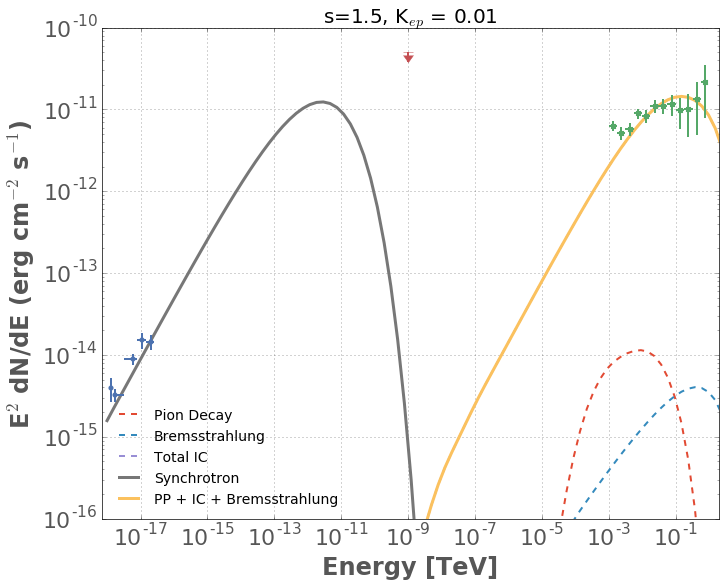

In [49]:
ncolors = plt.rcParams['axes.prop_cycle']
#Plot data + model
# * what should e_unit be? Try GeV, even though I used eV above
# * I need to figure out which param is which in the res file
# * What energy range to plot over?
# * do I not need to put emin/emax in IC?
# * add Kep
# * why is the amp / tev?
energy = np.logspace(-18, 2, 100) * u.TeV
fig = plt.figure(figsize = [10,8])

figure = naima.plot_data([G150Radio,G150_data,xray],figure = fig, e_unit=u.TeV) 
ax = figure.axes[0]

###First PP
alpha = 1.5
Kep = 0.01
amp_PP = g150Res_ICsyncBrems_PP['median'][1] / u.TeV
e_cutoff_PP = g150Res_ICsyncBrems_PP['median'][6] * u.TeV
Wp = g150Res_ICsyncBrems_PP['median'][7]

ECPL_PP = ExponentialCutoffPowerLaw(amp_PP, 10. * u.TeV, alpha, e_cutoff_PP)

nh   = 0.00806*u.cm**-3
dist = 0.38461*u.kpc
PP = PionDecay(ECPL_PP, nh=nh)

#Plot the computed model emission
ax.loglog(energy, PP.sed(energy, dist),
          lw=2, ls = '--',c=list(ncolors)[0]['color'], label='Pion Decay')#: n=1/cm^3, $W_p (E_p>1\, \mathrm{GeV})$ =%0.2e erg, index_ep = %0.2f, K$_{ep}$ = %0.2f' %(Wp,alpha,Kep))

###Now IC
amp_ICsync = Kep*amp_PP #10**g150Res_ICsync_PP['median'][5] / u.TeV *
e_cutoff_ICsync = g150Res_ICsyncBrems_PP['median'][4] * u.TeV
We = g150Res_ICsyncBrems_PP['median'][8]
B = g150Res_ICsyncBrems_PP['median'][2]*u.uG


ECPL_ICsync = ExponentialCutoffPowerLaw(amp_ICsync, 10. * u.TeV, alpha, e_cutoff_ICsync)

IC = InverseCompton(ECPL_ICsync,
                    seed_photon_fields=['CMB','FIR','NIR'],
                    Eemax=50 * u.PeV, Eemin=1 * u.GeV)

###And Sync
Sync = Synchrotron(ECPL_ICsync,
                    B = B,)

###Finally bremss

Bremss = Bremsstrahlung(ECPL_ICsync,n0=nh)

# Plot the computed IC and Sync model emissions
ax.loglog(energy, Bremss.sed(energy, dist),
          lw=2, ls = '--',c=list(ncolors)[1]['color'], label='Bremsstrahlung')
                   
ax.loglog(energy, IC.sed(energy, dist),
          lw=2, ls = '--',c=list(ncolors)[2]['color'], label='Total IC')#: $W_e (E_e>1\, \mathrm{GeV})$ =%0.2e erg, index_ep = %0.2f, K$_{ep}$ = %0.2f' %(We,alpha,Kep))
                   
ax.loglog(energy, Sync.sed(energy, dist),
          lw=3, c=list(ncolors)[3]['color'], label='Synchrotron')# $W_e (E_e>1\, \mathrm{GeV})$ =%0.2e erg, index_ep = %0.2f, K$_{ep}$ = %0.2f, B = %0.2f $\mathrm{\mu}$G' %(We,alpha,Kep,B.value))

###IC + PP + bresmss
#can I just sum them?
ax.loglog(energy, IC.sed(energy, dist)+PP.sed(energy, dist),
          lw=3,c=list(ncolors)[4]['color'], label='PP + IC + Bremsstrahlung')
                   
# for i, seed, ls in zip(range(4), ['CMB', 'FIR', 'NIR'], ['--', '-.', ':']):
#     ax.loglog(energy, IC.sed(energy, 2 * u.kpc, seed=seed),
#               lw=2, c=naima.plot.color_cycle[i + 1], label=seed, ls=ls)
ax.set_ylim(1e-16, 1e-10)
ax.set_xlim(7e-19,2)
ax.legend(loc='lower left', frameon=False,fontsize = 14)
figure.tight_layout()
plt.xlabel('Energy [TeV]',fontsize =24,weight='bold')


plt.ylabel(r'E$^{2}$ dN/dE (erg cm$^{-2}$ s$^{-1}$)',fontsize = 24,weight='bold')
plt.title(r's=1.5, K$_{ep}$ = 0.01',fontsize = 20)
#plt.xlabel(fontsize='large')
if not os.path.exists('G150_ICsyncBremss_PP_SED_Kep001_s15.png'):
    figure.savefig('G150_ICsyncBremss_PP_SED_Kep001_s15.png')
    figure.savefig('G150_ICsyncBremss_PP_SED_Kep001_s15.pdf')
    figure.savefig('G150_ICsyncBremss_PP_SED_Kep001_s15.eps')

# 15. IC+PP+Bremss+Sync, radio + GeV + X-ray. Fit s, Ap, E_Cut_p,  E_Cut_e. Don't fit Kep, use xray emitting density upper lim

# fixed s runs
## s =1.82
## Kep = 1
## E_Cut_p: <= 100 TeV

In [75]:
dirN= os.path.join(tDir,'fixedIndex/IC_Sync_bremss_PP_wRadio_Xray_nrun20_Kep1_sfit')
if not os.path.exists(dirN):
    os.mkdir(dirN)
os.chdir(dirN)
%pwd

u'/Users/elunejava/Desktop/naimaTest/fixedIndex/IC_Sync_bremss_PP_wRadio_Xray_nrun20_Kep1_sfit'

In [77]:
#I think i shouldn't be using the same particle distribution for pp and IC
#since the normalization (number of e-/p or We/Wp) should be different 
#But I might expect to have the same index for both
#If I do, I don't know that I can tie the indicies for two seperate particle distributions in naima
#I likely can with sherpa though

#For now, just use two different particle pops with all different params, start with the same p0 for both
def IC_PP_Syn_Bremss_Mod(pars, data):
    """Decide between PL or ECPL model based on number
       of params in pars. Set up pp Pion Decay and e- IC models"""
    
    #params not to fit
    pp_peMin = 1 * u.GeV
    ic_sync_eeMin = 1 * u.GeV
    
    nh = 0.00806 / u.cm**3
    sd_ph = ['CMB','FIR','NIR']
    dist = 0.38461 *u.kpc
    alpha = 1.82
    kep = 1 
    
    #p0 = np.array((norm_ic,norm_pp,cutoff_ic,cutoff_pp)) ###for ECPL, if PL, remove both cutoffs
    #norm_ICsync = 10**pars[0] / u.TeV
    norm_PP = 10**pars[0] / u.TeV
    norm_ICsync = kep*norm_PP
    B = pars[1] * u.uG
    

    #Instantiate particle distributions for IC and PP
    if len(pars) == 2:
        #print 'Particle distribution model is PL'
        pMod_ICsync = PowerLaw(norm_ICsync, 10. * u.TeV, alpha)
        pMod_PP = PowerLaw(norm_PP, 10. * u.TeV, alpha)
        
    elif len(pars) == 4:
        #print 'Particle distribution model is ECPL'
        e_cutoff_ICsync = (10**pars[2]) * u.TeV
        pMod_ICsync = ExponentialCutoffPowerLaw(norm_ICsync, 10. * u.TeV, alpha, e_cutoff_ICsync)
        e_cutoff_PP = (10**pars[3]) * u.TeV
        pMod_PP = ExponentialCutoffPowerLaw(norm_PP, 10. * u.TeV, alpha, e_cutoff_PP)
    else:
        raise Exception('Wrong number of params input for PL or ECPL')
        
            
    #instantiate IC models
    PP = PionDecay(pMod_PP, nh=nh)
        
    #instantiate IC models
    IC = InverseCompton(pMod_ICsync,
                        seed_photon_fields=sd_ph,
                        Eemin=ic_sync_eeMin)
    #instantiate Sync models
    SYN = Synchrotron(pMod_ICsync, B=B)
    
    Brem = Bremsstrahlung(pMod_ICsync, n0 = nh)
    
    #calculate PP + IC flux at energies of data
    model = (IC.flux(data, distance=dist) +
             PP.flux(data, distance=dist) +
             SYN.flux(data,distance=dist) +
             Brem.flux(data,distance=dist))
    
    # Save this realization of the particle distribution function
    particle_energy = np.logspace(-3, 2, 50) * u.TeV
    nelec = pMod_ICsync(particle_energy)
    proton_dist = PP.particle_distribution(particle_energy) ###is PP.particle_distribution the same as pMod(energy?)

    # Compute the total energy in protons/electrons above 1 GeV for this realization
    # Is it fine to calc We using either IC or sycn? Should be the same since it's the same population?
    # or do I need to compute for both a sum?
    
    Wp = PP.compute_Wp(Epmin=pp_peMin)
    We = IC.compute_We(Eemin=ic_sync_eeMin)#1 * u.TeV)

    # Return the model, proton distribution and energy in protons to be stored
    # in metadata blobs
    return model, (particle_energy, proton_dist), Wp, (particle_energy, nelec), We

def lnprior_ICsyncBremss_PP(pars):
    """
    Return probability of parameter values according to prior knowledge.
    Parameter. Include norm_ICsync, norm_PP, index. Not cutoffs (why not?)
    normP, index, B
    Is the only reson to include a param in the prior here to limit the range of values?
    for Kep (par[0]) max=1, min set to something small and not 0
        """

    logprob =  naima.uniform_prior(pars[0],0., np.inf)           \
                    + naima.uniform_prior(pars[1], 0.1, 500)     \
                    + naima.uniform_prior(pars[2], np.log10(0.001), np.log10(100)) \
                    + naima.uniform_prior(pars[3], np.log10(0.001), np.log10(100))

    return logprob

#(10**pars[4]) * u.TeV


INFO:astropy:Finding Maximum Likelihood parameters through Nelder-Mead fitting...
INFO:astropy:   Initial parameters: [ 43.50566086   3.          -0.30103      0.69897   ]


INFO: Finding Maximum Likelihood parameters through Nelder-Mead fitting... [naima.core]
INFO:    Initial parameters: [ 43.50566086   3.          -0.30103      0.69897   ] [naima.core]
INFO

INFO:astropy:   Initial lnprob(p0): -582.687


:    Initial lnprob(p0): -582.687 [naima.core]
INFO

INFO:astropy:   New ML parameters : [ 42.77413497   8.49610869   1.451324     1.0487776 ]
INFO:astropy:   Maximum lnprob(p0): -117.663


:    New ML parameters : [ 42.77413497   8.49610869   1.451324     1.0487776 ] [naima.core]
INFO:    Maximum lnprob(p0): -117.663 [naima.core]
Burning in the 64 walkers with 100 steps...

Progress of the run: 0 percent (0 of 100 steps)
                           log10(norm_PP)- -------B------- log10(cutoff_IC) log10(cutoff_PP)
  Last ensemble median :      42.7            8.49            1.45            1.05      
  Last ensemble std    :      0.22           0.0479          0.00735         0.00507    
  Last ensemble lnprob :  avg: -150.023, max: -117.680

Progress of the run: 5 percent (5 of 100 steps)
                           log10(norm_PP)- -------B------- log10(cutoff_IC) log10(cutoff_PP)
  Last ensemble median :      42.8             8.5            1.45            1.05      
  Last ensemble std    :      0.14           0.0648          0.0104          0.00609    
  Last ensemble lnprob :  avg: -129.883, max: -117.655

Progress of the run: 10 percent (10 of 100 steps)
            


                           log10(norm_PP)- -------B------- log10(cutoff_IC) log10(cutoff_PP)
  Last ensemble median :      42.8            7.01            1.53           -0.586     
  Last ensemble std    :     0.0753           1.59            0.22            1.56      
  Last ensemble lnprob :  avg: -119.151, max: -117.254
INFO

INFO:astropy:Plotting chain of parameter log10(norm_PP)...


: Plotting chain of parameter log10(norm_PP)... [naima.analysis]
INFO

INFO:astropy:------------------log10(norm_PP)------------------
          log10(norm_PP) = $42.83 \pm 0.08$
                 norm_PP = $(6.7 \pm 1.2)\times10^{42}$


: ------------------log10(norm_PP)------------------
          log10(norm_PP) = $42.83 \pm 0.08$
                 norm_PP = $(6.7 \pm 1.2)\times10^{42}$ [naima.plot]
INFO

INFO:astropy:Plotting chain of parameter B...


: Plotting chain of parameter B... [naima.analysis]
INFO

INFO:astropy:------------------------B-------------------------
          B = $7.1 \pm 1.6$


: ------------------------B-------------------------
          B = $7.1 \pm 1.6$ [naima.plot]
INFO

INFO:astropy:Plotting chain of parameter log10(cutoff_IC)...


: Plotting chain of parameter log10(cutoff_IC)... [naima.analysis]
INFO

INFO:astropy:-----------------log10(cutoff_IC)-----------------
          log10(cutoff_IC) = $1.53^{+0.3}_{-0.17}$
                 cutoff_IC = $34^{+40}_{-11}$


: -----------------log10(cutoff_IC)-----------------
          log10(cutoff_IC) = $1.53^{+0.3}_{-0.17}$
                 cutoff_IC = $34^{+40}_{-11}$ [naima.plot]
INFO

INFO:astropy:Plotting chain of parameter log10(cutoff_PP)...


: Plotting chain of parameter log10(cutoff_PP)... [naima.analysis]
INFO

INFO:astropy:-----------------log10(cutoff_PP)-----------------
          log10(cutoff_PP) = $-0.2 \pm 1.7$
                 cutoff_PP = $0.6^{+20}_{-0.6}$


: -----------------log10(cutoff_PP)-----------------
          log10(cutoff_PP) = $-0.2 \pm 1.7$
                 cutoff_PP = $0.6^{+20}_{-0.6}$ [naima.plot]
INFO

INFO:astropy:Plotting corner plot...


: Plotting corner plot... [naima.analysis]
INFO

INFO:astropy:Plotting Proton Spectrum...
/Users/elunejava/anaconda/lib/python2.7/site-packages/matplotlib/axes/_base.py:2767: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=1e-06, right=1e-06
  'left=%s, right=%s') % (left, right))


: Plotting Proton Spectrum... [naima.analysis]
INFO

INFO:astropy:Plotting Proton Energy Distribution...


: Plotting Proton Energy Distribution... [naima.analysis]
INFO

INFO:astropy:Plotting $W_p (E_p>1\, \mathrm{GeV})$...


: Plotting $W_p (E_p>1\, \mathrm{GeV})$... [naima.analysis]
INFO

INFO:astropy:Plotting Electron Spectrum...


: Plotting Electron Spectrum... [naima.analysis]
INFO

INFO:astropy:Plotting Electron Energy Distribution...


: Plotting Electron Energy Distribution... [naima.analysis]
INFO

INFO:astropy:Saving results table in G150_ICsyncBremss_PP_wRadio_Xray_Kep1_sfit_results.ecsv


: Saving results table in G150_ICsyncBremss_PP_wRadio_Xray_Kep1_sfit_results.ecsv [naima.analysis]


label,median,unc_lo,unc_hi
str72,float64,float64,float64
log10(norm_PP),42.828927904,0.0835251282175,0.0693515975132
norm_PP,6.74416060457e+42,1.17996004207e+42,1.16771593096e+42
B,7.05421447015,1.46962325812,1.79048478456
log10(cutoff_IC),1.53037045861,0.173437208894,0.317231572336
cutoff_IC,33.9133317823,11.16585399,36.491429606
log10(cutoff_PP),-0.219462740564,1.86003129166,1.5383769426
cutoff_PP,0.603305469925,0.594978136237,20.237485708
blob2,2.14450793781e+45,1.72621098432e+45,2.94106032459e+45
blob4,5.86713349739e+45,1.20557656944e+45,1.3187467221e+45


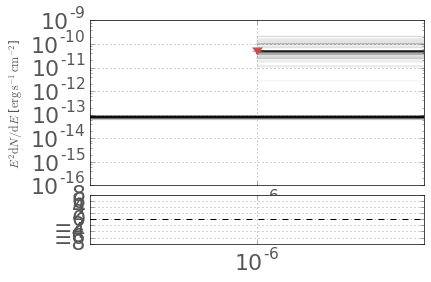

In [78]:
#B: 3 : i know a few muG is the typicl ISM value, and typical of many SNR, but crab has ~200-300

#p0 = np.arra((norm_ic,cutoff_ic,norm_pp,cutoff_pp))
p0 = np.array((44, 3., np.log10(0.5),np.log10(5))) #start with same params for each, not sure this is best to do

##try this after running and maybe failing?
#p0 = np.array((31.1, 43.9,1.98,np.log10(49),np.log10(49)))
if len(p0) == 2:
    labels = ['log10(norm_PP)', 'B']
elif len(p0) ==4:
    labels = ['log10(norm_PP)', 'B','log10(cutoff_IC)','log10(cutoff_PP)']
    
## Run sampler
##change from nrun = 20 to 400
## double the number of walkers as well
##should I change the number of walkers as well?
## The reason to increase the number is to ensure that the sampling is stable and converges
##maybe having the number so was why the distributions looked funny, can't build it up with so few runs?

#original:nwalkers =32, nburn = 100 , nrun = 20
#high = nwalkers =63, nburn = 100 , nrun = 400
sampler, pos = naima.run_sampler(data_table=[G150Radio,G150_data,xray],
                                 p0=p0,
                                 labels=labels,
                                 model=IC_PP_Syn_Bremss_Mod,
                                 prior=lnprior_ICsyncBremss_PP,
                                 nwalkers=64,
                                 nburn=100,
                                 nrun=400,
                                 threads=4,
                                 prefit=True,
                                 interactive = False)

## Save run results to HDF5 file (can be read later with naima.read_run)
naima.save_run('G150_ICsyncBremss_PP_wRadio_Xray_Kep1_sfit.hdf5', sampler)

## Diagnostic plots with labels for the metadata blobs
naima.save_diagnostic_plots('G150_ICsyncBremss_PP_wRadio_Xray_Kep1_sfit',
                            sampler,
                            sed=True,
                            last_step=False,
                            blob_labels=['Proton Spectrum', 'Proton Energy Distribution',
                                         '$W_p (E_p>1\, \mathrm{GeV})$',
                                         'Electron Spectrum', 'Electron Energy Distribution',
                                         '$W_e (E_e>1\, \mathrm{GeV})$'])
naima.save_results_table('G150_ICsyncBremss_PP_wRadio_Xray_Kep1_sfit', sampler)


In [42]:
#Read in data, see what it looks like
g150Res_ICsyncBrems_PP = ascii.read('G150_ICsyncBremss_PP_wRadio_Xray_Kep1_sfit_results.ecsv')
g150Res_ICsyncBrems_PP

label,median,unc_lo,unc_hi
str16,float64,float64,float64
log10(norm_PP),42.831572924,0.0986993322851,0.0654869543476
norm_PP,6.78536046367e+42,1.37939095684e+42,1.104328429e+42
B,6.9167579298,1.58742962266,2.45380020853
log10(cutoff_IC),1.52450259769,0.162909949879,0.214307855364
cutoff_IC,33.4582019116,10.4652109361,21.3455703646
log10(cutoff_PP),-0.0505284501422,2.09600228904,1.43414337264
cutoff_PP,0.890796107761,0.883659870827,23.2980372457
blob2,2.32616614078e+45,1.92080854273e+45,2.71173539375e+45
blob4,5.86459282455e+45,1.21817603056e+45,1.16288950711e+45


In [79]:
#Read in data, see what it looks like
g150Res_ICsyncBrems_PP = ascii.read('G150_ICsyncBremss_PP_wRadio_Xray_Kep1_sfit_results.ecsv')
g150Res_ICsyncBrems_PP

label,median,unc_lo,unc_hi
str16,float64,float64,float64
log10(norm_PP),42.828927904,0.0835251282175,0.0693515975132
norm_PP,6.74416060457e+42,1.17996004207e+42,1.16771593096e+42
B,7.05421447015,1.46962325812,1.79048478456
log10(cutoff_IC),1.53037045861,0.173437208894,0.317231572336
cutoff_IC,33.9133317823,11.16585399,36.491429606
log10(cutoff_PP),-0.219462740564,1.86003129166,1.5383769426
cutoff_PP,0.603305469925,0.594978136237,20.237485708
blob2,2.14450793781e+45,1.72621098432e+45,2.94106032459e+45
blob4,5.86713349739e+45,1.20557656944e+45,1.3187467221e+45


In [80]:
for ind, nam in enumerate(g150Res_ICsyncBrems_PP):
    print ind, nam['label'],nam['median']

0 log10(norm_PP) 42.828927904
1 norm_PP 6.74416060457e+42
2 B 7.05421447015
3 log10(cutoff_IC) 1.53037045861
4 cutoff_IC 33.9133317823
5 log10(cutoff_PP) -0.219462740564
6 cutoff_PP 0.603305469925
7 blob2 2.14450793781e+45
8 blob4 5.86713349739e+45


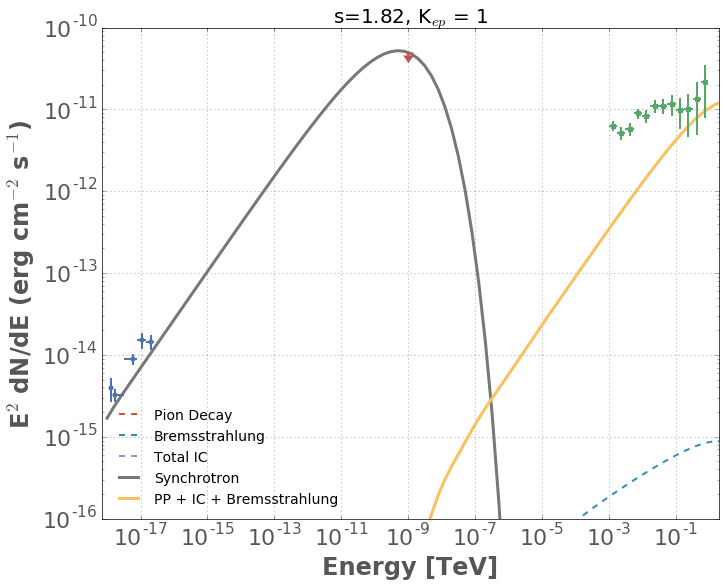

In [81]:
ncolors = plt.rcParams['axes.prop_cycle']
#Plot data + model
# * what should e_unit be? Try GeV, even though I used eV above
# * I need to figure out which param is which in the res file
# * What energy range to plot over?
# * do I not need to put emin/emax in IC?
# * add Kep
# * why is the amp / tev?
energy = np.logspace(-18, 2, 100) * u.TeV
fig = plt.figure(figsize = [10,8])

figure = naima.plot_data([G150Radio,G150_data,xray],figure = fig, e_unit=u.TeV) 
ax = figure.axes[0]

###First PP
alpha = 1.82
Kep = 1
amp_PP = g150Res_ICsyncBrems_PP['median'][1] / u.TeV
e_cutoff_PP = g150Res_ICsyncBrems_PP['median'][6] * u.TeV
Wp = g150Res_ICsyncBrems_PP['median'][7]

ECPL_PP = ExponentialCutoffPowerLaw(amp_PP, 10. * u.TeV, alpha, e_cutoff_PP)

nh   = 0.00806*u.cm**-3
dist = 0.38461*u.kpc
PP = PionDecay(ECPL_PP, nh=nh)

#Plot the computed model emission
ax.loglog(energy, PP.sed(energy, dist),
          lw=2, ls = '--',c=list(ncolors)[0]['color'], label='Pion Decay')#: n=1/cm^3, $W_p (E_p>1\, \mathrm{GeV})$ =%0.2e erg, index_ep = %0.2f, K$_{ep}$ = %0.2f' %(Wp,alpha,Kep))

###Now IC
amp_ICsync = Kep*amp_PP #10**g150Res_ICsync_PP['median'][5] / u.TeV *
e_cutoff_ICsync = g150Res_ICsyncBrems_PP['median'][4] * u.TeV
We = g150Res_ICsyncBrems_PP['median'][8]
B = g150Res_ICsyncBrems_PP['median'][2]*u.uG


ECPL_ICsync = ExponentialCutoffPowerLaw(amp_ICsync, 10. * u.TeV, alpha, e_cutoff_ICsync)

IC = InverseCompton(ECPL_ICsync,
                    seed_photon_fields=['CMB','FIR','NIR'],
                    Eemax=50 * u.PeV, Eemin=1 * u.GeV)

###And Sync
Sync = Synchrotron(ECPL_ICsync,
                    B = B,)

###Finally bremss

Bremss = Bremsstrahlung(ECPL_ICsync,n0=nh)

# Plot the computed IC and Sync model emissions
ax.loglog(energy, Bremss.sed(energy, dist),
          lw=2, ls = '--',c=list(ncolors)[1]['color'], label='Bremsstrahlung')
                   
ax.loglog(energy, IC.sed(energy, dist),
          lw=2, ls = '--',c=list(ncolors)[2]['color'], label='Total IC')#: $W_e (E_e>1\, \mathrm{GeV})$ =%0.2e erg, index_ep = %0.2f, K$_{ep}$ = %0.2f' %(We,alpha,Kep))
                   
ax.loglog(energy, Sync.sed(energy, dist),
          lw=3, c=list(ncolors)[3]['color'], label='Synchrotron')# $W_e (E_e>1\, \mathrm{GeV})$ =%0.2e erg, index_ep = %0.2f, K$_{ep}$ = %0.2f, B = %0.2f $\mathrm{\mu}$G' %(We,alpha,Kep,B.value))

###IC + PP + bresmss
#can I just sum them?
ax.loglog(energy, IC.sed(energy, dist)+PP.sed(energy, dist),
          lw=3,c=list(ncolors)[4]['color'], label='PP + IC + Bremsstrahlung')
                   
# for i, seed, ls in zip(range(4), ['CMB', 'FIR', 'NIR'], ['--', '-.', ':']):
#     ax.loglog(energy, IC.sed(energy, 2 * u.kpc, seed=seed),
#               lw=2, c=naima.plot.color_cycle[i + 1], label=seed, ls=ls)
ax.set_ylim(1e-16, 1e-10)
ax.set_xlim(7e-19,2)
ax.legend(loc='lower left', frameon=False,fontsize = 14)
figure.tight_layout()
plt.xlabel('Energy [TeV]',fontsize =24,weight='bold')


plt.ylabel(r'E$^{2}$ dN/dE (erg cm$^{-2}$ s$^{-1}$)',fontsize = 24,weight='bold')
plt.title(r's=1.82, K$_{ep}$ = 1',fontsize = 20)
#plt.xlabel(fontsize='large')
#if not os.path.exists('G150_ICsyncBremss_PP_SED_Kep1_sfit.png'):
figure.savefig('G150_ICsyncBremss_PP_SED_Kep1_sfit.png')
figure.savefig('G150_ICsyncBremss_PP_SED_Kep1_sfit.pdf')
figure.savefig('G150_ICsyncBremss_PP_SED_Kep1_sfit.eps')

# 16. IC+PP+Bremss+Sync, radio + GeV + X-ray. Fit s, Ap, E_Cut_p,  E_Cut_e. Don't fit Kep, use xray emitting density upper lim

# fixed s runs
## s =1.82
## Kep = 0.01
## E_Cut_p: <= 100 TeV

In [34]:
dirN= os.path.join(tDir,'fixedIndex/IC_Sync_bremss_PP_wRadio_Xray_nrun20_Kep001_sfit')
if not os.path.exists(dirN):
    os.mkdir(dirN)
os.chdir(dirN)
%pwd

u'/Users/elunejava/Desktop/naimaTest/fixedIndex/IC_Sync_bremss_PP_wRadio_Xray_nrun20_Kep001_sfit'

In [36]:
#I think i shouldn't be using the same particle distribution for pp and IC
#since the normalization (number of e-/p or We/Wp) should be different 
#But I might expect to have the same index for both
#If I do, I don't know that I can tie the indicies for two seperate particle distributions in naima
#I likely can with sherpa though

#For now, just use two different particle pops with all different params, start with the same p0 for both
def IC_PP_Syn_Bremss_Mod(pars, data):
    """Decide between PL or ECPL model based on number
       of params in pars. Set up pp Pion Decay and e- IC models"""
    
    #params not to fit
    pp_peMin = 1 * u.GeV
    ic_sync_eeMin = 1 * u.GeV
    nh = 0.00806 / u.cm**3
    sd_ph = ['CMB','FIR','NIR']
    dist = 0.38461 *u.kpc
    alpha = 1.82
    
    #p0 = np.array((norm_ic,norm_pp,cutoff_ic,cutoff_pp)) ###for ECPL, if PL, remove both cutoffs
    
    kep = 0.01 #value measured at Earth
    #norm_ICsync = 10**pars[0] / u.TeV
    norm_PP = 10**pars[0] / u.TeV
    norm_ICsync = kep*norm_PP
    B = pars[1] * u.uG
    

    #Instantiate particle distributions for IC and PP
    if len(pars) == 2:
        #print 'Particle distribution model is PL'
        pMod_ICsync = PowerLaw(norm_ICsync, 10. * u.TeV, alpha)
        pMod_PP = PowerLaw(norm_PP, 10. * u.TeV, alpha)
        
    elif len(pars) == 4:
        #print 'Particle distribution model is ECPL'
        e_cutoff_ICsync = (10**pars[2]) * u.TeV
        pMod_ICsync = ExponentialCutoffPowerLaw(norm_ICsync, 10. * u.TeV, alpha, e_cutoff_ICsync)
        e_cutoff_PP = (10**pars[3]) * u.TeV
        pMod_PP = ExponentialCutoffPowerLaw(norm_PP, 10. * u.TeV, alpha, e_cutoff_PP)
    else:
        raise Exception('Wrong number of params input for PL or ECPL')
        
            
    #instantiate IC models
    PP = PionDecay(pMod_PP, nh=nh)
        
    #instantiate IC models
    IC = InverseCompton(pMod_ICsync,
                        seed_photon_fields=sd_ph,
                        Eemin=ic_sync_eeMin)
    #instantiate Sync models
    SYN = Synchrotron(pMod_ICsync, B=B)
    
    Brem = Bremsstrahlung(pMod_ICsync, n0 = nh)
    
    #calculate PP + IC flux at energies of data
    model = (IC.flux(data, distance=dist) +
             PP.flux(data, distance=dist) +
             SYN.flux(data,distance=dist) +
             Brem.flux(data,distance=dist))
    
    # Save this realization of the particle distribution function
    particle_energy = np.logspace(-3, 2, 50) * u.TeV
    nelec = pMod_ICsync(particle_energy)
    proton_dist = PP.particle_distribution(particle_energy) ###is PP.particle_distribution the same as pMod(energy?)

    # Compute the total energy in protons/electrons above 1 GeV for this realization
    # Is it fine to calc We using either IC or sycn? Should be the same since it's the same population?
    # or do I need to compute for both a sum?
    
    Wp = PP.compute_Wp(Epmin=pp_peMin)
    We = IC.compute_We(Eemin=ic_sync_eeMin)#1 * u.TeV)

    # Return the model, proton distribution and energy in protons to be stored
    # in metadata blobs
    return model, (particle_energy, proton_dist), Wp, (particle_energy, nelec), We

def lnprior_ICsyncBremss_PP(pars):
    """
    Return probability of parameter values according to prior knowledge.
    Parameter. Include norm_ICsync, norm_PP, index. Not cutoffs (why not?)
    normP, index, B
    Is the only reson to include a param in the prior here to limit the range of values?
    for Kep (par[0]) max=1, min set to something small and not 0
        """

    logprob =  naima.uniform_prior(pars[0],0., np.inf)           \
                    + naima.uniform_prior(pars[1], 0.1, 500)     \
                    + naima.uniform_prior(pars[2], np.log10(0.001), np.log10(100)) \
                    + naima.uniform_prior(pars[3], np.log10(0.001), np.log10(100))

    return logprob

#(10**pars[4]) * u.TeV


In [ ]:
#B: 3 : i know a few muG is the typicl ISM value, and typical of many SNR, but crab has ~200-300

#p0 = np.arra((norm_ic,cutoff_ic,norm_pp,cutoff_pp))
p0 = np.array((44, 3., np.log10(0.5),np.log10(5))) #start with same params for each, not sure this is best to do

##try this after running and maybe failing?
#p0 = np.array((31.1, 43.9,1.98,np.log10(49),np.log10(49)))
if len(p0) == 2:
    labels = ['log10(norm_PP)', 'B']
elif len(p0) ==4:
    labels = ['log10(norm_PP)', 'B','log10(cutoff_IC)','log10(cutoff_PP)']
    
## Run sampler
##change from nrun = 20 to 400
## double the number of walkers as well
##should I change the number of walkers as well?
## The reason to increase the number is to ensure that the sampling is stable and converges
##maybe having the number so was why the distributions looked funny, can't build it up with so few runs?

#original:nwalkers =32, nburn = 100 , nrun = 20
#high = nwalkers =63, nburn = 100 , nrun = 400
sampler, pos = naima.run_sampler(data_table=[G150Radio,G150_data,xray],
                                 p0=p0,
                                 labels=labels,
                                 model=IC_PP_Syn_Bremss_Mod,
                                 prior=lnprior_ICsyncBremss_PP,
                                 nwalkers=32,
                                 nburn=100,
                                 nrun=20,
                                 threads=4,
                                 prefit=True,
                                 interactive = False)

## Save run results to HDF5 file (can be read later with naima.read_run)
naima.save_run('G150_ICsyncBremss_PP_wRadio_Xray_Kep001_sfit.hdf5', sampler)

## Diagnostic plots with labels for the metadata blobs
naima.save_diagnostic_plots('G150_ICsyncBremss_PP_wRadio_Xray_Kep001_sfit',
                            sampler,
                            sed=True,
                            last_step=False,
                            blob_labels=['Proton Spectrum', 'Proton Energy Distribution',
                                         '$W_p (E_p>1\, \mathrm{GeV})$',
                                         'Electron Spectrum', 'Electron Energy Distribution',
                                         '$W_e (E_e>1\, \mathrm{GeV})$'])
naima.save_results_table('G150_ICsyncBremss_PP_wRadio_Xray_Kep001_sfit', sampler)


In [37]:
#Read in data, see what it looks like
g150Res_ICsyncBrems_PP = ascii.read('G150_ICsyncBremss_PP_wRadio_Xray_Kep001_sfit_results.ecsv')
g150Res_ICsyncBrems_PP

label,median,unc_lo,unc_hi
str16,float64,float64,float64
log10(norm_PP),44.7834577238,0.141232905355,0.0828673525615
norm_PP,6.0737613528e+44,1.68617827327e+44,1.27687734125e+44
B,7.83697950693,1.79831455728,3.30467499097
log10(cutoff_IC),1.44375971432,0.202720416989,0.382052646504
cutoff_IC,27.7818112054,10.3621663184,39.1777336021
log10(cutoff_PP),-0.21653203152,1.90058604252,1.56361158165
cutoff_PP,0.607390462945,0.59975406042,21.6297812742
blob2,1.80156390143e+47,1.51353805837e+47,3.27536166051e+47
blob4,5.01882550458e+45,1.2958082381e+45,1.64658259414e+45


In [38]:
for ind, nam in enumerate(g150Res_ICsyncBrems_PP):
    print ind, nam['label'],nam['median']

0 log10(norm_PP) 44.7834577238
1 norm_PP 6.0737613528e+44
2 B 7.83697950693
3 log10(cutoff_IC) 1.44375971432
4 cutoff_IC 27.7818112054
5 log10(cutoff_PP) -0.21653203152
6 cutoff_PP 0.607390462945
7 blob2 1.80156390143e+47
8 blob4 5.01882550458e+45


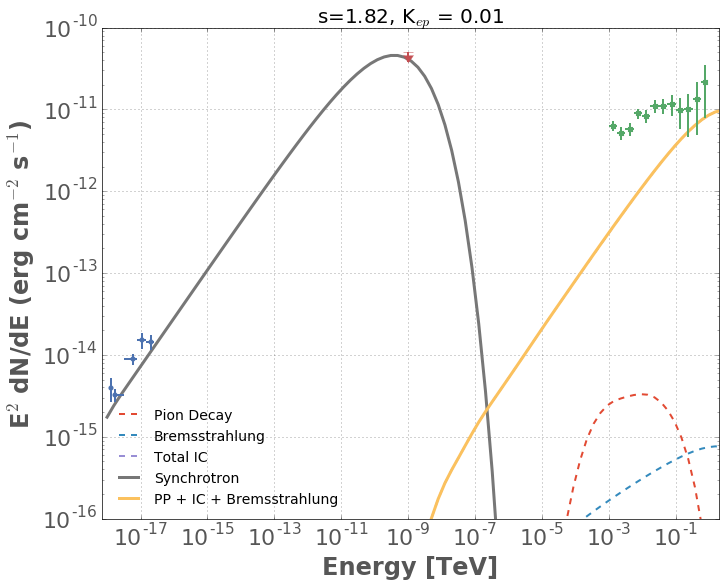

In [39]:
ncolors = plt.rcParams['axes.prop_cycle']
#Plot data + model
# * what should e_unit be? Try GeV, even though I used eV above
# * I need to figure out which param is which in the res file
# * What energy range to plot over?
# * do I not need to put emin/emax in IC?
# * add Kep
# * why is the amp / tev?
energy = np.logspace(-18, 2, 100) * u.TeV
fig = plt.figure(figsize = [10,8])

figure = naima.plot_data([G150Radio,G150_data,xray],figure = fig, e_unit=u.TeV) 
ax = figure.axes[0]

###First PP
alpha = 1.82
Kep = 0.01
amp_PP = g150Res_ICsyncBrems_PP['median'][1] / u.TeV
e_cutoff_PP = g150Res_ICsyncBrems_PP['median'][6] * u.TeV
Wp = g150Res_ICsyncBrems_PP['median'][7]

ECPL_PP = ExponentialCutoffPowerLaw(amp_PP, 10. * u.TeV, alpha, e_cutoff_PP)

nh   = 0.00806*u.cm**-3
dist = 0.38461 * u.kpc
PP = PionDecay(ECPL_PP, nh=nh)

#Plot the computed model emission
ax.loglog(energy, PP.sed(energy, dist),
          lw=2, ls = '--',c=list(ncolors)[0]['color'], label='Pion Decay')#: n=1/cm^3, $W_p (E_p>1\, \mathrm{GeV})$ =%0.2e erg, index_ep = %0.2f, K$_{ep}$ = %0.2f' %(Wp,alpha,Kep))

###Now IC
amp_ICsync = Kep*amp_PP #10**g150Res_ICsync_PP['median'][5] / u.TeV *
e_cutoff_ICsync = g150Res_ICsyncBrems_PP['median'][4] * u.TeV
We = g150Res_ICsyncBrems_PP['median'][8]
B = g150Res_ICsyncBrems_PP['median'][2]*u.uG


ECPL_ICsync = ExponentialCutoffPowerLaw(amp_ICsync, 10. * u.TeV, alpha, e_cutoff_ICsync)

IC = InverseCompton(ECPL_ICsync,
                    seed_photon_fields=['CMB','FIR','NIR'],
                    Eemax=50 * u.PeV, Eemin=1 * u.GeV)

###And Sync
Sync = Synchrotron(ECPL_ICsync,
                    B = B,)

###Finally bremss

Bremss = Bremsstrahlung(ECPL_ICsync,n0=nh)

# Plot the computed IC and Sync model emissions
ax.loglog(energy, Bremss.sed(energy, dist),
          lw=2, ls = '--',c=list(ncolors)[1]['color'], label='Bremsstrahlung')
                   
ax.loglog(energy, IC.sed(energy, dist),
          lw=2, ls = '--',c=list(ncolors)[2]['color'], label='Total IC')#: $W_e (E_e>1\, \mathrm{GeV})$ =%0.2e erg, index_ep = %0.2f, K$_{ep}$ = %0.2f' %(We,alpha,Kep))
                   
ax.loglog(energy, Sync.sed(energy, dist),
          lw=3, c=list(ncolors)[3]['color'], label='Synchrotron')# $W_e (E_e>1\, \mathrm{GeV})$ =%0.2e erg, index_ep = %0.2f, K$_{ep}$ = %0.2f, B = %0.2f $\mathrm{\mu}$G' %(We,alpha,Kep,B.value))

###IC + PP + bresmss
#can I just sum them?
ax.loglog(energy, IC.sed(energy, dist)+PP.sed(energy, dist),
          lw=3,c=list(ncolors)[4]['color'], label='PP + IC + Bremsstrahlung')
                   
# for i, seed, ls in zip(range(4), ['CMB', 'FIR', 'NIR'], ['--', '-.', ':']):
#     ax.loglog(energy, IC.sed(energy, 2 * u.kpc, seed=seed),
#               lw=2, c=naima.plot.color_cycle[i + 1], label=seed, ls=ls)
ax.set_ylim(1e-16, 1e-10)
ax.set_xlim(7e-19,2)
ax.legend(loc='lower left', frameon=False,fontsize = 14)
figure.tight_layout()
plt.xlabel('Energy [TeV]',fontsize =24,weight='bold')


plt.ylabel(r'E$^{2}$ dN/dE (erg cm$^{-2}$ s$^{-1}$)',fontsize = 24,weight='bold')
plt.title(r's=1.82, K$_{ep}$ = 0.01',fontsize = 20)
#plt.xlabel(fontsize='large')
if not os.path.exists('G150_ICsyncBremss_PP_SED_Kep001_sfit.png')
    figure.savefig('G150_ICsyncBremss_PP_SED_Kep001_sfit.png')
    figure.savefig('G150_ICsyncBremss_PP_SED_Kep001_sfit.pdf')
    figure.savefig('G150_ICsyncBremss_PP_SED_Kep001_sfit.eps')

# 16. IC+PP+Bremss+Sync, radio + GeV + X-ray. Fit s, Ap, E_Cut_p,  E_Cut_e. Don't fit Kep, use xray emitting density upper lim

# fixed s runs
## s =1.82
## Kep = 0.1
## E_Cut_p: <= 100 TeV

In [28]:
dirN= os.path.join(tDir,'fixedIndex/IC_Sync_bremss_PP_wRadio_Xray_nrun20_Kep01_sfit')
if not os.path.exists(dirN):
    os.mkdir(dirN)
os.chdir(dirN)
%pwd

u'/Users/elunejava/Desktop/naimaTest/fixedIndex/IC_Sync_bremss_PP_wRadio_Xray_nrun20_Kep01_sfit'

In [30]:
#I think i shouldn't be using the same particle distribution for pp and IC
#since the normalization (number of e-/p or We/Wp) should be different 
#But I might expect to have the same index for both
#If I do, I don't know that I can tie the indicies for two seperate particle distributions in naima
#I likely can with sherpa though

#For now, just use two different particle pops with all different params, start with the same p0 for both
def IC_PP_Syn_Bremss_Mod(pars, data):
    """Decide between PL or ECPL model based on number
       of params in pars. Set up pp Pion Decay and e- IC models"""
    
    #params not to fit
    pp_peMin = 1 * u.GeV
    ic_sync_eeMin = 1 * u.GeV
    nh = 0.00806 / u.cm**3
    sd_ph = ['CMB','FIR','NIR']
    dist = 0.38461 *u.kpc
    alpha = 1.82
    
    #p0 = np.array((norm_ic,norm_pp,cutoff_ic,cutoff_pp)) ###for ECPL, if PL, remove both cutoffs
    
    kep = 0.1 
    #norm_ICsync = 10**pars[0] / u.TeV
    norm_PP = 10**pars[0] / u.TeV
    norm_ICsync = kep*norm_PP
    B = pars[1] * u.uG
    

    #Instantiate particle distributions for IC and PP
    if len(pars) == 2:
        #print 'Particle distribution model is PL'
        pMod_ICsync = PowerLaw(norm_ICsync, 10. * u.TeV, alpha)
        pMod_PP = PowerLaw(norm_PP, 10. * u.TeV, alpha)
        
    elif len(pars) == 4:
        #print 'Particle distribution model is ECPL'
        e_cutoff_ICsync = (10**pars[2]) * u.TeV
        pMod_ICsync = ExponentialCutoffPowerLaw(norm_ICsync, 10. * u.TeV, alpha, e_cutoff_ICsync)
        e_cutoff_PP = (10**pars[3]) * u.TeV
        pMod_PP = ExponentialCutoffPowerLaw(norm_PP, 10. * u.TeV, alpha, e_cutoff_PP)
    else:
        raise Exception('Wrong number of params input for PL or ECPL')
        
            
    #instantiate IC models
    PP = PionDecay(pMod_PP, nh=nh)
        
    #instantiate IC models
    IC = InverseCompton(pMod_ICsync,
                        seed_photon_fields=sd_ph,
                        Eemin=ic_sync_eeMin)
    #instantiate Sync models
    SYN = Synchrotron(pMod_ICsync, B=B)
    
    Brem = Bremsstrahlung(pMod_ICsync, n0 = nh)
    
    #calculate PP + IC flux at energies of data
    model = (IC.flux(data, distance=dist) +
             PP.flux(data, distance=dist) +
             SYN.flux(data,distance=dist) +
             Brem.flux(data,distance=dist))
    
    # Save this realization of the particle distribution function
    particle_energy = np.logspace(-3, 2, 50) * u.TeV
    nelec = pMod_ICsync(particle_energy)
    proton_dist = PP.particle_distribution(particle_energy) ###is PP.particle_distribution the same as pMod(energy?)

    # Compute the total energy in protons/electrons above 1 GeV for this realization
    # Is it fine to calc We using either IC or sycn? Should be the same since it's the same population?
    # or do I need to compute for both a sum?
    
    Wp = PP.compute_Wp(Epmin=pp_peMin)
    We = IC.compute_We(Eemin=ic_sync_eeMin)#1 * u.TeV)

    # Return the model, proton distribution and energy in protons to be stored
    # in metadata blobs
    return model, (particle_energy, proton_dist), Wp, (particle_energy, nelec), We

def lnprior_ICsyncBremss_PP(pars):
    """
    Return probability of parameter values according to prior knowledge.
    Parameter. Include norm_ICsync, norm_PP, index. Not cutoffs (why not?)
    normP, index, B
    Is the only reson to include a param in the prior here to limit the range of values?
    for Kep (par[0]) max=1, min set to something small and not 0
        """

    logprob =  naima.uniform_prior(pars[0],0., np.inf)           \
                    + naima.uniform_prior(pars[1], 0.1, 500)     \
                    + naima.uniform_prior(pars[2], np.log10(0.001), np.log10(100)) \
                    + naima.uniform_prior(pars[3], np.log10(0.001), np.log10(100))

    return logprob

#(10**pars[4]) * u.TeV


In [ ]:
#B: 3 : i know a few muG is the typicl ISM value, and typical of many SNR, but crab has ~200-300

#p0 = np.arra((norm_ic,cutoff_ic,norm_pp,cutoff_pp))
p0 = np.array((44, 3., np.log10(0.5),np.log10(5))) #start with same params for each, not sure this is best to do

##try this after running and maybe failing?
#p0 = np.array((31.1, 43.9,1.98,np.log10(49),np.log10(49)))
if len(p0) == 2:
    labels = ['log10(norm_PP)', 'B']
elif len(p0) ==4:
    labels = ['log10(norm_PP)', 'B','log10(cutoff_IC)','log10(cutoff_PP)']
    
## Run sampler
##change from nrun = 20 to 400
## double the number of walkers as well
##should I change the number of walkers as well?
## The reason to increase the number is to ensure that the sampling is stable and converges
##maybe having the number so was why the distributions looked funny, can't build it up with so few runs?

#original:nwalkers =32, nburn = 100 , nrun = 20
#high = nwalkers =63, nburn = 100 , nrun = 400
sampler, pos = naima.run_sampler(data_table=[G150Radio,G150_data,xray],
                                 p0=p0,
                                 labels=labels,
                                 model=IC_PP_Syn_Bremss_Mod,
                                 prior=lnprior_ICsyncBremss_PP,
                                 nwalkers=32,
                                 nburn=100,
                                 nrun=20,
                                 threads=4,
                                 prefit=True,
                                 interactive = False)

## Save run results to HDF5 file (can be read later with naima.read_run)
naima.save_run('G150_ICsyncBremss_PP_wRadio_Xray_Kep01_sfit.hdf5', sampler)

## Diagnostic plots with labels for the metadata blobs
naima.save_diagnostic_plots('G150_ICsyncBremss_PP_wRadio_Xray_Kep01_sfit',
                            sampler,
                            sed=True,
                            last_step=False,
                            blob_labels=['Proton Spectrum', 'Proton Energy Distribution',
                                         '$W_p (E_p>1\, \mathrm{GeV})$',
                                         'Electron Spectrum', 'Electron Energy Distribution',
                                         '$W_e (E_e>1\, \mathrm{GeV})$'])
naima.save_results_table('G150_ICsyncBremss_PP_wRadio_Xray_Kep01_sfit', sampler)


In [31]:
#Read in data, see what it looks like
g150Res_ICsyncBrems_PP = ascii.read('G150_ICsyncBremss_PP_wRadio_Xray_Kep01_sfit_results.ecsv')
g150Res_ICsyncBrems_PP

label,median,unc_lo,unc_hi
str16,float64,float64,float64
log10(norm_PP),43.792887376,0.173868764009,0.0802716770108
norm_PP,6.20708327418e+43,2.04773684612e+43,1.26013896086e+43
B,7.69801823201,1.36380707719,4.46952188131
log10(cutoff_IC),1.28385947557,0.269814325683,0.28909268902
cutoff_IC,19.2247561176,8.89606833041,18.1822075372
log10(cutoff_PP),-0.963270046608,1.3832203923,1.9817538889
cutoff_PP,0.108825320131,0.104320097471,10.3260808488
blob2,1.17447589307e+46,9.26774610335e+45,3.21614787476e+46
blob4,4.68466573697e+45,1.66994250387e+45,1.78469845908e+45


In [32]:
for ind, nam in enumerate(g150Res_ICsyncBrems_PP):
    print ind, nam['label'],nam['median']

0 log10(norm_PP) 43.792887376
1 norm_PP 6.20708327418e+43
2 B 7.69801823201
3 log10(cutoff_IC) 1.28385947557
4 cutoff_IC 19.2247561176
5 log10(cutoff_PP) -0.963270046608
6 cutoff_PP 0.108825320131
7 blob2 1.17447589307e+46
8 blob4 4.68466573697e+45


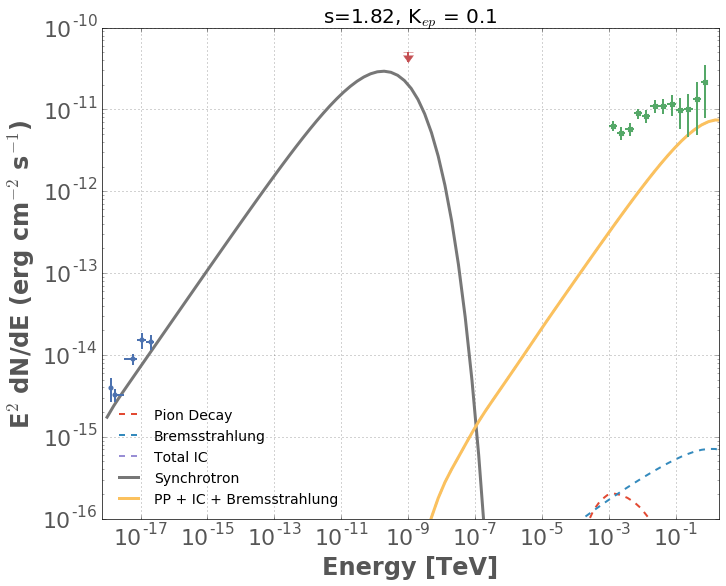

In [33]:
ncolors = plt.rcParams['axes.prop_cycle']
#Plot data + model
# * what should e_unit be? Try GeV, even though I used eV above
# * I need to figure out which param is which in the res file
# * What energy range to plot over?
# * do I not need to put emin/emax in IC?
# * add Kep
# * why is the amp / tev?
energy = np.logspace(-18, 2, 100) * u.TeV
fig = plt.figure(figsize = [10,8])

figure = naima.plot_data([G150Radio,G150_data,xray],figure = fig, e_unit=u.TeV) 
ax = figure.axes[0]

###First PP
alpha = 1.82
Kep = 0.1
amp_PP = g150Res_ICsyncBrems_PP['median'][1] / u.TeV
e_cutoff_PP = g150Res_ICsyncBrems_PP['median'][6] * u.TeV
Wp = g150Res_ICsyncBrems_PP['median'][7]

ECPL_PP = ExponentialCutoffPowerLaw(amp_PP, 10. * u.TeV, alpha, e_cutoff_PP)

nh   = 0.00806*u.cm**-3
dist = 0.38461 * u.kpc
PP = PionDecay(ECPL_PP, nh=nh)

#Plot the computed model emission
ax.loglog(energy, PP.sed(energy, dist),
          lw=2, ls = '--',c=list(ncolors)[0]['color'], label='Pion Decay')#: n=1/cm^3, $W_p (E_p>1\, \mathrm{GeV})$ =%0.2e erg, index_ep = %0.2f, K$_{ep}$ = %0.2f' %(Wp,alpha,Kep))

###Now IC
amp_ICsync = Kep*amp_PP #10**g150Res_ICsync_PP['median'][5] / u.TeV *
e_cutoff_ICsync = g150Res_ICsyncBrems_PP['median'][4] * u.TeV
We = g150Res_ICsyncBrems_PP['median'][8]
B = g150Res_ICsyncBrems_PP['median'][2]*u.uG


ECPL_ICsync = ExponentialCutoffPowerLaw(amp_ICsync, 10. * u.TeV, alpha, e_cutoff_ICsync)

IC = InverseCompton(ECPL_ICsync,
                    seed_photon_fields=['CMB','FIR','NIR'],
                    Eemax=50 * u.PeV, Eemin=1 * u.GeV)

###And Sync
Sync = Synchrotron(ECPL_ICsync,
                    B = B,)

###Finally bremss

Bremss = Bremsstrahlung(ECPL_ICsync,n0=nh)

# Plot the computed IC and Sync model emissions
ax.loglog(energy, Bremss.sed(energy, dist),
          lw=2, ls = '--',c=list(ncolors)[1]['color'], label='Bremsstrahlung')
                   
ax.loglog(energy, IC.sed(energy, dist),
          lw=2, ls = '--',c=list(ncolors)[2]['color'], label='Total IC')#: $W_e (E_e>1\, \mathrm{GeV})$ =%0.2e erg, index_ep = %0.2f, K$_{ep}$ = %0.2f' %(We,alpha,Kep))
                   
ax.loglog(energy, Sync.sed(energy, dist),
          lw=3, c=list(ncolors)[3]['color'], label='Synchrotron')# $W_e (E_e>1\, \mathrm{GeV})$ =%0.2e erg, index_ep = %0.2f, K$_{ep}$ = %0.2f, B = %0.2f $\mathrm{\mu}$G' %(We,alpha,Kep,B.value))

###IC + PP + bresmss
#can I just sum them?
ax.loglog(energy, IC.sed(energy, dist)+PP.sed(energy, dist),
          lw=3,c=list(ncolors)[4]['color'], label='PP + IC + Bremsstrahlung')
                   
# for i, seed, ls in zip(range(4), ['CMB', 'FIR', 'NIR'], ['--', '-.', ':']):
#     ax.loglog(energy, IC.sed(energy, 2 * u.kpc, seed=seed),
#               lw=2, c=naima.plot.color_cycle[i + 1], label=seed, ls=ls)
ax.set_ylim(1e-16, 1e-10)
ax.set_xlim(7e-19,2)
ax.legend(loc='lower left', frameon=False,fontsize = 14)
figure.tight_layout()
plt.xlabel('Energy [TeV]',fontsize =24,weight='bold')


plt.ylabel(r'E$^{2}$ dN/dE (erg cm$^{-2}$ s$^{-1}$)',fontsize = 24,weight='bold')
plt.title(r's=1.82, K$_{ep}$ = 0.1',fontsize = 20)
#plt.xlabel(fontsize='large')
if not os.path.exists('G150_ICsyncBremss_PP_SED_Kep01_sfit.png'):
    figure.savefig('G150_ICsyncBremss_PP_SED_Kep01_sfit.png')
    figure.savefig('G150_ICsyncBremss_PP_SED_Kep01_sfit.pdf')
    figure.savefig('G150_ICsyncBremss_PP_SED_Kep01_sfit.eps')

# 17. IC+PP+Bremss+Sync, radio + GeV + X-ray. Fit s, Ap, E_Cut_p,  E_Cut_e. Don't fit Kep, use xray emitting density upper lim

# Increase nrun and nwalkers: Poor fit
# fixed s
## s =1.82
## Kep = 1
## E_Cut_p: <= 100 TeV

In [74]:
dirN= os.path.join(tDir,'fixedIndex/IC_Sync_bremss_PP_wRadio_Xray_nrun400_Kep1_sfit')
if not os.path.exists(dirN):
    os.mkdir(dirN)
os.chdir(dirN)
%pwd

u'/Users/elunejava/Desktop/naimaTest/fixedIndex/IC_Sync_bremss_PP_wRadio_Xray_nrun400_Kep1_sfit'

# 18. IC+PP+Bremss+Sync, radio + GeV + X-ray. Fit s, Ap, E_Cut_p,  E_Cut_e. Don't fit Kep, use xray emitting density upper lim

# Increase nrun and nwalkers: Best run
# fixed s
## s =1.82
## Kep = 0.1